In [75]:
# the purpose of this test is to check if the 2D kernel can learn to generate pattern present in the training data
# step 1. test of data with same attributes with the same length
# step 2  test of data with same attributes with the different length
# step 3. test with different attributes  and different length

# data generation
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
import math
from torch_geometric.data import Data
import numpy as np



def color_for_element(atomic_num):
    color ='lightgrey'
    if(atomic_num == 1):# H
        color = 'lightgrey'
    elif(atomic_num ==6): # C
        color = 'black'
    elif(atomic_num ==8): # O
        color = 'red'
    elif(atomic_num ==7): # N
        color = 'blue'
    elif(atomic_num ==16): # S
        color = 'yellow'
    elif(atomic_num == 15): # P
        color = 'orange'
    elif(atomic_num ==9): # F
        color = 'lime'
    elif(atomic_num ==17): # Cl
        color = 'limegreen'
    elif(atomic_num ==35): # Br
        color = 'forestgreen'
    elif(atomic_num ==53): # I
        color = 'darkgreen'
    return color

def linestyle_for_bond_type(edge_attr):
    linestyle='-'
    if(edge_attr == 2):
        linestyle='--'
    elif(edge_attr==3):
        linestyle=':'
    elif(edge_attr==4):
        linestyle='-.'
    return linestyle

def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    if torch.all(torch.eq(vector_1,vector_2)):
        return None
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)
    

def vis(data = None, x_neighbor = None, x_focal = None, p_neighbor=None, p_focal=None, edge_attr_neighbor = None, vis_kernel=False, marker_size=None, vis_element=False, only_graph=False):
    fig_size = 5
    marker_size = 500
    lower_bound = -1.5
    upper_bound = 2
    
#     if(vis_kernel ==False):
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)


    if data is not None:
        try:
            p_neighbor = data.p_neighbor
            p_focal = data.p_focal

        except:
            raise Exception('In data, either center position p_focal or position p is not provided')
                  
        try:
            x_neighbor = data.x_neighbor
        except:
            x_neighbor = None
        try:
            x_focal = data.x_focal
        except:
            x_focal = None
        try:
            edge_attr_neighbor = data.edge_attr_neighbor
        except:
            edge_attr_neighbor = None
    else:
        if p_neighbor is None or p_focal is None:
            raise Exception('either provide data, or provide both p_neighbor and p_focal is provided')
    
    if(vis_kernel==False):
        print('====data info====')

        print('p_neighbor:')
        print(p_neighbor)

        if x_neighbor is not None:
            print('\n')
            print('x_neighbor:')
            print(x_neighbor)

        if x_focal is not None:
            print('\n')
            print('x_focal:')
            print(x_focal)

        if p_focal is not None:
            print('\n')
            print('p_focal:')
            print(p_focal)

        if edge_attr_neighbor is not None:
            print('\n')
            print('edge_attr_neighbor:')
            print(edge_attr_neighbor)
    
    if (vis_graph==True):
    
        print('\n')
        s = p_neighbor.shape[0]
        calibrated_p_neighbor = p_neighbor-p_focal
        for i in range(s):
            for j in range(i):
                angle = angle_between_two_vectors(calibrated_p_neighbor[i], calibrated_p_neighbor[j])
                if (angle is not None):
                    print(f'{i}-{j} angle:{angle}')
        print('\n')


        for i in range(s):
            print(f'{i} length:{edge_length(calibrated_p_neighbor[i])}')

        print('=========')

    # annotate and color
    for i in range(p_neighbor.shape[0]):
        if x_neighbor is None or ( vis_kernel == True and vis_element == False):
            plt.annotate(i, (p_neighbor[i,:]))
            color = 'blue'
        else:
            pt = Chem.GetPeriodicTable() 
            atomic_num = int(x_neighbor[i,0].item())
            plt.annotate(pt.GetElementSymbol(atomic_num),(p_neighbor[i,:]))
            if marker_size is None:
                marker_size = x_neighbor[i,2].item()*500
            color = color_for_element(atomic_num)
            
        # draw neighors
        plt.scatter(p_neighbor[i,0], p_neighbor[i,1], color = color, s = marker_size, alpha = 0.5)
        
    # draw focal    
    if ((vis_kernel == True) and (vis_element == False)):
        color = 'dimgrey'
    else:
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x_focal[0][0].item())
        plt.annotate(pt.GetElementSymbol(atomic_num),(0,0))
        color = color_for_element(atomic_num)
    plt.scatter(p_focal[0], p_focal[1], color = color, s= marker_size, alpha = 0.5)
    
    # draw bonds
    for i, each_p_neighbor in enumerate(p_neighbor):
        each_edge_attr_neighbor = edge_attr_neighbor[i]
        linestyle = linestyle_for_bond_type(each_edge_attr_neighbor)
        plt.plot([each_p_neighbor[0], p_focal[0]],[each_p_neighbor[1],p_focal[1]], color = 'black', linestyle=linestyle)
    plt.show()    

def get_kernel_from_kernelsetconv(model, prefix):
    params = model.state_dict()
#     for param in params:
#         print(param)
    
#     num_kernel_sets = int(len(params)/4)
#     print(f'num_kernel_sets:{num_kernel_sets}')

    kernel_list = []
    for i in range(4):
#         prefix = 'fixed'# these will be overwrite by the trainables and will NOT show
#         x_center_array = params[f'{prefix}_kernelconv_set.{i}.x_center']
#         x_support_array = params[f'{prefix}_kernelconv_set.{i}.x_support']
#         edge_attr_support_array = params[f'{prefix}_kernelconv_set.{i}.edge_attr_support']
#         p_support_array = params[f'{prefix}_kernelconv_set.{i}.p_support']

            x_center_array = params[f'{prefix}_kernelconv_set.{i}.x_center']
            print(f'array_type:{type(x_center_array)}')
            x_support_array = params[f'{prefix}_kernelconv_set.{i}.x_support']
            edge_attr_support_array = params[f'{prefix}_kernelconv_set.{i}.edge_attr_support']
            p_support_array = params[f'{prefix}_kernelconv_set.{i}.p_support']
            output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
            kernel_list.append(output_kernel)

    return kernel_list


# def get_kernel_from_kernellayer(model):
#     params = model.state_dict()
# #     for param in params:
# #         print(param)
    
#     num_kernel_sets = int(len(params)/4)
# #     print(f'num_kernel_sets:{num_kernel_sets}')
    
#     kernel_list = []
#     for i in range(num_kernel_sets):

#         x_center_array = params[f'conv.kernel_set.{i}.x_center']
#         x_support_array = params[f'conv.kernel_set.{i}.x_support']
#         edge_attr_support_array = params[f'conv.kernel_set.{i}.edge_attr_support']
#         p_support_array = params[f'conv.kernel_set.{i}.p_support']
#         output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
#         kernel_list.append(output_kernel)
#     return kernel_list



def vis_kernel(kernel, vis_element= False, only_graph=False):
    kernel_list=[]
    if isinstance(kernel, Data):
        kernel_list = [kernel]
    else:
        kernel_list = kernel
    
    for kernel in kernel_list:
        num_sets = kernel.x_support.shape[0]

        for l in range(num_sets):
            kernel.x_neighbor = kernel.x_support[l, :,:]

            kernel.p_neighbor = kernel.p_support[l,:,:]

            kernel.x_focal = kernel.x_center[l,:,:]

            p_center = torch.tensor([0,0])    
            kernel.p_focal = p_center

            kernel.edge_attr_neighbor = kernel.edge_attr_support[l, :,:]

#             subplot(num_sets,4,l+1)
            vis(kernel, vis_kernel=True, vis_element=vis_element)
            if(only_graph==False):
                print(f'===={l}th kernel info====')


                print(f'{l}th-p_support:')
                print(kernel.p_neighbor.shape)

                if x is not None:
                    print('\n')
                    print(f'{l}th-x_support:')
                    print(kernel.x_neighbor)

                if x_focal is not None:
                    print('\n')
                    print(f'{l}th-x_center:')
                    print(kernel.x_focal)

                if p_focal is not None:
                    print('\n')
                    print(f'{l}th-p_center:')
                    print(kernel.p_focal.shape)

                if edge_attr is not None:
                    print('\n')
                    print(f'{l}th-edge_attr_support:')
                    print(kernel.edge_attr_neighbor)
            
        
def vis_graph(data, lower_bound = -4, upper_bound = 5, fig_size=5,  marker_size = 500):

    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)
    
    
    x = data.x
    p = data.p
    edge_index = data.edge_index
    edge_attr = data.edge_attr
    
    for i in range(x.shape[0]):
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x[i,0].item())
        color = color_for_element(atomic_num)
        plt.annotate(i,(p[i,0], p[i,1]))
        plt.scatter(p[i,0], p[i,1], color = color, s = marker_size, alpha = 0.5)
    

    for col in range(edge_index.shape[1]):
        start_idx = edge_index[0,col]
        end_idx = edge_index[1,col]
#         print(f'start_idx:{start_idx}, end_idx:{end_idx}')
        linestyle = linestyle_for_bond_type(edge_attr[col])       
        plt.plot([p[start_idx][0], p[end_idx][0]],  [p[start_idx][1],p[end_idx][1]], color = 'black', linestyle = linestyle, alpha =0.5)
    
#     legend = plt.legend(handles=['--'], labels=["red dotted line"], handlelength=5)

    
def vis_kernel_in_kernelsetconv(model, prefix='trainable'):
    kernel = get_kernel_from_kernelsetconv(model, prefix)
    if isinstance(kernel, Data):
        print(f'kernel:{kernel}')
        
    else:
        pass
        print('kernels:')
        for k in kernel:
            print(k)
    vis_kernel(kernel)

# def vis_kernellayer_in_kernellayer(model):
#     kernel = get_kernel_from_kernellayer(model)
#     if isinstance(kernel, Data):
#         print(f'kernel:{kernel}')
        
#     else:
#         pass
#         print('kernels:')
#         for k in kernel:
#             print(k)
#     vis_kernel(kernel)
    
    
def rotate(p_center, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given p_center.

    The angle should be given in degrees.
    """
    angle = angle * math.pi/180
    
    ox, oy = p_center
#     print(f'ox:{ox}, oy:{oy}')
    px, py = point
#     print(f'px:{px}, py:{py}')
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def tensor_rotate(p_center, points, angle):
    l = []
    for point in points:
        new_p = rotate(p_center, point, angle)
        l.append(new_p)
    l = torch.stack(l, dim=0)
#     print(f'f:{l.shape}')
    return torch.tensor(l)

def graph_rotate(data, p_center, angle):
    p = data.p
    new_p = tensor_rotate(p_center, p, angle)
    new_data = data.clone()
    new_data.p = new_p
    return new_data

# new_p = tensor_rotate(p_center, p, 180)
# # print(new_p)
# # vis(new_p, p_center)

# data_list = []
# for i in range(0, 370, 10):
#     new_p = tensor_rotate(p_center, p, i)
#     data = Data(p = new_p, p_center = p_center)
#     data_list.append(data)

# # for data in data_list:
# #     vis(data, p_center)


# translate
trans = torch.tensor([[1,1]])

# S = 3
x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_support = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1]], dtype = torch.float)
p_support+=trans
p_center = torch.tensor([0,0]) + trans.squeeze(dim =0)


#S = 4
# data
# x = torch.tensor([[1],[1],[1],[1]], dtype = torch.float)
# p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [math.sqrt(0.5), math.sqrt(0.5)]], dtype = torch.float)


# vis(p_neighbor = p_support, p_focal = p_center)
# model = KernelSetConv(L = 10, D=2, node_attr_dim = 5, edge_attr_dim =1)
# vis_kernel_in_model(model)

In [2]:
P =torch.tensor([[0,1, 0],[1,0,0],[0,0,1]], dtype=torch.float)
S = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float)
ones = torch.ones(P.shape)
a=S.mm(P)
print(a)

tensor([[2., 1., 3.],
        [5., 4., 6.],
        [8., 7., 9.]])


calculating rdkit element representation lookup table
====data info====
p_neighbor:
tensor([[ 1.2990e+00,  7.5000e-01],
        [-1.2990e+00,  7.5000e-01],
        [-1.9429e-16, -1.5000e+00]])


x_neighbor:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


x_focal:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


p_focal:
tensor([-8.3267e-17, -1.1102e-16])


edge_attr_neighbor:
tensor([[2],
        [1],
        [1]])


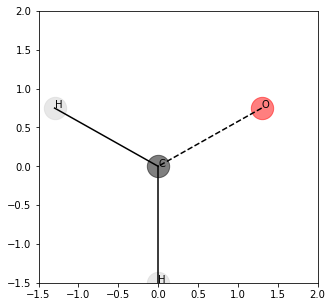

/home/liuy69/bin/anaconda2/envs/GCN_property/lib/python3.6/site-packages/ipykernel_launcher.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [3]:
# test of p with different attributes
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit
import torch
from torch_geometric.data import Data

elements = ['H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
elem_lst =None


def lookup_from_rdkit(elements):
    global elem_lst

    if elem_lst is None:
        print('calculating rdkit element representation lookup table')
        elem_rep_lookup = []
        for elem in elements:
            pt = Chem.GetPeriodicTable() 

            if isinstance(elem, int):
                num=elem
                sym=pt.GetElementSymbol(num)
            else:
                num = pt.GetAtomicNumber(elem)
                sym = elem
            w = pt.GetAtomicWeight(elem)

            Rvdw = pt.GetRvdw(elem)
        #     Rcoval = pt.GetRCovalent(elem)
            valence = pt.GetDefaultValence(elem)
            outer_elec = pt.GetNOuterElecs(elem)

            elem_rep=[num, w,  Rvdw, valence, outer_elec]
#             print(elem_rep)


            elem_rep_lookup.append(elem_rep)
        elem_lst = elem_rep_lookup.copy()
        return elem_rep_lookup
    else:
        return elem_lst




def get_atom_rep(atomic_num, package='rdkit'):
    '''use rdkit or pymatgen to generate atom representation
    '''
    max_elem_num = 118
    element_nums= [x+1 for x in range(max_elem_num)]


    if package =='rdkit':
        elem_lst = lookup_from_rdkit(element_nums)
    elif package == 'pymatgen':
        raise Exception('pymatgen implementation is deprecated.')
        #elem_lst = lookup_from_pymatgen(element_nums)
    else:
        raise Exception('cannot generate atom representation lookup table')

    result = 0
    try:
        result = elem_lst[atomic_num - 1]
    except:
        print(f'error: atomic_num {atomic_num} does not exist')

    return result


def smiles2graph(D, smiles):
    if D==None:
        raise Exception('smiles2grpah() needs to input D to specifiy 2D or 3D graph generation.')
    
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
#     mol.UpdatePropertyCache(strict=False)
    mol = Chem.AddHs(mol)
    
    if D==2:
        rdkit.Chem.rdDepictor.Compute2DCoords(mol)
    if D==3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
    
    conf = mol.GetConformer()
    
    atom_pos = []
    atom_attr =[]
    
    # get atom attributes and positions
    for i, atom in enumerate(mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()
        h = get_atom_rep(atomic_num)
    
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
    
    # get bond attributes
    edge_list = []
    edge_attr_list =[]
    for idx, edge in enumerate(mol.GetBonds()):
        i = edge.GetBeginAtomIdx()
        j = edge.GetEndAtomIdx()
        
        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type ==Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type ==Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type ==Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type ==Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]     
            

        edge_list.append((i, j))
        edge_attr_list.append(bond_attr) 
#         print(f'i:{i} j:{j} bond_attr:{bond_attr}')

        edge_list.append((j, i))
        edge_attr_list.append(bond_attr)    
#         print(f'j:{j} j:{i} bond_attr:{bond_attr}')    
    
    x = torch.tensor(atom_attr)
    p = torch.tensor(atom_pos)
    edge_index = torch.tensor(edge_list).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list)
#     print(p)
        
    return x, p, edge_index, edge_attr

smiles = 'C(=O)([H])[H]'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# for 3D
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# conf = mol.GetConformer()


# for 2D
rdkit.Chem.rdDepictor.Compute2DCoords(mol)
conf = mol.GetConformer()
atom_pos = []
atom_attr =[]
x_focal = None
for i, atom in enumerate(mol.GetAtoms()):
    atomic_num = atom.GetAtomicNum()
    h = get_atom_rep(atomic_num, 'rdkit')
    if atomic_num == 6:
        p_focal = torch.tensor([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z ])
        x_focal = torch.tensor(h)
    else:
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
        
edge_attr = []
for j, edge in enumerate(mol.GetBonds()):
    bond_type = edge.GetBondType()
    if bond_type ==Chem.rdchem.BondType.SINGLE:
        edge_attr.append(1)
    elif bond_type ==Chem.rdchem.BondType.DOUBLE:
        edge_attr.append(2)
    elif bond_type ==Chem.rdchem.BondType.TRIPLE:
        edge_attr.append(3)
    elif bond_type ==Chem.rdchem.BondType.AROMATIC:
        edge_attr.append(4)
edge_attr_neighbor = torch.tensor(edge_attr).unsqueeze(0).T
                              
p_neighbor = torch.tensor(atom_pos)
x_neighbor = torch.tensor(atom_attr)                              
x_focal = x_focal.unsqueeze(0)
# print(p)
# print(origin)
# print(x)
  
    
#============generate a list of same receptive field 
data = Data(p_neighbor=p_neighbor, x_neighbor=x_neighbor, x_focal=x_focal, edge_attr_neighbor=edge_attr_neighbor, p_focal=p_focal)
# print(data)
vis(data=data)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(p_focal, p_neighbor, i)
    data = Data(p = new_p, p_focal = p_focal, x_neighbor=x_neighbor, x_focal = x_focal, edge_attr = edge_attr)
    data_list.append(data)
#     vis(data=data)







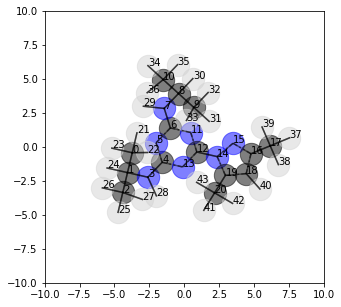

In [4]:
x =torch.tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])  
p = torch.tensor([[-3.7256, -0.4303],                                                                                                                                                                                                [-4.0641, -1.8916],                                                                                                                                                                                                [-4.4027, -3.3529],                                                                                                                                                                                                [-2.6028, -2.2302],                                                                                                                                                                                                [-1.5790, -1.1339],                                                                                                                                                                                                [-2.0164,  0.3008],                                                                                                                                                                                                [-0.9926,  1.3971],                                                                                                                                                                                                [-1.4300,  2.8319],                                                                                                                                                                                                [-0.4062,  3.9281],                                                                                                                                                                                                [ 0.6900,  2.9043],                                                                                                                                                                                                [-1.5024,  4.9520],                                                                                                                                                                                                [ 0.4687,  1.0585],                                                                                                                                                                                                [ 0.9062, -0.3763],                                                                                                                                                                                                [-0.1177, -1.4725],                                                                                                                                                                                                [ 2.3675, -0.7148],                                                                                                                                                                                                [ 3.5003,  0.2684],                                                                                                                                                                                                [ 4.7854, -0.5051],                                                                                                                                                                                                [ 6.1666,  0.0799],                                                                                                                                                                                                [ 4.4469, -1.9664],                                                                                                                                                                                                [ 2.9525, -2.0960],                                                                                                                                                                                                [ 2.1789, -3.3812],                                                                                                                                                                                                [-3.3870,  1.0310],                                                                                                                                                                                                [-2.6322, -0.4120],                                                                                                                                                                                                [-5.1869, -0.0918],                                                                                                                                                                                                [-5.5254, -1.5531],                                                                                                                                                                                                [-4.7412, -4.8142],                                                                                                                                                                                                [-5.8640, -3.0144],                                                                                                                                                                                                [-2.9935, -3.8671],                                                                                                                                                                                                [-1.9937, -3.6010],                                                                                                                                                                                                [-2.9217,  2.9898],                                                                                                                                                                                                [ 0.6176,  5.0244],                                                                                                                                                                                                [ 1.7863,  1.8804],                                                                                                                                                                                                [ 1.7139,  4.0005],                                                                                                                                                                                                [ 0.1592,  1.9483],                                                                                                                                                                                                [-2.5987,  5.9758],                                                                                                                                                                                                [-0.4786,  6.0482],                                                                                                                                                                                                [-2.6523,  3.9887],                                                                                                                                                                                                [ 7.5479,  0.6649],                                                                                                                                                                                                [ 6.7517, -1.3013],                                                                                                                                                                                                [ 5.5816,  1.4611],                                                                                                                                                                                                [ 5.4301, -3.0993],                                                                                                                                                                                                [ 1.4054, -4.6663],                                                                                                                                                                                                [ 3.4641, -4.1547],                                                                                                                                                                                                [ 0.8938, -2.6076]])       
edge_index = torch.tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,                                                                                                                                             8, 10,  6, 11, 11, 12, 12, 13, 12, 14, 14, 15, 15, 16, 16, 17, 16, 18,                                                                                                                                            18, 19, 19, 20, 13,  4, 19, 14,  0, 21,  0, 22,  0, 23,  1, 24,  2, 25,                                                                                                                                             2, 26,  2, 27,  3, 28,  7, 29,  8, 30,  9, 31,  9, 32,  9, 33, 10, 34,                                                                                                                                            10, 35, 10, 36, 17, 37, 17, 38, 17, 39, 18, 40, 20, 41, 20, 42, 20, 43],                                                                                                                                          [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,                                                                                                                                            10,  8, 11,  6, 12, 11, 13, 12, 14, 12, 15, 14, 16, 15, 17, 16, 18, 16,                                                                                                                                            19, 18, 20, 19,  4, 13, 14, 19, 21,  0, 22,  0, 23,  0, 24,  1, 25,  2,                                                                                                                                            26,  2, 27,  2, 28,  3, 29,  7, 30,  8, 31,  9, 32,  9, 33,  9, 34, 10,                                                                                                                                            35, 10, 36, 10, 37, 17, 38, 17, 39, 17, 40, 18, 41, 20, 42, 20, 43, 20]])  
edge_attr = torch.tensor([[1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1]])    
data = Data(x = x, p= p , edge_index= edge_index, edge_attr = edge_attr)
vis_graph(data, lower_bound = -10, upper_bound = 10)



In [20]:
import torch

from torch_geometric.data import Data

from rdkit import Chem
import rdkit
# from rdkit import Chem
# # from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

import pandas as pd
import os

import random


def generate_1hop_kernel(D, typical_compound_smiles, center_atom_id, x_dim=None):
    #     '''
    #     given a typical compound containing a certain kernal, and the center atom id, genrate the kernel
    #     '''
    if D == None:
        raise Exception('generate_kernel2grpah() needs to input D to specifiy 2D or 3D graph generation.')

    smiles = typical_compound_smiles.replace(r'/=', '=')
    smiles = typical_compound_smiles.replace(r'\=', '=')

    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    # mol.UpdatePropertyCache(strict=False)
    mol = Chem.AddHs(mol)

    if D == 2:
        Chem.rdDepictor.Compute2DCoords(mol)
    if D == 3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)

    conf = mol.GetConformer()

    all_atoms = mol.GetAtoms()
    center_atom = all_atoms[center_atom_id]
    # print(f'center atom:{center_atom.GetSymbol()}')

    atom_pos = []
    atom_attr = []

    supports = center_atom.GetNeighbors()

    if x_dim is None:
        x_center = get_atom_rep(center_atom.GetAtomicNum())
    else:
        x_center = [random.uniform(0, 1) for i in range(x_dim)]

    p_list = []
    x_list = []
    bond_attr_list = []
    # print()
    # print('atom idx:')
    # for i, atom in enumerate(all_atoms):
    #     print(f'{atom.GetIdx()}, {atom.GetSymbol()}')

    for idx, edge in enumerate(center_atom.GetBonds()):
        support_start_id = edge.GetBeginAtomIdx()
        support_end_id = edge.GetEndAtomIdx()
#         print(f'support_start_id:{support_start_id}')
#         print(f'support_end_id:{support_end_id}')
        if (support_start_id == center_atom_id):
            support_id = support_end_id
        else:
            support_id = support_start_id
        support = all_atoms[support_id]
        if x_dim is None:
            x_list.append(get_atom_rep(support.GetAtomicNum()))
        else:
            x_list.append([random.uniform(0, 1) for i in range(x_dim)])
        if D == 2:
            p_support = p_list.append([conf.GetAtomPosition(support_id).x - conf.GetAtomPosition(center_atom_id).x, conf.GetAtomPosition(support_id).y - conf.GetAtomPosition(center_atom_id).y])
        if D == 3:
            p_support = p_list.append([conf.GetAtomPosition(support_id).x - conf.GetAtomPosition(center_atom_id).x, conf.GetAtomPosition(support_id).y -
                                       conf.GetAtomPosition(center_atom_id).y, conf.GetAtomPosition(support_id).z - conf.GetAtomPosition(center_atom_id).z])

        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type == Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type == Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type == Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]
        bond_attr_list.append(bond_attr)

    x_center = torch.tensor(x_center).unsqueeze(0).unsqueeze(0)
    x_support = torch.tensor(x_list).unsqueeze(0)
    p_support = torch.tensor(p_list).unsqueeze(0)
    edge_attr_support = torch.tensor(bond_attr_list, dtype=p_support.dtype).unsqueeze(0)

#     print('x_center')
#     print(x_center)
#     print('x_support')
#     print(x_support)
#     print('p_support')
#     print(p_support)
#     print('edge_attr_support')
#     print(edge_attr_support)
    data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
    return data  # x_center, x_support, p_support, edge_attr_support


def generate_kernel_with_angle_and_length_and_edge_attr(D, typical_compound_smiles, center_atom_id, x_dim):
    '''
    generate a kernel with typical angle and lenth and edge_attr, but randomize x attribute
    '''
    return generate_1hop_kernel(D, typical_compound_smiles, center_atom_id, x_dim=x_dim)


def read_kernel_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    df = df.transpose()
    kernel_dict = df.to_dict(orient='list')
    return kernel_dict


def print_kernel_files():
    root = 'customized_kernels'
    files = os.listdir(root)
    for file in files:
        df = pd.read_csv(root + '/' + file)
        print(df)


# degree1
hop1_degree1_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel1.csv')

# degree2
hop1_degree2_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel2.csv')


# degree3
hop1_degree3_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel3.csv')


# degree4
hop1_degree4_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel4.csv')


# ===1hop kernels - 2D===
# degree1
functional_groups = hop1_degree1_functional_groups
hop1_2D_degree1_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree2
functional_groups = hop1_degree2_functional_groups
hop1_2D_degree2_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree3
functional_groups = hop1_degree3_functional_groups
hop1_2D_degree3_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree4
functional_groups = hop1_degree4_functional_groups
hop1_2D_degree4_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]

# ===1hop kernels - 3D===
# degree1
functional_groups = hop1_degree1_functional_groups
hop1_3D_degree1_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree2
functional_groups = hop1_degree2_functional_groups
hop1_3D_degree2_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree3
functional_groups = hop1_degree3_functional_groups
hop1_3D_degree3_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree4
functional_groups = hop1_degree4_functional_groups
hop1_3D_degree4_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]


def get_hop1_kernel_list(D):
    if D == 2:
        # to make sure the original list is untouched, use the copied one
        return hop1_2D_degree1_kernels_list.copy(), hop1_2D_degree2_kernels_list.copy(), hop1_2D_degree3_kernels_list.copy(), hop1_2D_degree4_kernels_list.copy()
    elif D == 3:
        return hop1_3D_degree1_kernels_list.copy(), hop1_3D_degree2_kernels_list.copy(), hop1_3D_degree3_kernels_list.copy(), hop1_3D_degree4_kernels_list.copy()
    else:
        raise Exception('get_hop1_kernel_list(): invalid D')




In [74]:
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import torch
from torch.nn import ModuleList, CosineSimilarity, Module, ModuleList, Linear, Sigmoid
# from torch.nn import
from torch.nn.parameter import Parameter

from itertools import permutations
import math
import pandas as pd

import os



torch.autograd.set_detect_anomaly(True)

class KernelConv(Module):
    def __init__(self, L=None, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel=None, requires_grad=True, init_length_sc_weight = 0.2, init_angle_sc_weight = 0.2,  init_center_attr_sc_weight = 0.2, init_support_attr_sc_weight = 0.2, init_edge_attr_support_sc_weight=0.2, weight_requires_grad= False):
        super(KernelConv, self).__init__()
        if init_kernel is None:
            if (L is None) or (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
                raise Exception(
                    'either numer of kernels L, convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
            else:
                init_kernel = Data(x_center=torch.randn(L, 1, node_attr_dim), x_support=torch.randn(
                    L, num_supports, node_attr_dim), edge_attr_support=torch.randn(L, num_supports, edge_attr_dim), p_support=torch.randn(L, num_supports, D))

        self.num_kernels = init_kernel.x_center.shape[0]

        x_center_tensor = init_kernel.x_center
        self.x_center = Parameter(x_center_tensor, requires_grad=requires_grad)

        x_support_tensor = init_kernel.x_support
        self.x_support = Parameter(x_support_tensor, requires_grad=requires_grad)

        edge_attr_support_tensor = init_kernel.edge_attr_support
        self.edge_attr_support = Parameter(edge_attr_support_tensor, requires_grad=requires_grad)

        p_support_tensor = init_kernel.p_support
#         print(f'p_support_tensor:{p_support_tensor.shape}')
        self.p_support = Parameter(p_support_tensor, requires_grad=requires_grad)

        self.length_sc_weight = Parameter(torch.tensor(init_length_sc_weight), requires_grad = weight_requires_grad)
        self.angle_sc_weight = Parameter(torch.tensor(init_angle_sc_weight), requires_grad = weight_requires_grad)
        self.center_attr_sc_weight = Parameter(torch.tensor(init_center_attr_sc_weight), requires_grad = weight_requires_grad)
        self.support_attr_sc_weight = Parameter(torch.tensor(init_support_attr_sc_weight), requires_grad = weight_requires_grad)
        self.edge_attr_support_sc_weight = Parameter(torch.tensor(init_edge_attr_support_sc_weight), requires_grad = weight_requires_grad)

    def get_num_kernels(self):
        return self.num_kernels

    def permute(self, x):
        #         print('permute')
        #         print('x')
        #         print(x.shape)
        rows = x.shape[1]
        l = [x[:, torch.tensor(permute), :]
             for permute in list(permutations(range(rows)))]
        output = torch.stack(l, dim=1)
#         print('permuted')
#         print(output.shape)
        return output

    def intra_angle(self, p):
        '''
        angles between each row vectors
        '''
        cos = CosineSimilarity(dim=-1)
        new_p = torch.roll(p, 1, dims=-2)
#         print(f'new p:')
#         print(new_p)
        sc = cos(new_p, p)
#         print(f'intra angle sc:{sc.shape}')
        return sc

    def arctan_sc(self, tensor1, tensor2, dim=None):
        diff = torch.square(tensor1 - tensor2)
#         print(diff)
        if dim is not None:
            sc = torch.sum(diff, dim=dim)
        else:
            sc = torch.sum(diff)
        sc = torch.atan(1 / (sc+1e-8))
        return sc

    def get_angle_score(self, p_neighbor, p_support):
        #         print('get_angle_score')
        #         print(f'p_neighbor:{p_neighbor.shape}')
        #         print(p_neighbor.shape)
        #         print(f'p_support:{p_support.shape}')
        #         print(p_support.shape)
        if(p_support.shape[-2] == 1):
            return torch.full((p_support.shape[0], p_neighbor.shape[0]), math.pi / 2, device=p_neighbor.device)
#         cos = CosineSimilarity(dim = 1)

        p_neighbor = p_neighbor.unsqueeze(0).unsqueeze(0).expand(
            p_support.shape[0], p_support.shape[1], p_neighbor.shape[-3], p_neighbor.shape[-2], p_neighbor.shape[-1])
#         p_neighbor = p_neighbor.unsqueeze(0).expand(p_support.shape)
#         print(f'p_neighbor:{p_neighbor.shape}')
        intra_p_neighbor_angle = self.intra_angle(p_neighbor)
#         intra_p_neighbor_dist = intra_p_neighbor_dist.unsqueeze(0).expand(p_support.shape[0], p_neighbor.shape[0],p_neighbor.shape[1])
#         print(f'intra_p_neighbor_dist:{intra_p_neighbor_dist.shape}')

#         p_support = p_support.expand(p_neighbor.shape)
#         print(f'p_support:{p_support.shape}')
        intra_p_support_angle = self.intra_angle(p_support)
#         intra_p_support_dist = intra_p_support_dist.unsqueeze(1).expand(p_support.shape[0], p_neighbor.shape[0],p_support.shape[1])
#         print(f'intra_p_support_dist:{intra_p_support_dist.shape}')

#         sc = cos(intra_p_neighbor_dist, intra_p_support_dist)
#         sc = torch.dot(intra_p_neighbor_dist, intra_p_support_dist.T)
        sc = self.arctan_sc(intra_p_neighbor_angle,
                            intra_p_support_angle, dim=(-1))
#         print(f'inner angle_sc:{sc.shape}')
        return sc.squeeze(1)

    def get_length_score(self, p_neighbor, p_support):
        len_p_neighbor = torch.norm(p_neighbor, dim=-1)
        len_p_support = torch.norm(p_support, dim=-1)

#         print('len_p_neighbor')
#         print(f'len_p_neighbor:{len_p_neighbor.shape}')
#         print(f'len_p_support:{len_p_support.shape}')

        # inverse of L2 norm
        sc = self.arctan_sc(len_p_neighbor, len_p_support, dim=(-1))
#         diff = torch.square(len_p_neighbor - len_p_support)
#         sc = torch.sum(diff)
#         sc = torch.atan(1/sc)

# #         print(sc)
        return sc

    def get_support_attribute_score(self, x_nei, x_support):
        #         print(f'x_nei:{x_nei.shape}')
        #         print(f'x_suppport:{x_support.shape}')
        x_nei = x_nei.unsqueeze(0).unsqueeze(0).expand(
            x_support.shape[0], x_support.shape[1], x_nei.shape[0], x_nei.shape[1], x_nei.shape[2])
        x_support = x_support.unsqueeze(2).expand(x_nei.shape)

        sc = self.arctan_sc(x_nei, x_support, dim=(-2, -1))
        return sc

    def get_center_attribute_score(self, x_focal, x_center):
        # inverse of L2 norm
        #         print(f'center attri:{type(x_focal)}, {type(x_center)}')
        #         print(f'x_focal:{x_focal.shape}, x_center:{x_center.shape}')
        #         print(x_focal)
        #         print(x_center)
        #         diff = torch.square(x_focal - x_center)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        x_focal = x_focal.unsqueeze(0).expand(
            x_center.shape[0], x_focal.shape[0], x_focal.shape[1])
        x_center = x_center.expand(x_focal.shape)
#         print('x_focal')
#         print(x_focal)
#         print('x_center')
#         print(x_center)

        sc = self.arctan_sc(x_focal, x_center, dim=(-1))
        return sc

    def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
        #         print('edge_attr_nei')
        #         print(edge_attr_nei)
        #         print('edge_attr_support')
        #         print(edge_attr_support)
        #         diff = torch.square(edge_attr_nei - edge_attr_support)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        sc = self.arctan_sc(edge_attr_nei, edge_attr_support, dim=(-2, -1))
        return sc

    def calculate_total_score(self, x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor):
        # calibrate p_neighbor
        p_neighbor = p_neighbor - p_focal.unsqueeze(1)

        # get kernel params
        x_center = self.x_center
        x_support = self.x_support
        edge_attr_support = self.edge_attr_support
        p_support = self.p_support

        # print('=====cal total sc')
        # print(f'x_center:{x_center.shape}')
        # print(f'x_support:{x_support.shape}')
        # print(f'edge_attr_support:{edge_attr_support.shape}')
        # print(f'p_support:{p_support.shape}')
        # print('\n')
        # print(f'x_focal:{x_focal.shape}')
        # print(f'p_focal:{p_focal.shape}')
        # print(f'x_neighbor:{x_neighbor.shape}')
        # print(f'p_neighbor:{p_neighbor.shape}')
        # print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')

        # because every sub-score is calculated using actan function, which peaks at pi/2, so this max_atn is used to normalized the score so it is in [0,1]
        max_atan = torch.tensor([math.pi / 2], device=p_neighbor.device)

        # calculate the support attribute score
        permuted_x_support = self.permute(x_support)
#         print(f'permuted_x_support:{permuted_x_support.shape}')
        support_attr_sc = self.get_support_attribute_score(x_neighbor, permuted_x_support) / max_atan
#         print(f'support_attr_sc:{support_attr_sc}')
        # get the best support_attr_sc and its index
        best_support_attr_sc, best_support_attr_sc_index = torch.max(support_attr_sc, dim=1)
#         print(f'best_support_attr_sc:{best_support_attr_sc}, index:{best_support_attr_sc_index.shape}')
        # print(f'index:{best_support_attr_sc_index}')

        # calculate the angle score
        permuted_p_support = self.permute(p_support)
        permuted_p_support = permuted_p_support.unsqueeze(2).expand(
            permuted_p_support.shape[0], permuted_p_support.shape[1], best_support_attr_sc_index.shape[1], permuted_p_support.shape[2], permuted_p_support.shape[3])
#         print(f'permuted_p_support:{permuted_p_support}')
        selected_index = best_support_attr_sc_index.unsqueeze(1).unsqueeze(-1).unsqueeze(-1).expand(
            permuted_p_support.shape[0], 1, best_support_attr_sc_index.shape[-1], permuted_p_support.shape[3], permuted_p_support.shape[4])
        best_p_support = torch.gather(permuted_p_support, 1, selected_index)
#         print(f'best_p_support:{best_p_support}')
        angle_sc = self.get_angle_score(p_neighbor, best_p_support) / max_atan
        # print(f'angle_sc.shape:{angle_sc.shape}')

        # calculate length
        best_p_support = best_p_support.squeeze(1)
#         print(f'best_p_support:{best_p_support.shape}')
        length_sc = self.get_length_score(p_neighbor, best_p_support) / max_atan
        # print(f'length_sc.shape:{length_sc.shape}')

        # calculate the center attribute score
#         print(f'x_center:{x_center.shape}')
        center_attr_sc = self.get_center_attribute_score(x_focal, x_center) / max_atan
        # print(f'center_attr_sc.shape:{center_attr_sc.shape}')

        # calculate the edge attribute score
        selected_index = best_support_attr_sc_index.unsqueeze(-1).unsqueeze(-1).expand(
            best_support_attr_sc_index.shape[0], best_support_attr_sc_index.shape[1], edge_attr_support.shape[-2], edge_attr_support.shape[-1])
#         print(f'edge_attr_support:{edge_attr_support.shape}')
        permuted_edge_attr_support = self.permute(edge_attr_support)
#         print(f'permuted:{permuted_edge_attr_support.shape}')
#         print(f'best_angle_sc_index:{best_angle_sc_index.shape}')
        best_edge_attr_support = torch.gather(
            permuted_edge_attr_support, 1, selected_index)
#         print(f'best_edge_attr_support:{selected_index.shape}')
#         print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')
#         print(f'best_edge_attr_support:{best_edge_attr_support.shape}')
        edge_attr_support_sc = self.get_edge_attribute_score(edge_attr_neighbor, best_edge_attr_support) / max_atan
        # print(f'edge_attr_support_sc.shape:{edge_attr_support_sc.shape}')


#         # convert each score to correct dimension
#         angle_sc = angle_sc
#         length_sc = length_sc
        support_attr_sc = best_support_attr_sc  # .unsqueeze(dim=0)
#         center_attr_sc = center_attr_sc
#         edge_attr_support_sc = edge_attr_support_sc

        # the maxium value a arctain function can get

        one = torch.tensor([1], device=p_neighbor.device)
        sc = (length_sc * self.length_sc_weight +
            angle_sc * self.angle_sc_weight +
            support_attr_sc * self.support_attr_sc_weight +
            center_attr_sc * self.center_attr_sc_weight +
            edge_attr_support_sc * self.edge_attr_support_sc_weight)/ 5


        # sc = torch.atan(1 /
        #                 (torch.square(length_sc - max_atan) +
        #                  torch.square(angle_sc - max_atan) +
        #                  torch.square(support_attr_sc - max_atan) +
        #                  torch.square(center_attr_sc - max_atan) +
        #                  torch.square(edge_attr_support_sc - max_atan)
        #                  )).squeeze(0)
        # sc = sc / max_atan  # normalize the score to be in [0,1]


        return sc, length_sc, angle_sc, support_attr_sc, center_attr_sc, edge_attr_support_sc

    def forward(self, *argv, **kwargv):
        if len(kwargv) == 1:
            x_focal = kwargv['data'].x_focal
            p_focal = kwargv['data'].p_focal
            x_neighbor = kwargv['data'].x_neighbor
            p_neighbor = kwargv['data'].p_neighbor
            edge_attr_neighbor = kwargv['data'].edge_attr_neighbor
        else:
            x_focal = kwargv['x_focal']
            p_focal = kwargv['p_focal']
            x_neighbor = kwargv['x_neighbor']
            p_neighbor = kwargv['p_neighbor']
            edge_attr_neighbor = kwargv['edge_attr_neighbor']

        if(p_focal.shape[-1] != self.p_support.shape[-1]):
            raise Exception(f'data coordinates is of {p_focal.shape[-1]}D, but the kernel is {self.p_support.shape[-1]}D')


#         x, x_focal, p, edge_attr, edge_index = self.convert_graph_to_receptive_field(x, p, edge_index, edge_attr)

        sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = self.calculate_total_score(
            x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor)

        # print('\n')
        # print(f'len sc:{length_sc}')
        # print(f'angle sc:{angle_sc}')
        # print(f'support attribute_sc:{supp_attr_sc}')
        # print(f'center_attr_sc:{center_attr_sc}')
        # print(f'edge attribute score:{edge_attr_support_sc}')
        # print(f'total sc: {sc.shape}')
        return sc  # , length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc


class BaseKernelSetConv(Module):
    # , trainable_kernelconv2=None, trainable_kernelconv3=None, trainable_kernelconv4=None, ):
    def __init__(self, fixed_kernelconv1=None, fixed_kernelconv2=None, fixed_kernelconv3=None, fixed_kernelconv4=None, trainable_kernelconv1=None, trainable_kernelconv2=None, trainable_kernelconv3=None, trainable_kernelconv4=None):
        super(BaseKernelSetConv, self).__init__()

        self.fixed_kernelconv_set = ModuleList([fixed_kernelconv1, fixed_kernelconv2, fixed_kernelconv3, fixed_kernelconv4])
        self.num_fixed_kernel_list = []
        if (fixed_kernelconv1 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv1.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv2 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv2.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv3 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv3.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv4 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv4.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)

        # if (trainable_kernelconv1 is not None) and (trainable_kernelconv2 is not None) and (trainable_kernelconv3 is not None) and (trainable_kernelconv4 is not None):
        #     self.trainable_kernelconv_set = ModuleList([trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4]
        #                                                )  # , trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4])
        #     self.num_trainable_kernel_list = [trainable_kernelconv1.get_num_kernels(), trainable_kernelconv2.get_num_kernels(),
        #                                       trainable_kernelconv3.get_num_kernels(), trainable_kernelconv4.get_num_kernels()]
        # else:
        #     self.trainable_kernelconv_set = ModuleList([])
        #     self.num_trainable_kernel_list = []

        self.trainable_kernelconv_set = ModuleList([trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4])
        self.num_trainable_kernel_list = []
        if (trainable_kernelconv1 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv1.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv2 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv2.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv3 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv3.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv4 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv4.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)

        # num of kernels for each degree, combining both fixed and trainable kerenls
        self.num_kernel_list = []
        for i in range(4):
            num = 0
            if(self.num_fixed_kernel_list[i] is not None):
                num = self.num_fixed_kernel_list[i]
            if(self.num_trainable_kernel_list[i] is not None):
                num += self.num_trainable_kernel_list[i]
            self.num_kernel_list.append(num)



        print(f'self.num_kernel_list:{self.num_kernel_list}')
#         kernel_set = ModuleList(
#             [KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
#             ])

    def get_degree_index(self, x, edge_index):
        # print(f'edge_index:{edge_index.shape}, x:{x.shape}')
        deg = degree(edge_index[0], x.shape[0])
        return deg

    def get_neighbor_index(self, edge_index, center_index):
        #         print('edge_index')
        #         print(edge_index)
        #         print('\n')
        #         print('center_index')
        #         print(center_index)
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]
        return edge_index[1, d]

    def get_focal_nodes_of_degree(self, deg, x, p, edge_index):
        '''
        outputs
        ori_x: a feature matrix that only contains rows (i.e. the center node) having certain degree
        ori_p: a position matrix that only contains rows (i.e. the center node) having certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        selected_index = (deg_index == deg).nonzero(as_tuple=True)
        x_focal = torch.index_select(input=x, dim=0, index=selected_index[0])
        p_focal = torch.index_select(input=p, dim=0, index=selected_index[0])

        return x_focal, p_focal, selected_index[0]

    def get_edge_attr_support_from_center_node(self, edge_attr, edge_index, center_index):
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]

        # normalize bond id
        e = (d / 2).long()
#         bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
        bond_id = torch.tensor([2 * x for x in e], device=a.device)
#         print('bond_id')
#         print(bond_id)

        # select bond attributes with the bond id
        nei_edge_attr = torch.index_select(
            input=edge_attr, dim=0, index=bond_id)

        return nei_edge_attr

    def get_neighbor_nodes_and_edges_of_degree(self, deg, x, p, edge_index, edge_attr):
        '''
        inputs:
        deg: the query degree
        num_focal: the number of focal nodes of degree deg in the graph

        outputs:
        nei_x: a feature matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        nei_p: a position matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        center_index = (deg_index == deg).nonzero(as_tuple=True)[0]
        num_focal = len(center_index)
#         print('center_index')
#         print(center_index)

        nei_x_list = []
        nei_p_list = []
        nei_edge_attr_list = []
        for i in range(num_focal):
            nei_index = self.get_neighbor_index(edge_index, center_index[i])
#             print(f'nei_index:{nei_index.shape}')

            nei_x = torch.index_select(x, 0, nei_index)
#             print(f'nei_x:{nei_x.shape}')
            nei_p = torch.index_select(p, 0, nei_index)
#             print(f'nei_p:{nei_p.shape}')
            nei_edge_attr = self.get_edge_attr_support_from_center_node(
                edge_attr, edge_index, center_index[i])
#             print('\n nei_edge_attr')
#             print(nei_edge_attr)

            nei_x_list.append(nei_x)
            nei_p_list.append(nei_p)
            nei_edge_attr_list.append(nei_edge_attr)

        nei_x = torch.stack(nei_x_list, dim=0)
        nei_p = torch.stack(nei_p_list, dim=0)
        nei_edge_attr = torch.stack(
            nei_edge_attr_list, dim=0)

#         print('nei_edge_attr')
#         print(nei_edge_attr.shape)

        return nei_x, nei_p, nei_edge_attr

    def convert_graph_to_receptive_field(self, deg, x, p, edge_index, edge_attr):
        x_focal, p_focal, selected_index = self.get_focal_nodes_of_degree(
            deg=deg, x=x, p=p, edge_index=edge_index)

        num_focal = x_focal.shape[0]
        # print(f'num_focal:{num_focal}')
        if num_focal != 0:
            x_neighbor, p_neighbor, edge_attr_neighbor = self.get_neighbor_nodes_and_edges_of_degree(
                deg=deg, x=x, edge_index=edge_index, p=p, edge_attr=edge_attr)
#             print(f'x_neighbor:{x_neighbor.shape}')
#             print(f'p_neighbor:{p_neighbor.shape}')
            return x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index
        return None

    def get_reorder_index(self, index):
        '''
        get the index to rearrange output score matrix so that it corespond to the order in the original x matrix

        '''
        rearranged, new_index = torch.sort(index, dim=0)

        return new_index

    def format_output(self, output):
        '''
        change the shape of output from (L, num_nodes, 4) to (num_nodes, 4*L)
        '''
        a = [output[i, :, :] for i in range(output.shape[0])]
        return torch.cat(a, dim=1)

    def save_score(self, sc):
        root = 'customized_kernels'
        print('saving score...')
        sc_np = sc.cpu().detach().numpy()
        files = os.listdir(root)
        headers = []
        for i, file in enumerate(files):
            names = list(pd.read_csv(root + '/' + file)['name'])
            headers += names
            rand_names = ['std_kernel'] * self.num_trainable_kernel_list[i]
            headers += rand_names
        print(headers)
        sc_df = pd.DataFrame(sc_np, columns=headers)
        sc_df = sc_df.transpose()
        sc_df.to_csv('scores.csv')

    def forward(self, *argv, **kwargv):
        '''
        inputs:
        data: graph data containing feature matrix, adjacency matrix, edge_attr matrix
        '''
        if len(argv) != 0:
            raise Exception(
                'Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

        if len(kwargv) == 2:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p
            save_score = kwargv['save_score']

        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']

#         print('edge_index')
#         print(edge_index)

#         print('edge_attr')
#         print(edge_attr)

        # loop through all possbile degrees. i.e. 1 to 4 bonds
        sc_list = []
        index_list = []

        # print(f'sum(self.num_kernel_list):{sum(self.num_kernel_list)}')
        zeros = torch.zeros(sum(self.num_kernel_list), x.shape[0], device=p.device)
        # print('zeros')
        # print(zeros)
        start_row_id = 0
        start_col_id = 0
        for deg in range(1, 5):
            # print(f'deg:{deg}')
            receptive_field = self.convert_graph_to_receptive_field(deg, x, p, edge_index, edge_attr)
#             print('receptive_field')
#             print(receptive_field)
            if receptive_field is not None:
                x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index = receptive_field[
                    0], receptive_field[1], receptive_field[2], receptive_field[3], receptive_field[4], receptive_field[5]
                data = Data(x_focal=x_focal, p_focal=p_focal, x_neighbor=x_neighbor,
                            p_neighbor=p_neighbor, edge_attr_neighbor=edge_attr_neighbor)

#                 print(f'selected_index:{selected_index.shape}')
#                 print('====data info====')
#                 print('x_focal')
#                 print(x_focal.shape)
#             print('p_focal')
#             print(p_focal)
#             print('x_neighbor')
#             print(x_neighbor)
#             print('p_neighbor')
#             print(p_neighbor)
#             print('edge_attr_neighbor')
#             print(edge_attr_neighbor)


                # print('===fixed_degree_sc===')
                if self.fixed_kernelconv_set[deg - 1] is not None:
                    fixed_degree_sc = self.fixed_kernelconv_set[deg - 1](data=data)
                    if self.trainable_kernelconv_set[deg - 1] is not None:
                        # print('---trainable_degree_sc---')
                        trainable_degree_sc = self.trainable_kernelconv_set[deg - 1](data=data)
                        # print(f'trianable_degree_sc {trainable_degree_sc.shape}')
                        degree_sc = torch.cat([fixed_degree_sc, trainable_degree_sc])
                    else:
                        degree_sc = fixed_degree_sc
                else:

                    if self.trainable_kernelconv_set[deg - 1] is not None:
                        # print('---trainable_degree_sc---')
                        trainable_degree_sc = self.trainable_kernelconv_set[deg - 1](data=data)
                        # print(f'trianable_degree_sc {trainable_degree_sc.shape}')
                        degree_sc = trainable_degree_sc

                    else:
                        raise Exception (f'both fixed and trainable kernelconv_set are None for degree {deg}')

                zeros[start_row_id:start_row_id + self.num_kernel_list[deg - 1], start_col_id:start_col_id + x_focal.shape[0]] = degree_sc

                index_list.append(selected_index)
                start_row_id += self.num_kernel_list[deg - 1]
                start_col_id += x_focal.shape[0]
            else:

                start_row_id += self.num_kernel_list[deg - 1]

        sc = zeros



        index_list = torch.cat(index_list)

        new_index = self.get_reorder_index(index_list)

        sc = sc[:, new_index]
        sc = sc.T

        # print(f'sc:{sc}')
        if(save_score == True):
            self.save_score(sc)  # save scores for analysis
        return sc


class KernelSetConv(BaseKernelSetConv):
    def __init__(self, L1, L2, L3, L4, D, node_attr_dim, edge_attr_dim):

        self.L = [L1, L2, L3, L4]

    # test of std kernel
        p_support = torch.tensor([[1.2990e+00, 7.5000e-01]]).unsqueeze(0)
        # print(p_support)

        x_center = torch.tensor([[16, 32.067, 1.8, 2, 6]]).unsqueeze(0)

        x_support = torch.tensor(
            [[6.0000, 12.0110, 1.7000, 4.0000, 4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor([[2]], dtype=torch.float).unsqueeze(0)

        kernel1_std = Data(p_support=p_support, x_support=x_support,
                           x_center=x_center, edge_attr_support=edge_attr_support)

        p_support = torch.tensor([[1.2990e+00, 7.5000e-01],
                                  [-1.2990e+00, 7.5000e-01],
                                  [-2.7756e-16, -1.5000e+00]]).unsqueeze(0)
        # print(p_support)

        x_support = torch.tensor([[16, 32.067, 1.8, 2, 6],
                                  [6.0000, 12.0110, 1.7000, 4.0000, 4.0000],
                                  [1.0000, 1.0080, 1.2000, 1.0000, 1.0000]]).unsqueeze(0)

        x_center = torch.tensor(
            [[6.0000, 12.0110, 1.7000, 4.0000, 4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor(
            [[2], [1], [1]], dtype=torch.float).unsqueeze(0)

        kernel3_std = Data(p_support=p_support, x_support=x_support,
                           x_center=x_center, edge_attr_support=edge_attr_support)

    #         kernel1 = KernelConv(init_kernel = kernel1_std)
        kernelconv1 = KernelConv(L=L1, D=D, num_supports=1, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernelconv2 = KernelConv(L=L2, D=D, num_supports=2, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)

        kernelconv3 = KernelConv(L=L3, D=D, num_supports=3, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernelconv4 = KernelConv(L=L4, D=D, num_supports=4, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        super(KernelSetConv, self).__init__(trainable_kernelconv1= kernelconv1, trainable_kernelconv2=kernelconv2, trainable_kernelconv3=kernelconv3, trainable_kernelconv4=kernelconv4)
    def get_num_kernel(self):
        return sum(self.L)

class PredefinedKernelSetConv(BaseKernelSetConv):
    def __init__(self, D, node_attr_dim, edge_attr_dim, L1=0, L2=0, L3=0, L4=0, is_first_layer=False):
        '''
        if is_first_layer == True, the use the fixed kernels, otherwise, don't use fixed kernels
        '''
        # generate functional kernels
        # trainable
        typical_smiles = 'C[H]'
        typical_center_atom_id = 1
        trainable_kernel1_list = []
        if L1 != 0:
            for i in range(L1):
                trainable_kernel1 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel1_list.append(trainable_kernel1)
            self.trainable_kernel1 = self.cat_kernels(trainable_kernel1_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv1 = KernelConv(init_kernel=self.trainable_kernel1, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv1 = None
        # fixed
        if is_first_layer == True:
            fixed_kernel1_list = get_hop1_kernel_list(D)[0]
            self.fixed_kernel1 = self.cat_kernels(fixed_kernel1_list)
            fixed_kernelconv1 = KernelConv(init_kernel=self.fixed_kernel1, requires_grad=False)
            print(f'PredefinedKernelSetConv: there are {self.fixed_kernel1.x_center.shape[0]} degree1 fixed kernels, {L1} degree1 trainable kernels')
        else:
            print(f'PredefinedKernelSetConv: there are {L1} degree1 trainable kernels')


        # degree2 kernels
        # trainable
        typical_smiles = 'CO[H]'
        typical_center_atom_id = 1
        trainable_kernel2_list = []
        if L2 != 0:
            for i in range(L2):
                trainable_kernel2 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel2_list.append(trainable_kernel2)
            self.trainable_kernel2 = self.cat_kernels(trainable_kernel2_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv2 = KernelConv(init_kernel=self.trainable_kernel2, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv2 = None
        # fixed
        if is_first_layer == True:
            fixed_kernel2_list = get_hop1_kernel_list(D)[1]
            self.fixed_kernel2 = self.cat_kernels(fixed_kernel2_list)
            fixed_kernelconv2 = KernelConv(init_kernel=self.fixed_kernel2, requires_grad=False)
            print(f'PredefinedKernelSetConv: there are {self.fixed_kernel2.x_center.shape[0]} degree2 fixed kernels, {L2} degree2 trainable kernels')
        else:
            print(f'PredefinedKernelSetConv: there are {L2} degree2 trainable kernels')


        # degree3 kernels
        # trainable
        typical_smiles = 'C=C'
        typical_center_atom_id = 1
        trainable_kernel3_list = []
        if L3 != 0:
            for i in range(L3):
                trainable_kernel3 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel3_list.append(trainable_kernel3)
            self.trainable_kernel3 = self.cat_kernels(trainable_kernel3_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv3 = KernelConv(init_kernel=self.trainable_kernel3, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv3 = None
        # fixed
        if is_first_layer == True:
            fixed_kernel3_list = get_hop1_kernel_list(D)[2]
            self.fixed_kernel3 = self.cat_kernels(fixed_kernel3_list)
            fixed_kernelconv3 = KernelConv(init_kernel=self.fixed_kernel3, requires_grad=False)
            print(f'PredefinedKernelSetConv: there are {self.fixed_kernel3.x_center.shape[0]} degree3 fixed kernels, {L3} degree3 trainable kernels')
        else:
            print(f'PredefinedKernelSetConv: there are {L3} degree3 trainable kernels')

        # degree4 kernels
        # trainable
        typical_smiles = 'CC'
        typical_center_atom_id = 1
        trainable_kernel4_list = []
        if L4 != 0:
            for i in range(L4):
                trainable_kernel4 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel4_list.append(trainable_kernel4)
            self.trainable_kernel4 = self.cat_kernels(trainable_kernel4_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv4 = KernelConv(init_kernel=self.trainable_kernel4, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv4 = None
        # fixed
        if is_first_layer == True:
            fixed_kernel4_list = get_hop1_kernel_list(D)[3]
            self.fixed_kernel4 = self.cat_kernels(fixed_kernel4_list)
            fixed_kernelconv4 = KernelConv(init_kernel=self.fixed_kernel4, requires_grad=False)
            print(f'PredefinedKernelSetConv: there are {self.fixed_kernel4.x_center.shape[0]} degree4 fixed kernels, {L4} degree4 trainable kernels')
        else:
            print(f'PredefinedKernelSetConv: there are {L4} degree4 trainable kernels')

        if is_first_layer == True:
            super(PredefinedKernelSetConv, self).__init__(fixed_kernelconv1, fixed_kernelconv2, fixed_kernelconv3,
                                                          fixed_kernelconv4, trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4)
        else:
            super(PredefinedKernelSetConv, self).__init__(trainable_kernelconv1=trainable_kernelconv1, trainable_kernelconv2=trainable_kernelconv2, trainable_kernelconv3=trainable_kernelconv3, trainable_kernelconv4=trainable_kernelconv4)

    def cat_kernels(self, kernel_list):
        x_center_list = [kernel.x_center for kernel in kernel_list]
        x_support_list = [kernel.x_support for kernel in kernel_list]
        p_support_list = [kernel.p_support for kernel in kernel_list]
        edge_attr_support_list = [kernel.edge_attr_support for kernel in kernel_list]

        # for x_center in x_center_list:
        #     print(x_center.shape)
        x_center = torch.cat(x_center_list)
        x_support = torch.cat(x_support_list)
        p_support = torch.cat(p_support_list)
        edge_attr_support = torch.cat(edge_attr_support_list)
        data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
        return data

    def get_num_kernel(self):
        num_kernel = 0
        if hasattr(self, 'trainable_kernel1'):
            num_kernel = self.trainable_kernel1.x_center.shape[0]
        if hasattr(self, 'trainable_kernel2'):
            num_kernel += self.trainable_kernel2.x_center.shape[0]
        if hasattr(self, 'trainable_kernel3'):
            num_kernel += self.trainable_kernel3.x_center.shape[0]
        if hasattr(self, 'trainable_kernel4'):
            num_kernel += self.trainable_kernel4.x_center.shape[0]

        if hasattr(self, 'fixed_kernel1'):
            num_kernel += self.fixed_kernel1.x_center.shape[0]
        if hasattr(self, 'fixed_kernel2'):
            num_kernel += self.fixed_kernel2.x_center.shape[0]
        if hasattr(self, 'fixed_kernel3'):
            num_kernel += self.fixed_kernel3.x_center.shape[0]
        if hasattr(self, 'fixed_kernel4'):
            num_kernel += self.fixed_kernel4.x_center.shape[0]
        # total_num = self.fixed_kernel1.x_center.shape[0] + self.fixed_kernel2.x_center.shape[0] + self.fixed_kernel3.x_center.shape[0] + self.fixed_kernel4.x_center.shape[0] + num_trainable_kernel
        # print(f'total number kernels:{total_num}')
        return num_kernel

# class PredefinedNHopKernelSetConv(BaseKernelSetConv):
#     '''
#     The main difference between a PredefinedNHopKernelSetConv(abbreviated as NHop for simplicity) and Predefined1HopKernelSetConv(abbreviated as 1Hop for simplicity)
#     is that 1HOP has some fixed kernels but NHop has all trainable but predefined kernels.
#     '''
#     def __init__(self, D, node_attr_dim, edge_attr_dim, L1=0, L2=0, L3=0, L4=0):

#         # generate functional kernels
#         # degree1 kernels
#         typical_smiles = 'C[H]'
#         typical_center_atom_id = 1
#         trainable_kernel1_list = []
#         if L1 != 0:
#             for i in range(L1):
#                 trainable_kernel1 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
#                 trainable_kernel1_list.append(trainable_kernel1)
#             self.trainable_kernel1 = self.cat_kernels(trainable_kernel1_list)  # generate a single tensor with L as the first dimension from the list
#             trainable_kernelconv1 = KernelConv(init_kernel=self.trainable_kernel1, requires_grad=True)  # generate the trainable KernelConv
#         else:
#             trainable_kernelconv1 = None
#         print(f'PredefinedNHopKernelSetConv: there are {L1} degree1 trainable kernels')


#         # degree2 kernels
#         # degree2 kernels
#         typical_smiles = 'CO[H]'
#         typical_center_atom_id = 1
#         trainable_kernel2_list = []
#         if L2 != 0:
#             for i in range(L2):
#                 trainable_kernel2 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
#                 trainable_kernel2_list.append(trainable_kernel2)
#             self.trainable_kernel2 = self.cat_kernels(trainable_kernel2_list)  # generate a single tensor with L as the first dimension from the list
#             trainable_kernelconv2 = KernelConv(init_kernel=self.trainable_kernel2, requires_grad=True)  # generate the trainable KernelConv
#         else:
#             trainable_kernelconv2 = None
#         print(f'PredefinedNHopKernelSetConv: there are {L2} degree2 trainable kernels')

#         # degree3 kernels
#         typical_smiles = 'C=C'
#         typical_center_atom_id = 1
#         trainable_kernel3_list = []
#         if L3 != 0:
#             for i in range(L3):
#                 trainable_kernel3 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
#                 trainable_kernel3_list.append(trainable_kernel3)
#             self.trainable_kernel3 = self.cat_kernels(trainable_kernel3_list)  # generate a single tensor with L as the first dimension from the list
#             trainable_kernelconv3 = KernelConv(init_kernel=self.trainable_kernel3, requires_grad=True)  # generate the trainable KernelConv
#         else:
#             trainable_kernelconv3 = None
#         print(f'PredefinedNHopKernelSetConv: there are {L3} degree3 trainable kernels')

#         # degree4 kernels
#         typical_smiles = 'CC'
#         typical_center_atom_id = 1
#         trainable_kernel4_list = []
#         if L4 != 0:
#             for i in range(L4):
#                 trainable_kernel4 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
#                 trainable_kernel4_list.append(trainable_kernel4)
#             self.trainable_kernel4 = self.cat_kernels(trainable_kernel4_list)  # generate a single tensor with L as the first dimension from the list
#             trainable_kernelconv4 = KernelConv(init_kernel=self.trainable_kernel4, requires_grad=True)  # generate the trainable KernelConv
#         else:
#             trainable_kernelconv4 = None
#         print(f'PredefinedNHopKernelSetConv: there are {L4} degree4 trainable kernels')

#         super(PredefinedNHopKernelSetConv, self).__init__(trainable_kernelconv1=trainable_kernelconv1, trainable_kernelconv2=trainable_kernelconv2, trainable_kernelconv3=trainable_kernelconv3, trainable_kernelconv4=trainable_kernelconv4)

#     def cat_kernels(self, kernel_list):
#         x_center_list = [kernel.x_center for kernel in kernel_list]
#         x_support_list = [kernel.x_support for kernel in kernel_list]
#         p_support_list = [kernel.p_support for kernel in kernel_list]
#         edge_attr_support_list = [kernel.edge_attr_support for kernel in kernel_list]

#         # for x_center in x_center_list:
#         #     print(x_center.shape)
#         x_center = torch.cat(x_center_list)
#         x_support = torch.cat(x_support_list)
#         p_support = torch.cat(p_support_list)
#         edge_attr_support = torch.cat(edge_attr_support_list)
#         data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
#         return data

#     def get_num_kernel(self):
#         num_trainable_kernel = 0
#         if hasattr(self, 'trainable_kernel1'):
#             num_trainable_kernel = self.trainable_kernel1.x_center.shape[0]
#         if hasattr(self, 'trainable_kernel2'):
#             num_trainable_kernel += self.trainable_kernel2.x_center.shape[0]
#         if hasattr(self, 'trainable_kernel3'):
#             num_trainable_kernel += self.trainable_kernel3.x_center.shape[0]
#         if hasattr(self, 'trainable_kernel4'):
#             num_trainable_kernel += self.trainable_kernel4.x_center.shape[0]

#         total_num = num_trainable_kernel
#         # print(f'total number kernels:{total_num}')
#         return total_num

# class KernelLayer(Module):
#     '''
#         a wrapper of KernelSetConv for clear input/output dimension, inputs:
#         D: dimension
#         L: number of KernelConvSet

#         the output will be of dimension L1+L2+L3+L4
#     '''

#     def __init__(self, x_dim, p_dim, edge_dim, L1=None, L2=None, L3=None, L4=None, predined_kernelsets=True):

#         super(KernelLayer, self).__init__()
#         if(predined_kernelsets == True):
#             self.conv = PredefinedKernelSetConv(D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_dim)
#         else:
#             if L1 is None or L2 is None or L3 is None or L4 is None:
#                 raise Exception('KernelLayer(): if predined_kernelsets is false, then L1-L4 needs to be specified')
#             self.conv = KernelSetConv(L1, L2, L3, L4, D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_dim)

#     def forward(self, data):
#         return self.conv(data=data)




In [8]:
# model.py
import torch
from torch.nn import ModuleList
from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
from torch_geometric.data import Data, DataLoader


class MolGCN(MessagePassing):
    def __init__(self, num_layers=5, num_kernel1=None, num_kernel2=None, num_kernel3=None, num_kernel4=None, predined_kernelsets=True, x_dim=5, p_dim=3, edge_attr_dim=1):
        super(MolGCN, self).__init__(aggr='add')
        self.num_layers = num_layers
        if num_layers < 1:
            raise Exception('at least one convolution layer is needed')

        self.layers = ModuleList()

        self.num_kernerls_list = []
        # first layer
        if (num_kernel1 is not None) and (num_kernel2 is not None) and (num_kernel3 is not None) and (num_kernel4 is not None) and (predined_kernelsets == False):
            kernel_layer = KernelSetConv(num_kernel1, num_kernel2, num_kernel3, num_kernel4, D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_attr_dim)
            num_kernels = num_kernel1 + num_kernel2 + num_kernel3 + num_kernel4
        elif (predined_kernelsets == True):
            kernel_layer = Predefined1HopKernelSetConv(D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_attr_dim, L1=num_kernel1, L2=num_kernel2, L3=num_kernel3, L4=num_kernel4)
            num_kernels = kernel_layer.get_num_kernel()
        else:
            raise Exception('MolGCN: num_kernel1-4 need to be specified')

        self.layers.append(kernel_layer)
        self.num_kernerls_list.append(num_kernels)

        # second_layer
        # x_dim = num_kernels
        # for i in range(num_layers - 1):
        #     kernel_layer = KernelLayer(x_dim, p_dim, edge_attr_dim, num_kernel1, num_kernel2, num_kernel3, num_kernel4)
        #     self.layers.append(kernel_layer)

    def num_kernels(self, layer):
        return self.num_kernerls_list[layer]

    def forward(self, *argv, **kwargv):
        if len(argv) != 0:
            raise Exception('Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

        if len(kwargv) == 1:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p

        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']
            data = Data(x=x, p=p, edge_index=edge_index, edge_attr=edge_attr)
            # print(f'foward: data.x{data.x}')
            save_score = kwargv['save_score']
        h = x

        for i in range(self.num_layers):
            print(f'{i}th layer')
            data.x = h

            kernel_layer = self.layers[i]
            sim_sc = kernel_layer(data=data, save_score=save_score)
            # print(f'edge_index:{edge_index.device}, sim_sc:{sim_sc.device}')
            # print('sim_sc')
            # print(sim_sc)
            h = self.propagate(edge_index=edge_index, sim_sc=sim_sc)
            # print(f'h:{h}')
        return h

    def message(self, sim_sc_j):
        # print(f'sim_sc_j:{sim_sc_j.shape}')
        return sim_sc_j


class GNN_graphpred(torch.nn.Module):
    """
    Extension of GIN to incorporate edge information by concatenation.
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        num_tasks (int): number of tasks in multi-task learning scenario
        drop_ratio (float): dropout rate
        JK (str): last, concat, max or sum.
        graph_pooling (str): sum, mean, max, attention, set2set
        gnn_type: gin, gcn, graphsage, gat
    See https://arxiv.org/abs/1810.00826
    JK-net: https://arxiv.org/abs/1806.03536
    """

    def __init__(self, num_layers=1, num_kernel1=0, num_kernel2=0, num_kernel3=0, num_kernel4=0, predined_kernelsets=True, x_dim=5, p_dim=3, edge_attr_dim=1, JK="last", drop_ratio=0, graph_pooling="mean"):
        super(GNN_graphpred, self).__init__()
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.D = p_dim

        if self.num_layers < 1:
            raise ValueError("GNN_graphpred: Number of GNN layers must be greater than 0.")

        self.gnn = MolGCN(num_layers=num_layers, num_kernel1=num_kernel1, num_kernel2=num_kernel2, num_kernel3=num_kernel3,
                          num_kernel4=num_kernel4, x_dim=x_dim, p_dim=p_dim, edge_attr_dim=edge_attr_dim, predined_kernelsets=predined_kernelsets)

        # Different kind of graph pooling
        if graph_pooling == "sum":
            self.pool = global_add_pool
        elif graph_pooling == "mean":
            self.pool = global_mean_pool
        elif graph_pooling == "max":
            self.pool = global_max_pool
        # elif graph_pooling == "attention":
        #     if self.JK == "concat":
        #         self.pool = GlobalAttention(gate_nn=torch.nn.Linear(
        #             (self.num_layer + 1) * emb_dim, 1))
        #     else:
        #         self.pool = GlobalAttention(
        #             gate_nn=torch.nn.Linear(emb_dim, 1))
        # elif graph_pooling[:-1] == "set2set":
        #     set2set_iter = int(graph_pooling[-1])
        #     if self.JK == "concat":
        #         self.pool = Set2Set((self.num_layer + 1)
        #                             * emb_dim, set2set_iter)
        #     else:
        #         self.pool = Set2Set(emb_dim, set2set_iter)
        else:
            raise ValueError("Invalid graph pooling type.")

        # For graph-level binary classification
        if graph_pooling[:-1] == "set2set":
            self.mult = 2
        else:
            self.mult = 1

        if self.JK == "concat":
            self.graph_pred_linear = torch.nn.Linear(
                self.mult * (self.num_layers + 1) * self.emb_dim, 1)
        else:
            self.graph_pred_linear = torch.nn.Linear(self.gnn.num_kernels(-1), 1)

    def from_pretrained(self, model_file):
        # self.gnn = GNN(self.num_layer, self.emb_dim, JK = self.JK, drop_ratio = self.drop_ratio)
        self.gnn.load_state_dict(torch.load(model_file))

    def save_kernellayer(self, path):
        layers = self.gnn.layers
        print(f'{self.D}D, there are {len(layers)} layers')
        for i, layer in enumerate(layers):
            print(f'saving {i}th layer')
            torch.save(layer.state_dict(), f'{path}/{i}th_layer.pth')

    def forward(self, *argv, save_score=False):
        if len(argv) == 5:
            x, p, edge_index, edge_attr, batch = argv[0], argv[1], argv[2], argv[3], argv[4]
        elif len(argv) == 1:
            data = argv[0]
            x, p, edge_index, edge_attr, batch = data.x, data.p, data.edge_index, data.edge_attr, data.batch
        else:
            raise ValueError("unmatched number of arguments.")

        node_representation = self.gnn(x=x, edge_index=edge_index, edge_attr=edge_attr, p=p, save_score=save_score)
        # print(f'node_rep:{node_representation.shape}')
        graph_representation = self.pool(node_representation, batch)
        # print(f'graph_rep:{graph_representation.shape}')
        # print(f'linear layer shape:{self.graph_pred_linear}')
        pred = self.graph_pred_linear(graph_representation)
        # print(f'graph_rep:{graph_representation.shape}')
        # print(f'pred.grad:{pred.grad}')
        return pred, graph_representation




In [ ]:
# reset kernel

# data prep
smiles = 'C(C(C=O)([H])[H])=S'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
# print_data(data)

# manual data for weird angle testing
trans = torch.tensor([[1,1]])
# x= torch.tensor([[1],[1],[1],[1],[1],[1]], dtype = torch.float)
x= torch.tensor([[1],[1],[1],[1],[1]], dtype = torch.float)
# p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [0,0], [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1],[0,0],[0,2]])#, [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p+=trans
# edge_index = torch.tensor([[0,3,1,3,2,3, 5,2,2,4],[3,0,3,1,3,2,2,5,4,2]])
edge_index = torch.tensor([[0,3,1,3,2,3, 4,2],[3,0,3,1,3,2,2,4]])
# edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]])
edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1]])
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)

# ========generate a list of graphs
origin = torch.tensor([0,0])
vis_graph(data)
data_list = []
for i in range(0, 370, 10):
    data = graph_rotate(data, origin, i)
    data_list.append(data)
#     vis_graph(data)


# model prep
node_attr_dim = x.shape[1]
edge_attr_dim = edge_attr.shape[1]
model = KernelSetConv(L=10, D=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)


# examine the model kernel
# x_center = model.state_dict()['kernel_set.2.x_center']
# x_support = model.state_dict()['kernel_set.2.x_support']
# edge_attr_support = model.state_dict()['kernel_set.2.edge_attr_support']
# p_support = model.state_dict()['kernel_set.2.p_support']
# m_kernel = Data(x_center= x_center, x_support = x_support, edge_attr_support = edge_attr_support, p_support = p_support)
# vis_kernel(m_kernel) # this visualize one single kernel
# # vis_kernel_in_model(model) # this visualize all kernels in the model


# run
# model(data = data)


# KernelConv test

In [ ]:
# training with attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random
from tqdm import tqdm

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.5)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss


def train():
    random.shuffle(data_list)
    for data in data_list:
#         vis_graph(data)
#         sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = model(data=data)
        sc = model(data=data)
        label = torch.tensor([math.pi/2], dtype= torch.float)
        loss = criterion(sc, label)
        optimizer.zero_grad()
        
#         print('before')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
            
        loss.backward()
        optimizer.step()
        
#         print('after')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
        
    print('\n')
    print(f'loss:{loss.item()}')
#     print(f'len sc:{length_sc.item()}')
#     print(f'angle sc:{angle_sc.item()}')
#     print(f'support attribute_sc:{supp_attr_sc.item()}')
#     print(f'edge attribute score:{edge_attr_support_sc.item()}')
    print(f'label:{label}')
    print(f'total sc: {sc}')    

for i in range(20):
    print(f'========epoch {i}========')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_support_origin)
    


In [ ]:
vis_kernel_in_model(model)

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [ ]:
# test of getting neighbor_index from center_index
import torch
# tensor = torch.randint(15,(2,4), dtype=torch.long)
# print('tensor:')
# print(tensor)

# print('\n')
# print('values')
# values = torch.arange(10, dtype=torch.long)
# print(values)

# print('\n')
# a = tensor[0]

# print(a)
# b = a.unsqueeze(1) == values
# print(b)
# c = b.nonzero()
# print(c)
# d = c[:,0]
# print(d)
# tensor[1,d]


def get_neighbor_index(edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]
    
    return edge_index[1,d]

a = get_neighbor_index(tensor, values)

# print(f'a:{a}')

edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 0, 4, 0, 5, 1, 6, 1, 7, 2, 8], [1, 0, 2, 1, 3, 2, 4, 0, 5, 0, 6, 1, 7, 1, 8, 2]])
print(edge_index)
nei_index = torch.tensor([1,3,8])
print(nei_index)
edge_attr = torch.tensor([[1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

def get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]

    # normalize bond id
    e = (d/2).long()
    bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
    
    # select bond attributes with the bond id
    nei_edge_attr = torch.index_select(input = edge_attr, dim = 0, index = bond_id)
    
    return nei_edge_attr
center_index = torch.tensor([2])

a = get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index)
print(a)

In [ ]:
# visualize individual customized kernel
smiles = 'Cc1ccccc1'
center_atom_id =2

kernel = generate_1hop_kernel(2, smiles, center_atom_id)
# print(kernel)
# print(kernel.x_center.dtype, kernel.x_support.dtype, kernel.p_support.dtype, kernel.edge_attr_support.dtype)
vis_kernel(kernel, vis_element=True, only_graph=True)

x, p, edge_index, edge_attr = smiles2graph(2, smiles)
graph = Data(x=x, p=p, edge_index=edge_index, edge_attr = edge_attr)
vis_graph(graph, lower_bound = -6,fig_size=15)

# from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True
# mol = Chem.MolFromSmiles(smiles, sanitize= False)
# mol.UpdatePropertyCache(strict=False)
# mol=Chem.AddHs(mol)
# mol


In [ ]:
# visualize all kernels in files
import os
root = 'customized_kernels'
files = os.listdir(root)
for file in files:
    path = root + '/' + file
    
    kernel_dict = read_kernel_from_csv(path)
    for key, value in kernel_dict.items():
        smiles = value[0]
        center_atom_id = value[1]
        kernel = generate_1hop_kernel(2, smiles, center_atom_id)
        vis_kernel(kernel, vis_element=True, only_graph=True)

Predefined1HopKernelSetConv: there are 7 degree1 fixed kernels, 0 degree1 trainable kernels
Predefined1HopKernelSetConv: there are 7 degree2 fixed kernels, 0 degree2 trainable kernels
Predefined1HopKernelSetConv: there are 14 degree3 fixed kernels, 0 degree3 trainable kernels
Predefined1HopKernelSetConv: there are 5 degree4 fixed kernels, 0 degree4 trainable kernels
self.num_kernel_list:[7, 7, 14, 5]


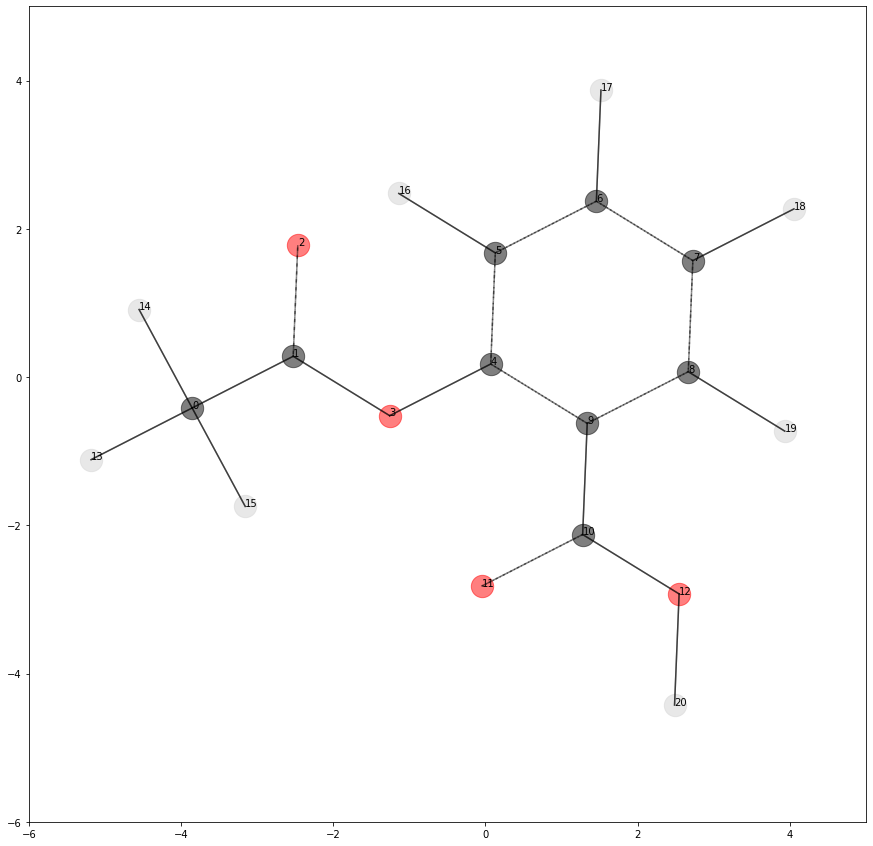

In [42]:

smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
graph = Data(x=x, p=p, edge_index=edge_index, edge_attr = edge_attr)
vis_graph(graph, lower_bound = -6,fig_size=15)

model = GNN_graphpred()

In [6]:
# test of imbalance handling
from torch.utils.data import WeightedRandomSampler


numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print(f'target train 0/1: {len(np.where(target == 0)[0])} {len(np.where(target == 1)[0])}')

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)

train_loader = DataLoader(
    train_dataset, batch_size=bs, num_workers=1, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print(f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")    
     



target train 0/1: 900 100


NameError: name 'DataLoader' is not defined

PredefinedKernelSetConv: there are 15 degree1 trainable kernels
PredefinedKernelSetConv: there are 15 degree2 trainable kernels
PredefinedKernelSetConv: there are 15 degree3 trainable kernels
PredefinedKernelSetConv: there are 15 degree4 trainable kernels
self.num_kernel_list:[15, 15, 15, 15]
['trainable_kernelconv_set.0.x_center', 'trainable_kernelconv_set.0.x_support', 'trainable_kernelconv_set.0.edge_attr_support', 'trainable_kernelconv_set.0.p_support', 'trainable_kernelconv_set.0.length_sc_weight', 'trainable_kernelconv_set.0.angle_sc_weight', 'trainable_kernelconv_set.0.center_attr_sc_weight', 'trainable_kernelconv_set.0.support_attr_sc_weight', 'trainable_kernelconv_set.0.edge_attr_support_sc_weight', 'trainable_kernelconv_set.1.x_center', 'trainable_kernelconv_set.1.x_support', 'trainable_kernelconv_set.1.edge_attr_support', 'trainable_kernelconv_set.1.p_support', 'trainable_kernelconv_set.1.length_sc_weight', 'trainable_kernelconv_set.1.angle_sc_weight', 'trainable_kernelconv_

/home/liuy69/bin/anaconda2/envs/GCN_property/lib/python3.6/site-packages/ipykernel_launcher.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


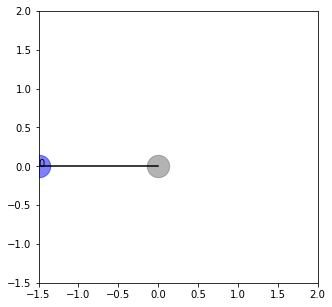

====0th kernel info====
0th-p_support:
torch.Size([1, 2])


0th-x_support:
tensor([[0.6014, 0.4190, 0.3543, 0.2281, 0.4152, 0.2880, 0.1678, 0.3819, 0.7792,
         0.6939, 0.1384, 0.3660, 0.5939, 0.9228, 0.2208, 0.7819, 0.2309, 0.5954,
         0.0845, 0.9575, 0.9230, 0.6295, 0.0586, 0.1003, 0.3321, 0.4668, 0.1087,
         0.7107, 0.7521, 0.1843, 0.1823, 0.3107, 0.0658, 0.4913, 0.8663, 0.4211,
         0.9697, 0.0127, 0.0115, 0.0658, 0.2659, 0.9184, 0.7972, 0.2174, 0.3300,
         0.5275, 0.7370, 0.4484, 0.3062, 0.1579, 0.5387, 0.2424, 0.7939, 0.7617,
         0.7620, 0.6165, 0.6844, 0.9116, 0.4813, 0.4767]])


0th-x_center:
tensor([[0.1107, 0.7917, 0.3098, 0.1835, 0.5613, 0.4677, 0.2382, 0.4120, 0.3855,
         0.3458, 0.0797, 0.9257, 0.2377, 0.0701, 0.3004, 0.5751, 0.9767, 0.7917,
         0.4698, 0.4495, 0.7597, 0.6458, 0.7083, 0.4611, 0.1719, 0.7515, 0.2971,
         0.6354, 0.1976, 0.8833, 0.8599, 0.6226, 0.4624, 0.4954, 0.6036, 0.8670,
         0.3619, 0.1103, 0.9040, 0.7527,

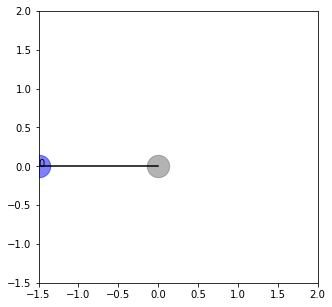

====1th kernel info====
1th-p_support:
torch.Size([1, 2])


1th-x_support:
tensor([[0.4567, 0.2481, 0.7981, 0.5109, 0.8919, 0.2463, 0.9343, 0.2324, 0.3404,
         0.6291, 0.8383, 0.2082, 0.1808, 0.2300, 0.3102, 0.8451, 0.1525, 0.7582,
         0.9334, 0.0216, 0.5701, 0.3743, 0.7146, 0.4586, 0.0550, 0.2302, 0.0448,
         0.9159, 0.3998, 0.1255, 0.8215, 0.3267, 0.8189, 0.4875, 0.0898, 0.9472,
         0.3243, 0.8592, 0.0541, 0.5878, 0.9664, 0.6340, 0.6983, 0.2734, 0.1523,
         0.6476, 0.6871, 0.2992, 0.3409, 0.3055, 0.0787, 0.6206, 0.3713, 0.3723,
         0.0876, 0.3207, 0.5107, 0.8127, 0.9414, 0.7707]])


1th-x_center:
tensor([[0.9342, 0.9829, 0.2492, 0.5951, 0.7896, 0.1662, 0.7691, 0.1635, 0.3012,
         0.7286, 0.2363, 0.3244, 0.0427, 0.2028, 0.6051, 0.0159, 0.0379, 0.9714,
         0.0556, 0.3006, 0.4533, 0.0676, 0.8407, 0.3118, 0.1456, 0.5032, 0.2494,
         0.7375, 0.3249, 0.2598, 0.9383, 0.7144, 0.2841, 0.6413, 0.1249, 0.6192,
         0.5987, 0.7241, 0.7499, 0.7347,

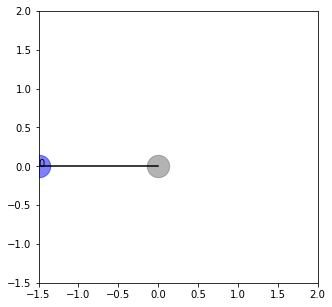

====2th kernel info====
2th-p_support:
torch.Size([1, 2])


2th-x_support:
tensor([[0.9333, 0.0420, 0.7655, 0.0379, 0.0441, 0.9165, 0.7653, 0.4176, 0.0960,
         0.0501, 0.2165, 0.1488, 0.8311, 0.5244, 0.5573, 0.5379, 0.2071, 0.2810,
         0.9738, 0.3907, 0.1146, 0.9383, 0.5549, 0.1139, 0.9669, 0.4731, 0.5357,
         0.3523, 0.5274, 0.6851, 0.9326, 0.9310, 0.0457, 0.3505, 0.0352, 0.5912,
         0.3341, 0.4003, 0.5568, 0.7587, 0.3802, 0.1761, 0.0343, 0.4792, 0.1561,
         0.4883, 0.8241, 0.7240, 0.9835, 0.1123, 0.6688, 0.8648, 0.4474, 0.6323,
         0.4581, 0.3517, 0.2827, 0.4661, 0.2233, 0.7244]])


2th-x_center:
tensor([[0.0754, 0.0911, 0.2495, 0.9773, 0.9737, 0.3453, 0.0213, 0.7155, 0.2232,
         0.6886, 0.6112, 0.2539, 0.7621, 0.0684, 0.7130, 0.4704, 0.3332, 0.4972,
         0.7565, 0.3579, 0.9494, 0.8941, 0.3923, 0.7975, 0.1737, 0.5149, 0.6496,
         0.9807, 0.4096, 0.0174, 0.7838, 0.1203, 0.4105, 0.8454, 0.0744, 0.6696,
         0.5364, 0.3647, 0.9485, 0.4326,

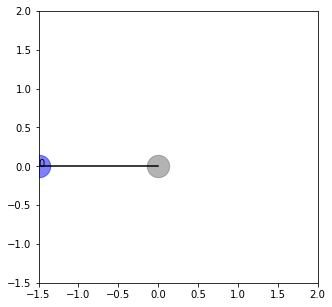

====3th kernel info====
3th-p_support:
torch.Size([1, 2])


3th-x_support:
tensor([[0.1609, 0.4157, 0.3712, 0.5475, 0.6733, 0.0126, 0.1035, 0.2626, 0.0576,
         0.9539, 0.9553, 0.2901, 0.3212, 0.6582, 0.9968, 0.2958, 0.9926, 0.5073,
         0.7444, 0.0365, 0.5636, 0.9184, 0.8429, 0.5680, 0.4960, 0.6311, 0.2369,
         0.5100, 0.1351, 0.3775, 0.3917, 0.0132, 0.7983, 0.7719, 0.2487, 0.2198,
         0.6713, 0.0275, 0.5803, 0.2910, 0.3129, 0.6151, 0.6185, 0.2260, 0.0178,
         0.6916, 0.7139, 0.1064, 0.9916, 0.5664, 0.6438, 0.3141, 0.2715, 0.7546,
         0.1526, 0.6192, 0.6932, 0.3592, 0.5219, 0.7984]])


3th-x_center:
tensor([[0.7811, 0.9594, 0.2219, 0.7686, 0.6037, 0.9523, 0.5204, 0.5984, 0.6288,
         0.5697, 0.1032, 0.2553, 0.9769, 0.6076, 0.2044, 0.4615, 0.0794, 0.3875,
         0.2634, 0.0353, 0.4348, 0.5269, 0.7232, 0.4494, 0.0684, 0.5612, 0.7629,
         0.8932, 0.0840, 0.3043, 0.4311, 0.3511, 0.6076, 0.3654, 0.4022, 0.9969,
         0.2489, 0.7505, 0.5038, 0.9161,

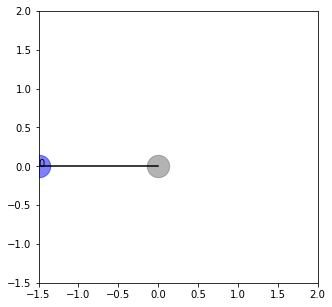

====4th kernel info====
4th-p_support:
torch.Size([1, 2])


4th-x_support:
tensor([[0.8683, 0.2347, 0.0768, 0.3670, 0.2264, 0.0737, 0.8356, 0.1099, 0.5330,
         0.6955, 0.3803, 0.3806, 0.5872, 0.1218, 0.2636, 0.1215, 0.7622, 0.6695,
         0.4088, 0.3832, 0.0245, 0.4542, 0.7825, 0.0925, 0.5014, 0.8333, 0.1241,
         0.1019, 0.5802, 0.7996, 0.1252, 0.3153, 0.9480, 0.9564, 0.6765, 0.1430,
         0.3038, 0.4862, 0.5602, 0.6691, 0.2114, 0.0634, 0.0453, 0.2618, 0.2809,
         0.1980, 0.0698, 0.1036, 0.9439, 0.9994, 0.5624, 0.1036, 0.0097, 0.9833,
         0.9216, 0.6974, 0.2315, 0.3149, 0.1158, 0.8739]])


4th-x_center:
tensor([[0.1568, 0.3368, 0.4523, 0.3273, 0.4042, 0.0042, 0.1274, 0.0374, 0.2245,
         0.9539, 0.0390, 0.3822, 0.4681, 0.8531, 0.9756, 0.1021, 0.3594, 0.6593,
         0.5187, 0.7366, 0.8261, 0.1023, 0.5166, 0.6290, 0.7722, 0.5068, 0.9082,
         0.3368, 0.4128, 0.4314, 0.7096, 0.8010, 0.8498, 0.2175, 0.1271, 0.5272,
         0.2939, 0.2754, 0.6349, 0.0336,

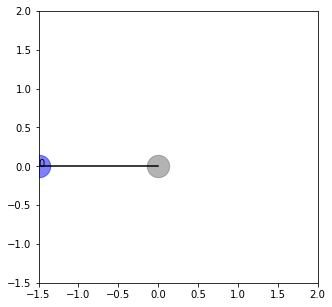

====5th kernel info====
5th-p_support:
torch.Size([1, 2])


5th-x_support:
tensor([[0.3966, 0.0876, 0.8365, 0.0812, 0.9965, 0.6026, 0.6440, 0.2953, 0.7868,
         0.1657, 0.2259, 0.0375, 0.9310, 0.0213, 0.2809, 0.2906, 0.5211, 0.4639,
         0.3003, 0.5614, 0.7749, 0.6361, 0.8163, 0.5909, 0.5088, 0.5168, 0.4673,
         0.8982, 0.2465, 0.8081, 0.0254, 0.0536, 0.8920, 0.7979, 0.0039, 0.0718,
         0.4863, 0.9558, 0.8616, 0.6538, 0.3132, 0.9075, 0.5955, 0.8089, 0.8159,
         0.9342, 0.4442, 0.1033, 0.9316, 0.0739, 0.1066, 0.7035, 0.4231, 0.0521,
         0.0365, 0.6161, 0.1702, 0.0928, 0.2866, 0.0861]])


5th-x_center:
tensor([[0.6685, 0.3097, 0.4504, 0.5023, 0.4141, 0.5725, 0.2749, 0.0478, 0.9993,
         0.3864, 0.1001, 0.6606, 0.5033, 0.5266, 0.0692, 0.1979, 0.2627, 0.8072,
         0.7629, 0.3897, 0.3147, 0.1251, 0.7646, 0.4577, 0.6614, 0.4724, 0.2688,
         0.0547, 0.7256, 0.0273, 0.2148, 0.9931, 0.4497, 0.2583, 0.6274, 0.6134,
         0.9696, 0.4498, 0.6043, 0.2297,

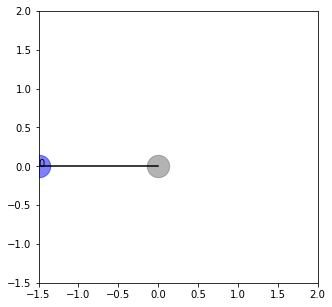

====6th kernel info====
6th-p_support:
torch.Size([1, 2])


6th-x_support:
tensor([[0.2608, 0.0782, 0.9254, 0.2414, 0.5765, 0.7910, 0.8945, 0.4816, 0.6090,
         0.4403, 0.0334, 0.0059, 0.3638, 0.6411, 0.4777, 0.2290, 0.3194, 0.6075,
         0.1184, 0.7171, 0.3886, 0.3390, 0.3932, 0.8115, 0.5573, 0.1880, 0.8769,
         0.7501, 0.3931, 0.4006, 0.8196, 0.5351, 0.5960, 0.0156, 0.9387, 0.6626,
         0.6284, 0.3277, 0.4860, 0.8470, 0.2308, 0.7173, 0.2505, 0.1323, 0.6956,
         0.9822, 0.7243, 0.9856, 0.3975, 0.7474, 0.9649, 0.3621, 0.1261, 0.8338,
         0.6484, 0.3293, 0.6211, 0.1736, 0.9849, 0.0071]])


6th-x_center:
tensor([[0.9717, 0.3567, 0.8492, 0.4229, 0.2793, 0.2324, 0.6656, 0.5190, 0.6636,
         0.7304, 0.9849, 0.9256, 0.3740, 0.1618, 0.5675, 0.1089, 0.7762, 0.0265,
         0.2111, 0.2341, 0.2438, 0.0013, 0.9368, 0.0554, 0.6172, 0.7970, 0.5836,
         0.3847, 0.4042, 0.3480, 0.7193, 0.7176, 0.9572, 0.6134, 0.6476, 0.4564,
         0.1038, 0.4544, 0.9615, 0.8691,

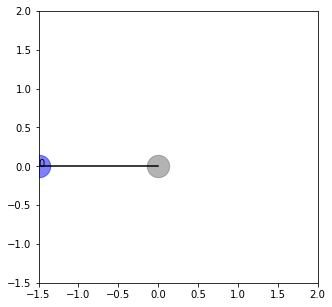

====7th kernel info====
7th-p_support:
torch.Size([1, 2])


7th-x_support:
tensor([[0.5263, 0.9840, 0.8219, 0.1216, 0.3844, 0.6381, 0.6274, 0.7178, 0.8285,
         0.1555, 0.4135, 0.7646, 0.6903, 0.4364, 0.2387, 0.5067, 0.3169, 0.6257,
         0.5911, 0.4138, 0.4624, 0.2739, 0.8366, 0.1473, 0.7816, 0.6664, 0.7130,
         0.7342, 0.6586, 0.9775, 0.1399, 0.8997, 0.1492, 0.8869, 0.8050, 0.8050,
         0.9115, 0.1748, 0.8881, 0.2404, 0.5832, 0.6050, 0.6246, 0.3209, 0.8601,
         0.9363, 0.3130, 0.9070, 0.4145, 0.2573, 0.3013, 0.5202, 0.7601, 0.2483,
         0.9218, 0.6298, 0.7667, 0.7296, 0.4350, 0.1130]])


7th-x_center:
tensor([[0.6668, 0.7838, 0.7963, 0.1111, 0.7707, 0.0554, 0.8180, 0.4241, 0.4153,
         0.8461, 0.4597, 0.5618, 0.7878, 0.9679, 0.7470, 0.6268, 0.0819, 0.9476,
         0.8554, 0.0012, 0.6726, 0.5560, 0.1399, 0.7638, 0.5309, 0.3030, 0.9715,
         0.8322, 0.6245, 0.7642, 0.6866, 0.8897, 0.7089, 0.5607, 0.4049, 0.1279,
         0.6739, 0.2181, 0.0614, 0.6653,

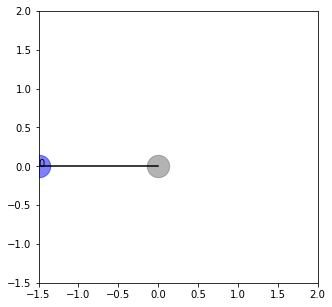

====8th kernel info====
8th-p_support:
torch.Size([1, 2])


8th-x_support:
tensor([[0.2549, 0.4514, 0.6822, 0.0735, 0.4795, 0.2166, 0.3915, 0.9224, 0.0118,
         0.7105, 0.4257, 0.9613, 0.3929, 0.6529, 0.8628, 0.1041, 0.1603, 0.9481,
         0.2917, 0.8502, 0.2053, 0.0306, 0.0144, 0.0430, 0.3979, 0.2492, 0.7431,
         0.5082, 0.1462, 0.9640, 0.6283, 0.9942, 0.5586, 0.5113, 0.2232, 0.9091,
         0.8645, 0.7994, 0.0393, 0.4717, 0.7161, 0.5248, 0.0832, 0.6367, 0.2295,
         0.4268, 0.3531, 0.9197, 0.5448, 0.1493, 0.0027, 0.1337, 0.0641, 0.4492,
         0.0225, 0.2949, 0.5448, 0.2534, 0.6734, 0.4369]])


8th-x_center:
tensor([[0.9720, 0.1161, 0.3091, 0.9711, 0.2208, 0.4261, 0.0243, 0.7075, 0.0245,
         0.5619, 0.4789, 0.8409, 0.3173, 0.3477, 0.6748, 0.7817, 0.0558, 0.6403,
         0.3887, 0.8888, 0.7800, 0.5306, 0.9291, 0.0521, 0.9223, 0.5771, 0.6881,
         0.0158, 0.7297, 0.9545, 0.9537, 0.4680, 0.1162, 0.1786, 0.7245, 0.3968,
         0.7248, 0.2164, 0.1903, 0.5087,

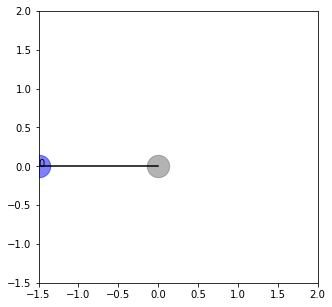

====9th kernel info====
9th-p_support:
torch.Size([1, 2])


9th-x_support:
tensor([[0.3738, 0.9099, 0.0643, 0.0189, 0.0996, 0.3910, 0.5803, 0.0043, 0.6858,
         0.2874, 0.7888, 0.3313, 0.0275, 0.3292, 0.6559, 0.4898, 0.2993, 0.5801,
         0.4129, 0.6933, 0.5157, 0.5863, 0.2957, 0.1190, 0.0061, 0.8181, 0.6542,
         0.9643, 0.4079, 0.5731, 0.7051, 0.0987, 0.7188, 0.1951, 0.3299, 0.1624,
         0.3314, 0.1598, 0.2445, 0.1626, 0.6607, 0.9796, 0.9354, 0.3244, 0.8375,
         0.1931, 0.4560, 0.4451, 0.3042, 0.3498, 0.2710, 0.0573, 0.6994, 0.7131,
         0.4969, 0.4046, 0.9384, 0.7462, 0.6764, 0.5958]])


9th-x_center:
tensor([[0.7165, 0.4901, 0.6982, 0.7620, 0.2093, 0.3956, 0.0662, 0.6247, 0.7307,
         0.3535, 0.0914, 0.7094, 0.0183, 0.3634, 0.0808, 0.5133, 0.6184, 0.6886,
         0.7686, 0.7100, 0.1288, 0.8771, 0.2080, 0.0477, 0.2098, 0.0107, 0.4518,
         0.1290, 0.3222, 0.1535, 0.6542, 0.2309, 0.7054, 0.1904, 0.2717, 0.1423,
         0.8193, 0.2747, 0.9958, 0.3309,

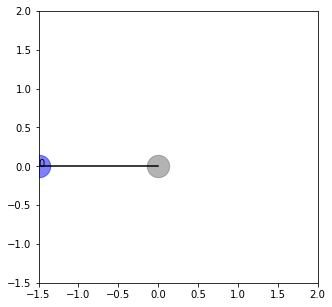

====10th kernel info====
10th-p_support:
torch.Size([1, 2])


10th-x_support:
tensor([[8.7405e-01, 3.2514e-01, 8.6798e-01, 1.0408e-01, 9.9732e-01, 5.6234e-04,
         5.6999e-01, 8.9220e-01, 3.5665e-01, 5.3061e-01, 4.6475e-01, 9.4859e-01,
         7.9799e-01, 1.0903e-01, 3.4863e-01, 9.2837e-01, 1.6789e-01, 1.1629e-01,
         2.0511e-01, 3.7892e-01, 5.2169e-01, 7.7685e-01, 6.0788e-02, 9.1541e-01,
         1.9576e-01, 4.5851e-01, 6.8076e-01, 7.0348e-02, 6.7162e-01, 6.3562e-01,
         8.8812e-01, 5.8671e-01, 7.2152e-01, 7.0325e-03, 9.8839e-01, 4.9584e-01,
         3.9042e-01, 1.0583e-01, 1.1683e-01, 2.4642e-01, 8.3710e-01, 6.0430e-01,
         6.3905e-01, 5.7732e-01, 8.6030e-01, 5.9439e-01, 4.6654e-01, 6.3340e-01,
         9.2902e-01, 6.9593e-01, 9.3504e-01, 9.1237e-01, 8.5630e-01, 2.2033e-01,
         5.2087e-01, 4.8575e-01, 5.4100e-01, 5.1905e-01, 3.5277e-01, 8.2873e-01]])


10th-x_center:
tensor([[0.0467, 0.1065, 0.1158, 0.3296, 0.1592, 0.3246, 0.5065, 0.4354, 0.1816,
         0.4

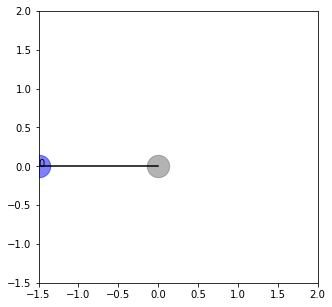

====11th kernel info====
11th-p_support:
torch.Size([1, 2])


11th-x_support:
tensor([[0.6060, 0.7828, 0.9661, 0.3639, 0.8551, 0.4504, 0.7563, 0.9219, 0.4969,
         0.4166, 0.9862, 0.5522, 0.3784, 0.5262, 0.9960, 0.2181, 0.3066, 0.0389,
         0.8410, 0.6934, 0.0568, 0.4429, 0.6699, 0.8064, 0.8402, 0.4657, 0.3879,
         0.8802, 0.6861, 0.8599, 0.3163, 0.0255, 0.6264, 0.4919, 0.5346, 0.3879,
         0.1567, 0.1907, 0.7155, 0.5010, 0.2825, 0.2363, 0.1891, 0.5816, 0.6040,
         0.1299, 0.5543, 0.6821, 0.0432, 0.1873, 0.0870, 0.9997, 0.1382, 0.8214,
         0.8012, 0.3151, 0.1586, 0.2379, 0.6944, 0.7109]])


11th-x_center:
tensor([[0.5134, 0.7339, 0.9632, 0.5608, 0.6148, 0.3966, 0.6520, 0.5461, 0.7670,
         0.7759, 0.9692, 0.4674, 0.6967, 0.0511, 0.9094, 0.5685, 0.6450, 0.4703,
         0.4964, 0.2846, 0.5824, 0.6117, 0.7830, 0.7280, 0.8239, 0.7818, 0.3126,
         0.6840, 0.6426, 0.2527, 0.8000, 0.2771, 0.8500, 0.0432, 0.4030, 0.9056,
         0.1704, 0.4260, 0.3856, 0.7

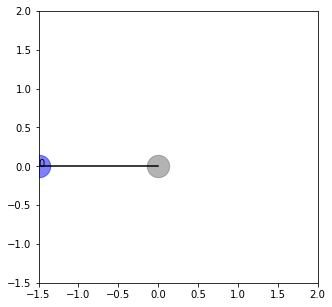

====12th kernel info====
12th-p_support:
torch.Size([1, 2])


12th-x_support:
tensor([[0.3238, 0.9396, 0.5806, 0.0511, 0.9695, 0.2122, 0.3328, 0.0066, 0.4984,
         0.7682, 0.6057, 0.6722, 0.9229, 0.2164, 0.6462, 0.4882, 0.8578, 0.1917,
         0.7232, 0.0617, 0.6784, 0.4111, 0.0292, 0.1779, 0.7418, 0.2442, 0.5656,
         0.7209, 0.9831, 0.8351, 0.9480, 0.4241, 0.9291, 0.0174, 0.9469, 0.1838,
         0.0621, 0.4441, 0.9489, 0.6765, 0.4004, 0.4579, 0.6055, 0.4317, 0.9386,
         0.4622, 0.9177, 0.0671, 0.3408, 0.1078, 0.0387, 0.2072, 0.8483, 0.2529,
         0.6116, 0.4571, 0.5991, 0.8940, 0.9124, 0.3824]])


12th-x_center:
tensor([[0.8089, 0.2847, 0.4505, 0.2625, 0.6900, 0.1884, 0.9686, 0.2457, 0.4821,
         0.0748, 0.4239, 0.6124, 0.8862, 0.5852, 0.7104, 0.3140, 0.3447, 0.4515,
         0.9886, 0.9132, 0.1488, 0.0410, 0.1135, 0.2515, 0.1946, 0.9744, 0.2655,
         0.9333, 0.3605, 0.2741, 0.4701, 0.3916, 0.7660, 0.1078, 0.5637, 0.9272,
         0.5971, 0.9566, 0.1475, 0.6

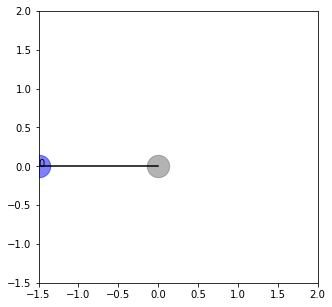

====13th kernel info====
13th-p_support:
torch.Size([1, 2])


13th-x_support:
tensor([[0.8219, 0.6467, 0.8861, 0.9508, 0.4400, 0.6948, 0.2571, 0.8166, 0.3426,
         0.3618, 0.2175, 0.5501, 0.6949, 0.4693, 0.5475, 0.5363, 0.0141, 0.0036,
         0.6969, 0.6060, 0.4166, 0.4786, 0.4581, 0.8675, 0.9940, 0.0864, 0.9049,
         0.5139, 0.6067, 0.9535, 0.1532, 0.3063, 0.3989, 0.0613, 0.5987, 0.5126,
         0.9889, 0.8936, 0.6870, 0.0712, 0.6439, 0.3777, 0.1195, 0.0268, 0.3416,
         0.8657, 0.0745, 0.5159, 0.4242, 0.3347, 0.7286, 0.3978, 0.5153, 0.7949,
         0.0743, 0.8393, 0.6413, 0.3780, 0.9995, 0.9694]])


13th-x_center:
tensor([[0.7281, 0.5512, 0.1936, 0.2377, 0.6863, 0.2312, 0.7347, 0.8552, 0.0726,
         0.5963, 0.5780, 0.3779, 0.6488, 0.1467, 0.0024, 0.3372, 0.0249, 0.0850,
         0.1733, 0.4179, 0.8659, 0.8977, 0.1259, 0.1453, 0.2332, 0.4633, 0.7486,
         0.1818, 0.7794, 0.3156, 0.6204, 0.3242, 0.7353, 0.5354, 0.4449, 0.1665,
         0.5475, 0.1453, 0.4002, 0.1

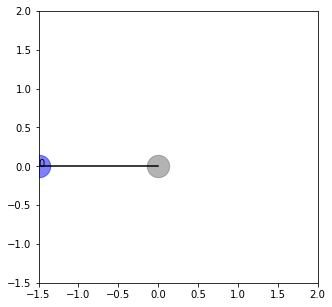

====14th kernel info====
14th-p_support:
torch.Size([1, 2])


14th-x_support:
tensor([[0.1766, 0.3722, 0.1486, 0.6651, 0.5653, 0.1635, 0.7626, 0.6267, 0.7033,
         0.6178, 0.0328, 0.0120, 0.6746, 0.6201, 0.8857, 0.3645, 0.6244, 0.6030,
         0.2690, 0.4607, 0.6928, 0.6636, 0.9371, 0.6400, 0.8682, 0.4223, 0.5950,
         0.7485, 0.4513, 0.3092, 0.8314, 0.1670, 0.1513, 0.6631, 0.6805, 0.7636,
         0.2579, 0.6484, 0.0562, 0.0834, 0.2842, 0.3492, 0.7188, 0.4408, 0.0393,
         0.7933, 0.6799, 0.3664, 0.9005, 0.9954, 0.2384, 0.9374, 0.9833, 0.7674,
         0.8684, 0.7894, 0.7962, 0.3955, 0.5734, 0.7834]])


14th-x_center:
tensor([[0.5772, 0.3677, 0.0641, 0.4662, 0.5237, 0.8976, 0.8801, 0.7610, 0.9967,
         0.1335, 0.6847, 0.2382, 0.3731, 0.6857, 0.0832, 0.3989, 0.0180, 0.5768,
         0.0856, 0.6168, 0.6809, 0.5562, 0.5223, 0.0028, 0.7025, 0.4713, 0.6921,
         0.7794, 0.6852, 0.4859, 0.8984, 0.3670, 0.0394, 0.4673, 0.1035, 0.9491,
         0.4713, 0.2852, 0.2850, 0.2

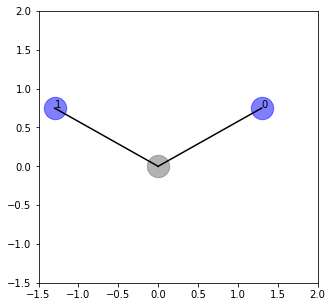

====0th kernel info====
0th-p_support:
torch.Size([2, 2])


0th-x_support:
tensor([[0.6660, 0.0523, 0.6591, 0.7232, 0.1986, 0.2750, 0.9370, 0.5319, 0.8776,
         0.0399, 0.1562, 0.6566, 0.4186, 0.1549, 0.6162, 0.9483, 0.6627, 0.1343,
         0.3349, 0.3319, 0.5466, 0.1640, 0.5744, 0.8697, 0.9272, 0.9214, 0.5481,
         0.1020, 0.6098, 0.9684, 0.8539, 0.8044, 0.4705, 0.6831, 0.6089, 0.5398,
         0.4469, 0.3866, 0.2947, 0.5839, 0.9355, 0.9584, 0.4818, 0.5476, 0.2521,
         0.4744, 0.7944, 0.1802, 0.2623, 0.0785, 0.1832, 0.3359, 0.0474, 0.2714,
         0.8006, 0.6215, 0.8971, 0.4238, 0.8643, 0.8389],
        [0.6197, 0.5034, 0.6491, 0.4550, 0.9932, 0.5247, 0.9407, 0.3306, 0.2788,
         0.5127, 0.8835, 0.7585, 0.9665, 0.2356, 0.0043, 0.9181, 0.9262, 0.1362,
         0.9356, 0.9911, 0.9837, 0.4159, 0.8905, 0.0033, 0.3283, 0.6021, 0.1820,
         0.4537, 0.6635, 0.0640, 0.6983, 0.2088, 0.3769, 0.2492, 0.6028, 0.1109,
         0.8403, 0.8415, 0.5280, 0.7876, 0.4785, 0.2424, 

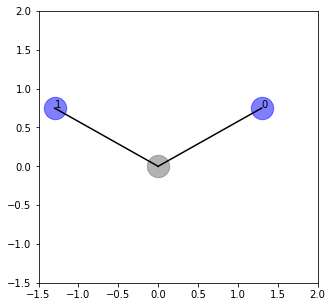

====1th kernel info====
1th-p_support:
torch.Size([2, 2])


1th-x_support:
tensor([[0.9523, 0.2725, 0.5893, 0.7148, 0.5260, 0.3102, 0.5369, 0.8906, 0.9935,
         0.8407, 0.9901, 0.4490, 0.0360, 0.1541, 0.2425, 0.6698, 0.8397, 0.1676,
         0.6169, 0.5555, 0.9046, 0.0912, 0.7336, 0.8649, 0.2096, 0.1593, 0.0168,
         0.8675, 0.9446, 0.5230, 0.9802, 0.1268, 0.4425, 0.8727, 0.4805, 0.3892,
         0.4275, 0.5416, 0.6634, 0.3379, 0.4712, 0.5292, 0.7388, 0.9816, 0.7224,
         0.1495, 0.5058, 0.9128, 0.4488, 0.2265, 0.2686, 0.9699, 0.9566, 0.0073,
         0.1820, 0.5369, 0.8239, 0.2660, 0.6333, 0.8133],
        [0.7544, 0.9786, 0.6366, 0.3683, 0.2427, 0.8907, 0.1735, 0.9540, 0.1291,
         0.8042, 0.8392, 0.4997, 0.7138, 0.0366, 0.2547, 0.2130, 0.5307, 0.7057,
         0.4698, 0.0609, 0.1258, 0.4623, 0.7455, 0.6692, 0.1266, 0.5508, 0.8158,
         0.8101, 0.9228, 0.0226, 0.7092, 0.7887, 0.0418, 0.7268, 0.1524, 0.3422,
         0.2904, 0.4105, 0.6036, 0.7897, 0.6839, 0.9811, 

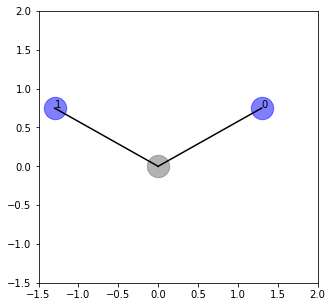

====2th kernel info====
2th-p_support:
torch.Size([2, 2])


2th-x_support:
tensor([[0.8186, 0.2067, 0.2802, 0.8081, 0.3261, 0.4584, 0.1293, 0.6559, 0.4910,
         0.5115, 0.4608, 0.9980, 0.9260, 0.3658, 0.4315, 0.6210, 0.4627, 0.9165,
         0.6678, 0.2958, 0.9607, 0.3406, 0.3433, 0.5700, 0.9763, 0.0254, 0.3426,
         0.8966, 0.2400, 0.6292, 0.1340, 0.7101, 0.0830, 0.1147, 0.5139, 0.8753,
         0.9571, 0.2862, 0.0743, 0.2243, 0.3450, 0.1605, 0.3129, 0.7391, 0.6628,
         0.3670, 0.8090, 0.0617, 0.4531, 0.6687, 0.5296, 0.9765, 0.1640, 0.7593,
         0.3944, 0.3133, 0.8737, 0.6103, 0.7098, 0.0925],
        [0.8322, 0.3743, 0.2954, 0.2959, 0.1489, 0.8038, 0.0404, 0.8068, 0.1355,
         0.6307, 0.7650, 0.8817, 0.4632, 0.0257, 0.7307, 0.5469, 0.3002, 0.0567,
         0.8225, 0.3624, 0.8582, 0.1723, 0.9372, 0.7858, 0.7378, 0.2845, 0.9913,
         0.0096, 0.7022, 0.5827, 0.9987, 0.4365, 0.2896, 0.8355, 0.7860, 0.5759,
         0.0903, 0.7972, 0.0885, 0.5517, 0.0388, 0.7184, 

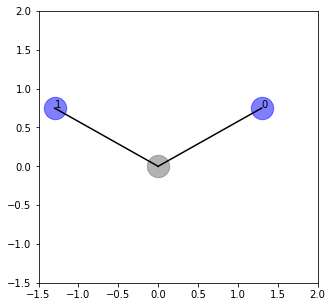

====3th kernel info====
3th-p_support:
torch.Size([2, 2])


3th-x_support:
tensor([[0.0538, 0.3004, 0.9258, 0.8800, 0.9905, 0.9113, 0.0851, 0.8583, 0.2177,
         0.5479, 0.5632, 0.6184, 0.8879, 0.7932, 0.4791, 0.0358, 0.8131, 0.0302,
         0.2392, 0.2059, 0.1589, 0.7634, 0.9861, 0.2724, 0.7990, 0.5924, 0.4299,
         0.9581, 0.0766, 0.8944, 0.4747, 0.3908, 0.0580, 0.7156, 0.4538, 0.7511,
         0.1535, 0.7075, 0.6530, 0.1520, 0.0752, 0.3773, 0.7464, 0.1177, 0.0261,
         0.1958, 0.4975, 0.6425, 0.7281, 0.0928, 0.9724, 0.6718, 0.9766, 0.0549,
         0.7705, 0.6900, 0.4395, 0.8469, 0.0310, 0.1880],
        [0.8569, 0.6121, 0.8597, 0.2058, 0.4245, 0.8696, 0.0227, 0.3454, 0.6075,
         0.4026, 0.5972, 0.8373, 0.3969, 0.6864, 0.2456, 0.7157, 0.9868, 0.2478,
         0.6900, 0.0593, 0.4932, 0.7422, 0.3183, 0.8188, 0.7814, 0.5800, 0.8666,
         0.0657, 0.6560, 0.5594, 0.1979, 0.1826, 0.2982, 0.8444, 0.7991, 0.4062,
         0.8896, 0.7783, 0.2932, 0.8817, 0.5417, 0.5261, 

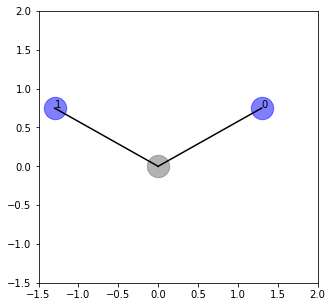

====4th kernel info====
4th-p_support:
torch.Size([2, 2])


4th-x_support:
tensor([[0.3867, 0.0310, 0.1982, 0.3751, 0.0893, 0.6076, 0.3997, 0.7483, 0.7827,
         0.3417, 0.7093, 0.2696, 0.9713, 0.9098, 0.1754, 0.3982, 0.9698, 0.3798,
         0.7531, 0.9249, 0.9431, 0.9710, 0.9917, 0.4998, 0.0895, 0.2669, 0.0273,
         0.2901, 0.7993, 0.2727, 0.6860, 0.2808, 0.3380, 0.5666, 0.6746, 0.7879,
         0.0287, 0.2309, 0.0069, 0.0862, 0.6010, 0.4137, 0.9794, 0.1522, 0.7754,
         0.9565, 0.9687, 0.3764, 0.5870, 0.9071, 0.6870, 0.6905, 0.6516, 0.7268,
         0.7660, 0.7437, 0.8029, 0.3906, 0.5304, 0.5351],
        [0.6581, 0.8748, 0.9423, 0.3248, 0.6792, 0.4510, 0.9798, 0.5855, 0.2586,
         0.7809, 0.6046, 0.0850, 0.6830, 0.9069, 0.0331, 0.1135, 0.1890, 0.8035,
         0.7907, 0.8561, 0.7536, 0.9472, 0.2405, 0.8162, 0.6284, 0.5620, 0.1888,
         0.7455, 0.4739, 0.4634, 0.0156, 0.4200, 0.8105, 0.9280, 0.3307, 0.6608,
         0.3354, 0.7098, 0.3049, 0.1812, 0.9547, 0.2551, 

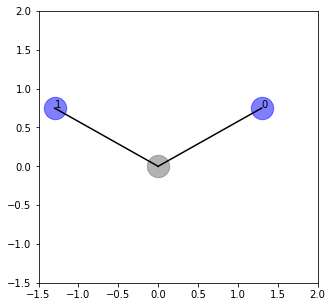

====5th kernel info====
5th-p_support:
torch.Size([2, 2])


5th-x_support:
tensor([[0.8594, 0.6584, 0.5738, 0.5548, 0.6595, 0.0483, 0.1385, 0.8853, 0.3784,
         0.6372, 0.9506, 0.4724, 0.8279, 0.3417, 0.5604, 0.8835, 0.7289, 0.0647,
         0.5247, 0.9879, 0.4687, 0.0375, 0.8901, 0.7904, 0.2776, 0.9324, 0.9360,
         0.4876, 0.5769, 0.1160, 0.4165, 0.0761, 0.9330, 0.2578, 0.3818, 0.6496,
         0.9678, 0.9994, 0.8563, 0.2411, 0.7582, 0.4575, 0.8002, 0.1725, 0.7674,
         0.8732, 0.4895, 0.9596, 0.8133, 0.6705, 0.9172, 0.8580, 0.7654, 0.9701,
         0.1847, 0.4970, 0.7216, 0.4829, 0.2924, 0.6747],
        [0.9713, 0.4956, 0.0047, 0.4688, 0.5605, 0.1210, 0.1470, 0.2423, 0.3343,
         0.0948, 0.0865, 0.6498, 0.7709, 0.8283, 0.5506, 0.1634, 0.1660, 0.4831,
         0.9716, 0.0604, 0.4091, 0.4059, 0.7280, 0.1484, 0.4304, 0.9106, 0.8436,
         0.5493, 0.2150, 0.5711, 0.9975, 0.4594, 0.4099, 0.4025, 0.8253, 0.5296,
         0.9751, 0.7685, 0.0012, 0.0139, 0.6829, 0.7450, 

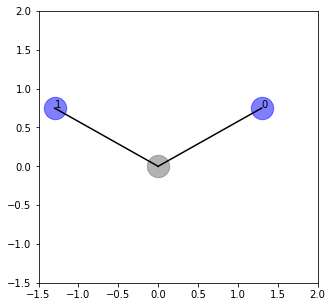

====6th kernel info====
6th-p_support:
torch.Size([2, 2])


6th-x_support:
tensor([[0.8200, 0.7756, 0.0392, 0.3811, 0.3350, 0.4327, 0.3428, 0.6473, 0.2718,
         0.3997, 0.4786, 0.1222, 0.3426, 0.5580, 0.4822, 0.6329, 0.5936, 0.0247,
         0.7201, 0.3582, 0.8383, 0.2099, 0.7233, 0.7671, 0.6005, 0.2089, 0.1360,
         0.4345, 0.2171, 0.2579, 0.1494, 0.9437, 0.6972, 0.1593, 0.9465, 0.5196,
         0.4654, 0.8952, 0.8329, 0.8137, 0.4973, 0.1767, 0.3370, 0.5797, 0.1020,
         0.2331, 0.2294, 0.4715, 0.7668, 0.6990, 0.8853, 0.0069, 0.6929, 0.3122,
         0.6550, 0.2510, 0.8961, 0.2044, 0.4458, 0.2671],
        [0.1911, 0.8869, 0.1967, 0.1238, 0.6267, 0.8872, 0.5146, 0.5334, 0.3671,
         0.6346, 0.9683, 0.1279, 0.6457, 0.8909, 0.6259, 0.0126, 0.4647, 0.4399,
         0.5924, 0.8009, 0.6417, 0.3717, 0.9352, 0.6775, 0.4775, 0.4210, 0.6587,
         0.5404, 0.8936, 0.6525, 0.3862, 0.3695, 0.7060, 0.3072, 0.7279, 0.6912,
         0.0959, 0.4895, 0.6967, 0.7916, 0.4636, 0.6687, 

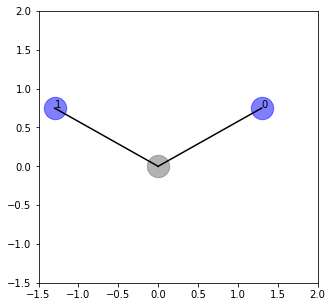

====7th kernel info====
7th-p_support:
torch.Size([2, 2])


7th-x_support:
tensor([[0.0072, 0.5563, 0.3479, 0.7879, 0.2860, 0.3623, 0.7787, 0.6529, 0.1984,
         0.4699, 0.5135, 0.2172, 0.0536, 0.7383, 0.0910, 0.6622, 0.7363, 0.9449,
         0.9400, 0.3802, 0.3760, 0.6829, 0.9730, 0.3509, 0.3905, 0.7947, 0.2049,
         0.7045, 0.1859, 0.9471, 0.2045, 0.9181, 0.4520, 0.5643, 0.5984, 0.0653,
         0.6675, 0.0051, 0.0960, 0.1238, 0.6032, 0.3024, 0.5194, 0.3963, 0.9702,
         0.0229, 0.4424, 0.9762, 0.7459, 0.4134, 0.3042, 0.7555, 0.7735, 0.5576,
         0.5710, 0.6909, 0.6645, 0.5141, 0.6140, 0.6301],
        [0.2794, 0.4843, 0.4307, 0.0583, 0.8161, 0.6709, 0.5995, 0.4956, 0.9185,
         0.2926, 0.9377, 0.7073, 0.6619, 0.6385, 0.5592, 0.0145, 0.3501, 0.4908,
         0.2469, 0.2719, 0.4353, 0.5746, 0.3001, 0.9142, 0.7928, 0.6887, 0.9685,
         0.5396, 0.7681, 0.8822, 0.7442, 0.7864, 0.9448, 0.3256, 0.5012, 0.5726,
         0.6592, 0.3890, 0.3448, 0.9874, 0.5531, 0.4425, 

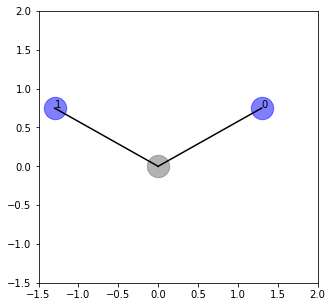

====8th kernel info====
8th-p_support:
torch.Size([2, 2])


8th-x_support:
tensor([[0.3139, 0.6022, 0.2149, 0.3728, 0.8451, 0.4160, 0.7151, 0.4011, 0.1004,
         0.2234, 0.3138, 0.7492, 0.7664, 0.0259, 0.5861, 0.7854, 0.4819, 0.7898,
         0.0116, 0.9915, 0.8843, 0.0686, 0.8556, 0.8106, 0.8562, 0.0947, 0.5420,
         0.9112, 0.5589, 0.3848, 0.9143, 0.8084, 0.5977, 0.6076, 0.7707, 0.1159,
         0.9133, 0.6255, 0.7240, 0.0362, 0.3562, 0.1208, 0.0949, 0.8130, 0.8106,
         0.2226, 0.9287, 0.4118, 0.4380, 0.5017, 0.7950, 0.4925, 0.4830, 0.5363,
         0.6420, 0.6103, 0.1476, 0.8507, 0.7071, 0.7512],
        [0.9477, 0.8496, 0.9072, 0.9542, 0.8475, 0.9892, 0.0173, 0.9184, 0.7020,
         0.6002, 0.0837, 0.9628, 0.2200, 0.8128, 0.0742, 0.1947, 0.5765, 0.1632,
         0.1348, 0.5625, 0.9420, 0.7717, 0.2652, 0.6657, 0.9437, 0.8268, 0.4780,
         0.6762, 0.9356, 0.4712, 0.3632, 0.5557, 0.3854, 0.7163, 0.2549, 0.0069,
         0.3994, 0.0683, 0.9181, 0.9473, 0.1813, 0.4145, 

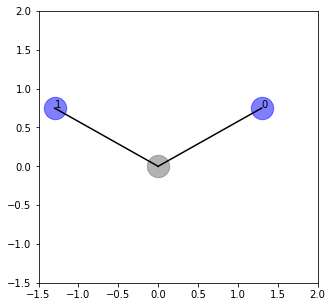

====9th kernel info====
9th-p_support:
torch.Size([2, 2])


9th-x_support:
tensor([[2.7318e-01, 5.6392e-01, 2.6361e-01, 5.6604e-01, 3.5240e-01, 8.2023e-01,
         1.1555e-02, 6.8010e-01, 8.4964e-01, 3.3242e-01, 9.0868e-01, 5.0150e-01,
         4.1397e-01, 1.3170e-01, 9.4466e-01, 2.6228e-01, 3.9837e-01, 5.9412e-01,
         2.2044e-01, 6.1824e-01, 5.4638e-01, 8.3309e-01, 5.7150e-01, 4.0622e-02,
         2.5789e-01, 6.0839e-01, 2.7418e-01, 3.0505e-01, 6.6516e-01, 6.5793e-01,
         2.9036e-01, 3.5909e-01, 9.2991e-01, 9.9681e-01, 4.4306e-01, 4.3108e-01,
         3.1620e-01, 1.9053e-01, 7.6110e-01, 5.3365e-01, 4.5414e-01, 7.5275e-01,
         6.0482e-01, 8.7814e-01, 8.0642e-01, 1.9525e-01, 9.5726e-02, 9.3815e-01,
         9.6719e-01, 4.9537e-01, 5.2444e-01, 6.3001e-01, 1.2346e-01, 9.8923e-01,
         6.7230e-01, 3.7532e-01, 5.1875e-01, 5.8245e-01, 1.4324e-02, 9.6609e-01],
        [9.6193e-01, 3.8742e-01, 6.0875e-01, 4.4599e-01, 3.8808e-01, 1.2096e-01,
         3.9023e-01, 1.3711e-01, 

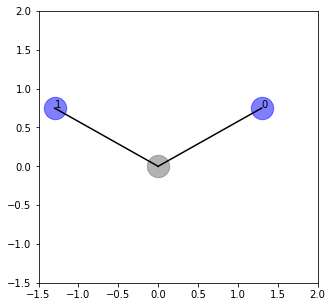

====10th kernel info====
10th-p_support:
torch.Size([2, 2])


10th-x_support:
tensor([[0.5193, 0.6166, 0.8055, 0.8108, 0.6793, 0.3616, 0.4735, 0.9724, 0.7763,
         0.8709, 0.8668, 0.4170, 0.7672, 0.3005, 0.5227, 0.5332, 0.1954, 0.7572,
         0.4940, 0.6265, 0.3146, 0.2954, 0.1857, 0.6394, 0.2026, 0.1168, 0.8990,
         0.9700, 0.6796, 0.7572, 0.5535, 0.3311, 0.9849, 0.2518, 0.3655, 0.5540,
         0.5273, 0.5108, 0.4717, 0.0071, 0.2620, 0.3967, 0.4351, 0.9151, 0.7086,
         0.5323, 0.5403, 0.9699, 0.2992, 0.7068, 0.8278, 0.4467, 0.7230, 0.1294,
         0.6258, 0.3134, 0.0723, 0.8420, 0.2151, 0.9113],
        [0.5554, 0.6042, 0.1027, 0.7771, 0.7093, 0.3961, 0.0953, 0.6548, 0.4808,
         0.2955, 0.8985, 0.0822, 0.7904, 0.2633, 0.0038, 0.8190, 0.0152, 0.3877,
         0.2774, 0.2862, 0.1423, 0.7885, 0.5975, 0.9314, 0.3525, 0.4614, 0.2712,
         0.2047, 0.0691, 0.7957, 0.8502, 0.0967, 0.1225, 0.8513, 0.2268, 0.8187,
         0.8872, 0.7855, 0.9328, 0.1646, 0.4321, 0.615

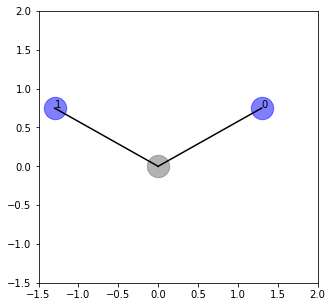

====11th kernel info====
11th-p_support:
torch.Size([2, 2])


11th-x_support:
tensor([[8.5640e-01, 4.1534e-01, 9.5839e-01, 1.6503e-01, 5.5560e-01, 2.6159e-01,
         4.4036e-01, 4.2666e-01, 7.0831e-01, 2.1549e-01, 2.0599e-01, 8.5049e-01,
         9.0631e-01, 7.2192e-01, 3.6015e-01, 5.8623e-01, 8.3853e-01, 5.6992e-01,
         6.6226e-01, 3.6684e-02, 4.0230e-01, 6.6013e-01, 3.9709e-01, 8.8744e-01,
         5.4308e-01, 9.8854e-01, 9.4501e-02, 2.0238e-01, 6.5343e-01, 2.6462e-01,
         9.9848e-01, 5.2105e-01, 7.2700e-01, 5.7828e-01, 9.9967e-01, 9.1572e-02,
         9.6659e-01, 6.5782e-01, 9.8145e-01, 7.9834e-01, 3.5148e-01, 1.5402e-01,
         2.6139e-01, 1.1835e-01, 8.7292e-01, 7.4936e-01, 4.6768e-01, 6.8221e-01,
         4.7384e-01, 7.0752e-01, 3.0693e-01, 7.1032e-01, 9.3797e-01, 7.8928e-01,
         2.5242e-01, 9.4969e-01, 9.4847e-02, 6.8930e-01, 7.2661e-01, 5.7938e-01],
        [9.2572e-01, 7.3811e-01, 8.2027e-01, 8.0649e-01, 7.0975e-01, 5.7272e-01,
         2.5801e-01, 7.3252e-0

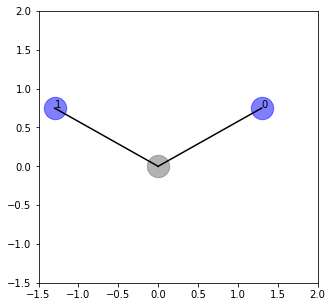

====12th kernel info====
12th-p_support:
torch.Size([2, 2])


12th-x_support:
tensor([[0.4665, 0.4991, 0.6254, 0.1829, 0.8367, 0.4137, 0.8172, 0.5862, 0.5080,
         0.4063, 0.5518, 0.5360, 0.6409, 0.5503, 0.7543, 0.0349, 0.7562, 0.3430,
         0.6050, 0.2005, 0.3468, 0.3785, 0.9682, 0.8620, 0.8179, 0.8306, 0.2933,
         0.2125, 0.6969, 0.1945, 0.8554, 0.2738, 0.8837, 0.0511, 0.3827, 0.1504,
         0.3956, 0.4928, 0.4243, 0.8019, 0.8745, 0.5945, 0.8085, 0.7985, 0.7354,
         0.5182, 0.6558, 0.3872, 0.6190, 0.8193, 0.6330, 0.9724, 0.7446, 0.3489,
         0.8420, 0.8091, 0.2386, 0.8537, 0.9071, 0.8635],
        [0.6478, 0.7169, 0.1297, 0.0235, 0.3645, 0.4427, 0.1697, 0.6475, 0.5592,
         0.2729, 0.8317, 0.5242, 0.3984, 0.8785, 0.6417, 0.2587, 0.8775, 0.2370,
         0.8047, 0.3494, 0.5540, 0.9418, 0.7729, 0.4820, 0.0073, 0.2296, 0.2159,
         0.7294, 0.3719, 0.4029, 0.1885, 0.7216, 0.1209, 0.4071, 0.3798, 0.9760,
         0.5249, 0.6966, 0.2767, 0.7808, 0.4747, 0.458

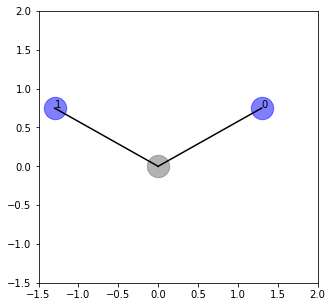

====13th kernel info====
13th-p_support:
torch.Size([2, 2])


13th-x_support:
tensor([[0.4099, 0.1857, 0.4673, 0.7262, 0.8607, 0.4704, 0.4327, 0.4704, 0.4809,
         0.6365, 0.9143, 0.5418, 0.9423, 0.9414, 0.5997, 0.2392, 0.7188, 0.9224,
         0.8627, 0.5700, 0.1274, 0.4920, 0.2536, 0.5982, 0.5882, 0.9654, 0.9600,
         0.1025, 0.7364, 0.2071, 0.9134, 0.4982, 0.9352, 0.4459, 0.3345, 0.6934,
         0.7785, 0.0117, 0.5788, 0.7585, 0.6280, 0.7538, 0.8450, 0.3634, 0.8864,
         0.8187, 0.2673, 0.4960, 0.9656, 0.5277, 0.7614, 0.6807, 0.3014, 0.5309,
         0.2689, 0.9690, 0.8055, 0.2280, 0.5175, 0.7688],
        [0.4624, 0.4329, 0.8661, 0.6599, 0.6901, 0.0072, 0.2911, 0.2623, 0.1293,
         0.1847, 0.0578, 0.0099, 0.1177, 0.4517, 0.8691, 0.5061, 0.7919, 0.7859,
         0.8036, 0.2563, 0.7394, 0.0827, 0.4924, 0.5193, 0.7461, 0.5026, 0.2670,
         0.2611, 0.2672, 0.0416, 0.5620, 0.5725, 0.3155, 0.7424, 0.2156, 0.1999,
         0.1862, 0.6256, 0.4612, 0.8875, 0.4357, 0.844

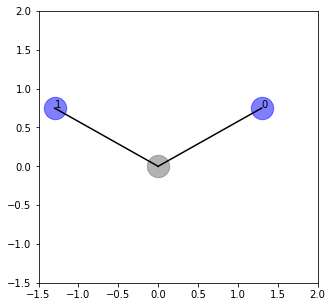

====14th kernel info====
14th-p_support:
torch.Size([2, 2])


14th-x_support:
tensor([[0.1568, 0.1453, 0.6785, 0.7647, 0.8703, 0.4366, 0.2745, 0.1315, 0.3550,
         0.9567, 0.5044, 0.1847, 0.3623, 0.6465, 0.6856, 0.7740, 0.7834, 0.6614,
         0.0793, 0.9053, 0.5917, 0.2437, 0.9369, 0.1239, 0.4232, 0.7267, 0.8306,
         0.3283, 0.3033, 0.7417, 0.4535, 0.1033, 0.7992, 0.0149, 0.7086, 0.2942,
         0.5544, 0.5852, 0.1151, 0.7130, 0.3253, 0.0304, 0.5721, 0.6544, 0.2881,
         0.7118, 0.0411, 0.9175, 0.0268, 0.9328, 0.4130, 0.9303, 0.3467, 0.3523,
         0.6978, 0.7736, 0.2103, 0.8609, 0.5083, 0.0778],
        [0.0620, 0.7566, 0.1341, 0.1525, 0.4386, 0.3297, 0.4470, 0.8364, 0.6276,
         0.9338, 0.2715, 0.5744, 0.1799, 0.2839, 0.7080, 0.1262, 0.5143, 0.1484,
         0.2885, 0.5868, 0.8114, 0.4825, 0.4699, 0.0385, 0.4935, 0.7107, 0.8742,
         0.8927, 0.5998, 0.2842, 0.8321, 0.5692, 0.7372, 0.4618, 0.2652, 0.7196,
         0.8926, 0.4364, 0.1326, 0.6777, 0.3409, 0.421

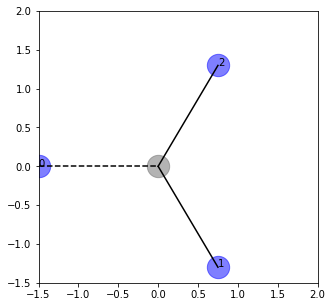

====0th kernel info====
0th-p_support:
torch.Size([3, 2])


0th-x_support:
tensor([[0.0686, 0.6800, 0.0360, 0.5758, 0.9635, 0.5177, 0.5062, 0.3503, 0.6792,
         0.9795, 0.0334, 0.3718, 0.7625, 0.1969, 0.0783, 0.1080, 0.8412, 0.1732,
         0.1618, 0.2850, 0.0330, 0.7082, 0.6860, 0.7336, 0.7076, 0.9404, 0.4334,
         0.4998, 0.0426, 0.9096, 0.6657, 0.8895, 0.5433, 0.6363, 0.5188, 0.9436,
         0.9943, 0.0628, 0.5323, 0.2113, 0.2972, 0.9526, 0.4498, 0.0993, 0.7559,
         0.7729, 0.4323, 0.2485, 0.8820, 0.8807, 0.8044, 0.7391, 0.5437, 0.2990,
         0.6994, 0.1856, 0.1863, 0.7659, 0.4350, 0.4807],
        [0.1489, 0.8162, 0.3070, 0.8482, 0.2577, 0.6482, 0.1941, 0.6842, 0.1665,
         0.4949, 0.8204, 0.4065, 0.4423, 0.7849, 0.3273, 0.0929, 0.6931, 0.4744,
         0.8248, 0.3024, 0.6094, 0.1688, 0.3882, 0.4459, 0.0883, 0.9323, 0.2572,
         0.8154, 0.2172, 0.7932, 0.6166, 0.3350, 0.0919, 0.3270, 0.8081, 0.4034,
         0.6536, 0.1960, 0.2791, 0.9415, 0.6266, 0.7922, 

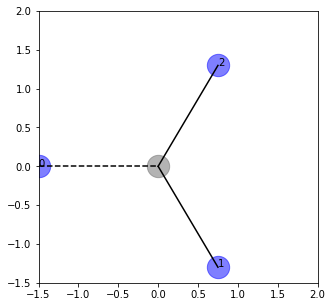

====1th kernel info====
1th-p_support:
torch.Size([3, 2])


1th-x_support:
tensor([[0.6181, 0.0209, 0.8472, 0.4731, 0.7033, 0.3513, 0.6204, 0.0957, 0.1131,
         0.2899, 0.3165, 0.9801, 0.8216, 0.0447, 0.9422, 0.0062, 0.4840, 0.7316,
         0.7420, 0.3663, 0.2208, 0.4281, 0.0108, 0.7512, 0.8971, 0.9784, 0.1087,
         0.5498, 0.4558, 0.3392, 0.9359, 0.8231, 0.1102, 0.9983, 0.2392, 0.8344,
         0.0437, 0.2458, 0.6096, 0.4435, 0.2489, 0.0870, 0.4138, 0.4112, 0.3981,
         0.0432, 0.2217, 0.4017, 0.9043, 0.9680, 0.3398, 0.0222, 0.7628, 0.2505,
         0.3259, 0.3384, 0.4210, 0.9402, 0.8942, 0.6745],
        [0.4052, 0.8916, 0.7474, 0.1440, 0.7240, 0.1127, 0.0077, 0.9602, 0.9034,
         0.8455, 0.9175, 0.9233, 0.5499, 0.0417, 0.5790, 0.3192, 0.9569, 0.7726,
         0.9715, 0.0832, 0.5226, 0.8494, 0.4536, 0.6882, 0.2026, 0.1802, 0.2409,
         0.7994, 0.1876, 0.8035, 0.7602, 0.9190, 0.0167, 0.8650, 0.2726, 0.2819,
         0.5828, 0.3197, 0.0819, 0.8706, 0.3308, 0.8177, 

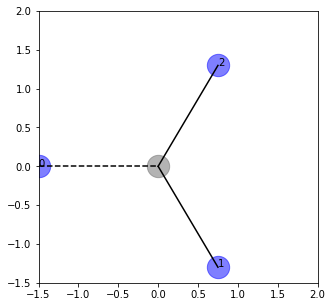

====2th kernel info====
2th-p_support:
torch.Size([3, 2])


2th-x_support:
tensor([[0.8607, 0.0200, 0.1175, 0.9899, 0.8862, 0.7879, 0.4360, 0.0032, 0.6494,
         0.5896, 0.8443, 0.0035, 0.5557, 0.6537, 0.0490, 0.8724, 0.9947, 0.4996,
         0.4062, 0.1681, 0.0241, 0.9291, 0.8023, 0.6670, 0.5239, 0.4649, 0.4909,
         0.4958, 0.0498, 0.2775, 0.5887, 0.1341, 0.3857, 0.1294, 0.9588, 0.1052,
         0.3359, 0.6475, 0.7729, 0.5999, 0.4012, 0.4340, 0.9641, 0.4496, 0.6357,
         0.9618, 0.3620, 0.6954, 0.5629, 0.1121, 0.5928, 0.1672, 0.0369, 0.8653,
         0.9016, 0.1201, 0.2047, 0.4013, 0.8555, 0.7293],
        [0.5689, 0.7385, 0.4596, 0.2823, 0.5306, 0.6702, 0.1747, 0.0449, 0.4960,
         0.1058, 0.4670, 0.2657, 0.8105, 0.5249, 0.6390, 0.1891, 0.5413, 0.5510,
         0.7308, 0.4901, 0.4966, 0.5096, 0.9439, 0.2822, 0.4511, 0.2388, 0.8633,
         0.6142, 0.6230, 0.6781, 0.3331, 0.5501, 0.2162, 0.2352, 0.3866, 0.5787,
         0.4697, 0.1242, 0.3507, 0.7730, 0.8424, 0.6116, 

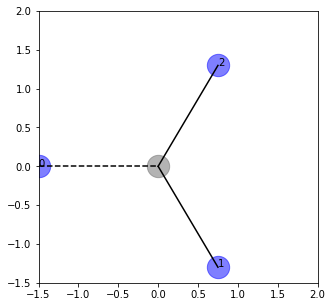

====3th kernel info====
3th-p_support:
torch.Size([3, 2])


3th-x_support:
tensor([[3.2096e-01, 5.2867e-01, 7.9657e-01, 8.8774e-01, 7.7564e-02, 8.9153e-02,
         7.1664e-01, 3.7584e-02, 1.8865e-01, 4.5806e-01, 3.9562e-01, 6.4303e-01,
         8.7065e-01, 8.3712e-01, 2.8629e-01, 9.3302e-01, 6.8712e-01, 3.8435e-01,
         3.0189e-01, 9.4081e-01, 9.0859e-01, 2.8383e-01, 9.8914e-01, 3.2465e-03,
         1.7787e-01, 1.2344e-01, 2.3051e-01, 7.0905e-01, 7.9305e-01, 6.2298e-01,
         6.9577e-01, 1.4409e-01, 2.4996e-01, 2.8449e-01, 4.9019e-01, 8.6010e-01,
         7.5075e-01, 2.4612e-01, 2.9510e-01, 2.7619e-01, 3.8302e-01, 6.2059e-02,
         9.5168e-01, 6.2422e-01, 3.4052e-01, 9.2618e-01, 4.7228e-01, 4.9587e-02,
         6.6199e-01, 4.1712e-01, 7.9611e-01, 2.4984e-01, 5.7068e-01, 8.5323e-01,
         7.6992e-02, 4.4150e-01, 9.9521e-01, 3.5747e-01, 3.9118e-01, 3.3730e-01],
        [7.4559e-02, 6.3241e-01, 7.3814e-01, 7.4021e-01, 4.5507e-04, 1.7046e-01,
         2.9107e-01, 1.0669e-01, 

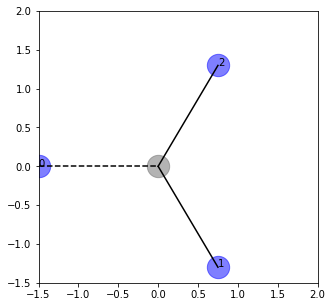

====4th kernel info====
4th-p_support:
torch.Size([3, 2])


4th-x_support:
tensor([[0.2765, 0.4323, 0.2893, 0.0647, 0.7449, 0.6664, 0.5318, 0.6709, 0.5935,
         0.4854, 0.8440, 0.7525, 0.9535, 0.7096, 0.2339, 0.5509, 0.6993, 0.2195,
         0.6576, 0.8049, 0.1693, 0.9279, 0.5766, 0.9078, 0.6481, 0.9702, 0.6266,
         0.7771, 0.4594, 0.6509, 0.5160, 0.4781, 0.9838, 0.9186, 0.2742, 0.6507,
         0.2322, 0.9038, 0.4566, 0.6504, 0.0791, 0.6142, 0.3672, 0.2353, 0.8206,
         0.7255, 0.6817, 0.5932, 0.6745, 0.6508, 0.3187, 0.3125, 0.4676, 0.0570,
         0.0068, 0.4693, 0.8547, 0.6554, 0.4956, 0.3750],
        [0.7232, 0.5516, 0.7743, 0.2975, 0.2826, 0.5779, 0.6120, 0.9129, 0.1978,
         0.3465, 0.3779, 0.4161, 0.9582, 0.1252, 0.0707, 0.5468, 0.0115, 0.3254,
         0.5788, 0.0730, 0.7811, 0.2572, 0.2795, 0.3590, 0.7483, 0.1629, 0.3708,
         0.3328, 0.1008, 0.8171, 0.8245, 0.7080, 0.7425, 0.6123, 0.3510, 0.0963,
         0.4135, 0.6594, 0.3544, 0.9207, 0.7040, 0.9167, 

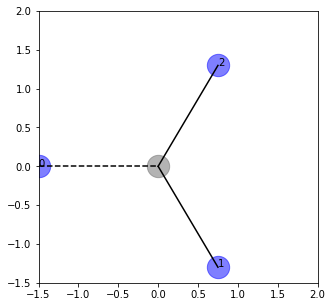

====5th kernel info====
5th-p_support:
torch.Size([3, 2])


5th-x_support:
tensor([[0.9955, 0.4643, 0.6569, 0.4891, 0.7949, 0.0768, 0.5227, 0.7643, 0.8912,
         0.5593, 0.5821, 0.4968, 0.5537, 0.8490, 0.4540, 0.4235, 0.7355, 0.9178,
         0.8648, 0.2177, 0.4804, 0.6563, 0.1288, 0.2131, 0.5370, 0.5330, 0.5738,
         0.6147, 0.6432, 0.7999, 0.0417, 0.5067, 0.2248, 0.2749, 0.1169, 0.2529,
         0.3416, 0.5013, 0.9294, 0.8085, 0.0845, 0.7365, 0.4562, 0.7242, 0.2805,
         0.5386, 0.8988, 0.0306, 0.9618, 0.5787, 0.4027, 0.3117, 0.6773, 0.2480,
         0.6337, 0.1069, 0.8764, 0.8049, 0.5100, 0.6198],
        [0.9072, 0.1060, 0.9845, 0.6376, 0.2384, 0.3913, 0.1402, 0.3617, 0.2789,
         0.3057, 0.1912, 0.2355, 0.1827, 0.0812, 0.5635, 0.2517, 0.9432, 0.2279,
         0.3140, 0.4205, 0.4561, 0.1403, 0.0545, 0.4683, 0.6349, 0.7677, 0.1972,
         0.5589, 0.2791, 0.0552, 0.8953, 0.3590, 0.6489, 0.7190, 0.7558, 0.6738,
         0.2670, 0.9370, 0.8494, 0.4502, 0.9391, 0.5161, 

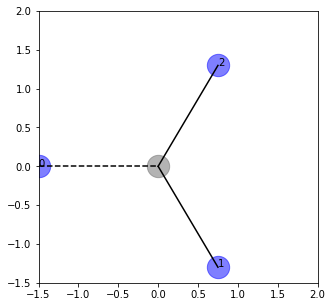

====6th kernel info====
6th-p_support:
torch.Size([3, 2])


6th-x_support:
tensor([[0.1375, 0.3792, 0.4888, 0.2478, 0.4020, 0.5831, 0.0528, 0.0330, 0.8711,
         0.1765, 0.9778, 0.3093, 0.1640, 0.8646, 0.7842, 0.4377, 0.9863, 0.2443,
         0.7541, 0.8163, 0.5605, 0.6698, 0.3160, 0.4244, 0.1237, 0.4094, 0.9633,
         0.3127, 0.7644, 0.5709, 0.6111, 0.2701, 0.1417, 0.7921, 0.0853, 0.2752,
         0.8270, 0.3146, 0.4386, 0.7740, 0.8779, 0.5353, 0.1542, 0.5300, 0.7198,
         0.6249, 0.0600, 0.1065, 0.8515, 0.5805, 0.8521, 0.3109, 0.0314, 0.7991,
         0.1336, 0.3473, 0.3704, 0.2300, 0.3478, 0.0560],
        [0.2063, 0.6697, 0.9330, 0.3333, 0.6448, 0.5080, 0.0303, 0.0280, 0.8059,
         0.3162, 0.8729, 0.7161, 0.5085, 0.5859, 0.8825, 0.6305, 0.4511, 0.2118,
         0.2592, 0.7899, 0.2947, 0.1315, 0.1808, 0.7037, 0.4734, 0.4887, 0.2531,
         0.7786, 0.2735, 0.3905, 0.7943, 0.2453, 0.3061, 0.2823, 0.0529, 0.4348,
         0.3865, 0.5321, 0.5110, 0.1357, 0.2977, 0.4344, 

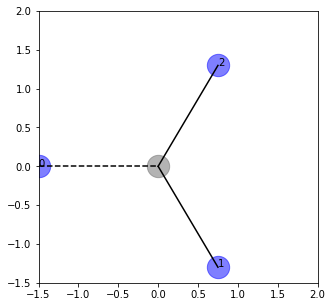

====7th kernel info====
7th-p_support:
torch.Size([3, 2])


7th-x_support:
tensor([[0.2292, 0.6388, 0.8802, 0.1935, 0.7875, 0.7155, 0.5200, 0.2159, 0.4182,
         0.7462, 0.1871, 0.8249, 0.3447, 0.0411, 0.1380, 0.0014, 0.4410, 0.1651,
         0.2575, 0.8940, 0.6266, 0.9538, 0.6969, 0.3854, 0.8772, 0.6665, 0.3827,
         0.7901, 0.8313, 0.2166, 0.4967, 0.3612, 0.3565, 0.2486, 0.9696, 0.3561,
         0.0043, 0.5678, 0.1945, 0.5561, 0.2220, 0.6653, 0.5683, 0.3614, 0.4763,
         0.2096, 0.2329, 0.4493, 0.8296, 0.2277, 0.9824, 0.6123, 0.9889, 0.8891,
         0.2752, 0.0856, 0.3113, 0.3399, 0.8937, 0.7672],
        [0.6844, 0.4539, 0.9124, 0.3731, 0.6389, 0.8951, 0.0268, 0.1494, 0.5441,
         0.0185, 0.6075, 0.4721, 0.1728, 0.5608, 0.6283, 0.0854, 0.1566, 0.7532,
         0.5224, 0.8453, 0.9755, 0.3472, 0.2453, 0.9960, 0.6997, 0.5702, 0.7724,
         0.1314, 0.2097, 0.8129, 0.8107, 0.9069, 0.8937, 0.5161, 0.4646, 0.3508,
         0.4602, 0.4455, 0.6211, 0.1977, 0.1966, 0.8191, 

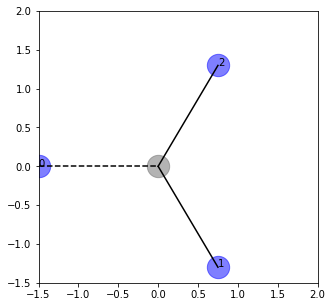

====8th kernel info====
8th-p_support:
torch.Size([3, 2])


8th-x_support:
tensor([[0.4838, 0.1846, 0.0724, 0.8526, 0.0049, 0.5526, 0.3414, 0.6597, 0.8625,
         0.3489, 0.5870, 0.3674, 0.1419, 0.3049, 0.3404, 0.3884, 0.0197, 0.5803,
         0.7845, 0.8541, 0.8755, 0.3336, 0.4911, 0.5377, 0.4073, 0.6057, 0.6978,
         0.2055, 0.2022, 0.9100, 0.0732, 0.9102, 0.2459, 0.6369, 0.3384, 0.1890,
         0.5883, 0.3232, 0.7323, 0.5361, 0.6165, 0.6797, 0.9980, 0.4438, 0.7201,
         0.4412, 0.9653, 0.7364, 0.8013, 0.4262, 0.0249, 0.2724, 0.3773, 0.8316,
         0.7872, 0.2475, 0.4451, 0.9929, 0.7839, 0.7333],
        [0.0793, 0.8677, 0.4882, 0.3089, 0.9501, 0.1970, 0.5598, 0.0824, 0.7282,
         0.8259, 0.9032, 0.2384, 0.9104, 0.4584, 0.1865, 0.0793, 0.3578, 0.4780,
         0.4898, 0.3011, 0.0062, 0.3250, 0.9722, 0.8333, 0.4371, 0.1219, 0.1492,
         0.7603, 0.7244, 0.3076, 0.2741, 0.4890, 0.3615, 0.2339, 0.0635, 0.1088,
         0.7340, 0.5031, 0.4701, 0.4183, 0.7088, 0.6860, 

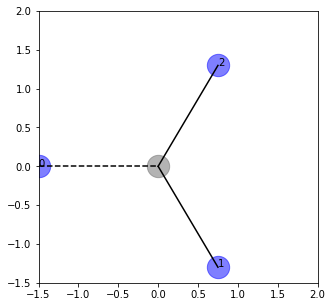

====9th kernel info====
9th-p_support:
torch.Size([3, 2])


9th-x_support:
tensor([[0.2415, 0.3491, 0.3974, 0.4242, 0.6176, 0.9734, 0.2474, 0.9870, 0.8079,
         0.5426, 0.8056, 0.3554, 0.8852, 0.5372, 0.6643, 0.0683, 0.6533, 0.9234,
         0.3270, 0.6825, 0.9040, 0.6925, 0.6000, 0.7500, 0.9932, 0.7749, 0.9161,
         0.4322, 0.2637, 0.4246, 0.6028, 0.6338, 0.4209, 0.9490, 0.5919, 0.3933,
         0.8853, 0.9359, 0.2840, 0.4316, 0.8600, 0.8365, 0.4852, 0.5899, 0.1912,
         0.4814, 0.7269, 0.6062, 0.9866, 0.0905, 0.8777, 0.1311, 0.9880, 0.8167,
         0.4945, 0.0771, 0.7590, 0.6797, 0.9968, 0.3128],
        [0.7203, 0.6761, 0.1272, 0.0090, 0.5400, 0.6604, 0.1588, 0.9151, 0.1242,
         0.8605, 0.3653, 0.0752, 0.0415, 0.2740, 0.3518, 0.7965, 0.1715, 0.3047,
         0.9862, 0.2707, 0.6886, 0.1505, 0.0939, 0.3366, 0.4080, 0.6322, 0.2358,
         0.2121, 0.6781, 0.0365, 0.1557, 0.1886, 0.1315, 0.1282, 0.2406, 0.5385,
         0.9544, 0.0145, 0.0537, 0.4945, 0.3134, 0.8551, 

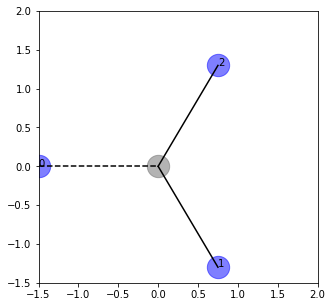

====10th kernel info====
10th-p_support:
torch.Size([3, 2])


10th-x_support:
tensor([[0.7178, 0.2390, 0.1572, 0.5086, 0.8472, 0.5073, 0.8825, 0.4460, 0.5454,
         0.6687, 0.1064, 0.6016, 0.2183, 0.5404, 0.3721, 0.0395, 0.0436, 0.0434,
         0.0600, 0.4230, 0.6341, 0.1405, 0.5145, 0.8605, 0.6454, 0.4758, 0.4459,
         0.3307, 0.4025, 0.5515, 0.1206, 0.1657, 0.6581, 0.9639, 0.6542, 0.2413,
         0.2742, 0.4212, 0.2166, 0.1838, 0.2870, 0.3785, 0.6485, 0.9721, 0.6702,
         0.8557, 0.5284, 0.9383, 0.7712, 0.3342, 0.7486, 0.7348, 0.3329, 0.4655,
         0.4951, 0.3136, 0.9881, 0.0680, 0.9893, 0.3665],
        [0.7876, 0.8431, 0.4997, 0.5689, 0.3866, 0.7036, 0.5663, 0.9131, 0.4084,
         0.7891, 0.0126, 0.7856, 0.6406, 0.7691, 0.9283, 0.7053, 0.4477, 0.3148,
         0.1823, 0.8430, 0.7368, 0.5158, 0.6374, 0.0883, 0.5640, 0.1840, 0.8873,
         0.3261, 0.7324, 0.3385, 0.4800, 0.5879, 0.3683, 0.7203, 0.4532, 0.1305,
         0.4847, 0.4132, 0.2730, 0.2847, 0.9357, 0.306

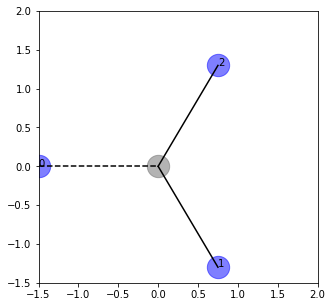

====11th kernel info====
11th-p_support:
torch.Size([3, 2])


11th-x_support:
tensor([[0.3950, 0.7412, 0.2679, 0.4208, 0.0681, 0.1352, 0.8326, 0.9184, 0.4940,
         0.4938, 0.9694, 0.2477, 0.9697, 0.5510, 0.0024, 0.7759, 0.8767, 0.1599,
         0.7998, 0.0768, 0.2151, 0.5012, 0.3671, 0.0311, 0.6272, 0.2405, 0.0994,
         0.1519, 0.0732, 0.1948, 0.8137, 0.3950, 0.7599, 0.2169, 0.0666, 0.7680,
         0.5936, 0.1774, 0.1680, 0.0455, 0.2444, 0.5493, 0.9151, 0.4839, 0.0350,
         0.1124, 0.6224, 0.6044, 0.8976, 0.9486, 0.0977, 0.7733, 0.4860, 0.3202,
         0.9040, 0.6975, 0.0137, 0.6992, 0.6903, 0.6562],
        [0.6389, 0.7518, 0.0792, 0.4629, 0.8688, 0.8429, 0.8836, 0.8208, 0.1742,
         0.2940, 0.3089, 0.2385, 0.9912, 0.7842, 0.5103, 0.7781, 0.1137, 0.9131,
         0.3126, 0.7188, 0.3044, 0.6188, 0.1136, 0.9764, 0.0586, 0.7155, 0.5524,
         0.0108, 0.4826, 0.5330, 0.1864, 0.0332, 0.2545, 0.0466, 0.2374, 0.9913,
         0.7190, 0.0097, 0.8696, 0.9331, 0.2021, 0.627

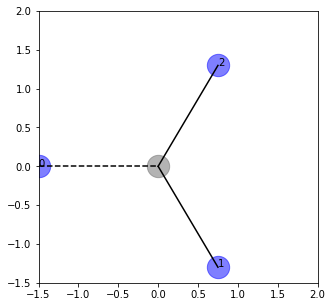

====12th kernel info====
12th-p_support:
torch.Size([3, 2])


12th-x_support:
tensor([[0.5562, 0.9521, 0.6308, 0.0896, 0.8942, 0.7854, 0.2546, 0.0560, 0.7383,
         0.6042, 0.3079, 0.2978, 0.6847, 0.9400, 0.5424, 0.6576, 0.1205, 0.0624,
         0.1243, 0.9968, 0.9488, 0.2744, 0.9088, 0.6987, 0.4998, 0.6952, 0.4647,
         0.4161, 0.0712, 0.8605, 0.1292, 0.5645, 0.7378, 0.0964, 0.0390, 0.1533,
         0.0946, 0.4222, 0.3311, 0.9320, 0.4832, 0.9476, 0.7584, 0.0401, 0.8843,
         0.6655, 0.5551, 0.2516, 0.9852, 0.9573, 0.3053, 0.5048, 0.1622, 0.4604,
         0.1360, 0.8620, 0.7285, 0.0593, 0.9174, 0.6361],
        [0.6443, 0.1826, 0.2678, 0.5640, 0.4743, 0.2357, 0.7088, 0.4989, 0.9785,
         0.9573, 0.6194, 0.8764, 0.1902, 0.6286, 0.3395, 0.4726, 0.6845, 0.0159,
         0.7000, 0.2549, 0.8943, 0.6124, 0.5753, 0.4009, 0.4237, 0.7139, 0.7999,
         0.3083, 0.3841, 0.5337, 0.2666, 0.6773, 0.2485, 0.5572, 0.3191, 0.7588,
         0.7961, 0.3468, 0.7101, 0.6028, 0.5531, 0.552

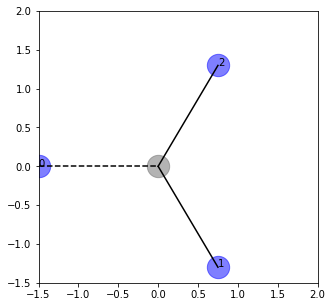

====13th kernel info====
13th-p_support:
torch.Size([3, 2])


13th-x_support:
tensor([[0.5189, 0.4911, 0.9558, 0.6288, 0.3858, 0.0090, 0.0775, 0.7727, 0.4378,
         0.3500, 0.0090, 0.1075, 0.1647, 0.0022, 0.7271, 0.1910, 0.4153, 0.0016,
         0.2543, 0.0527, 0.9104, 0.4806, 0.5579, 0.8114, 0.5411, 0.7892, 0.9622,
         0.5114, 0.2268, 0.1337, 0.9255, 0.0601, 0.3911, 0.0799, 0.7475, 0.6171,
         0.2954, 0.3719, 0.8505, 0.6185, 0.7629, 0.6179, 0.8144, 0.7525, 0.4527,
         0.8751, 0.1639, 0.9314, 0.6473, 0.2859, 0.2783, 0.2697, 0.2574, 0.0138,
         0.4757, 0.8422, 0.1696, 0.7056, 0.5333, 0.4231],
        [0.7184, 0.3540, 0.3682, 0.5188, 0.9266, 0.3221, 0.5990, 0.8671, 0.2733,
         0.9753, 0.6597, 0.6975, 0.2133, 0.7535, 0.4898, 0.7649, 0.5038, 0.5930,
         0.0287, 0.3144, 0.4779, 0.4692, 0.8208, 0.6413, 0.8486, 0.2090, 0.4436,
         0.0159, 0.3119, 0.6257, 0.0404, 0.5866, 0.6052, 0.7298, 0.5355, 0.3165,
         0.7719, 0.8173, 0.2299, 0.0557, 0.2364, 0.973

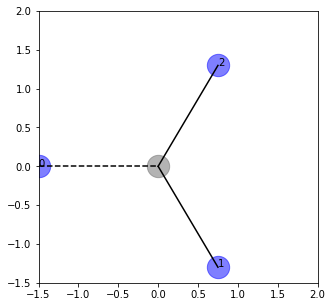

====14th kernel info====
14th-p_support:
torch.Size([3, 2])


14th-x_support:
tensor([[0.2185, 0.5076, 0.2869, 0.7119, 0.6130, 0.4810, 0.8044, 0.8054, 0.0483,
         0.2452, 0.9854, 0.7380, 0.6774, 0.0612, 0.8152, 0.2919, 0.0868, 0.6501,
         0.2498, 0.6527, 0.8650, 0.0542, 0.1807, 0.0159, 0.6049, 0.1992, 0.2225,
         0.9106, 0.5403, 0.7312, 0.6842, 0.0668, 0.5804, 0.9298, 0.4855, 0.9764,
         0.9318, 0.4987, 0.4577, 0.4638, 0.2402, 0.4160, 0.7652, 0.4561, 0.3112,
         0.3486, 0.3308, 0.8856, 0.2080, 0.8995, 0.5043, 0.6134, 0.8059, 0.6958,
         0.2020, 0.7715, 0.7219, 0.1079, 0.0505, 0.3818],
        [0.2043, 0.3151, 0.2054, 0.8226, 0.5374, 0.7316, 0.1353, 0.6911, 0.1886,
         0.9462, 0.0822, 0.3652, 0.7452, 0.0698, 0.9738, 0.5200, 0.3364, 0.7855,
         0.4645, 0.1433, 0.2504, 0.4322, 0.8003, 0.4226, 0.3855, 0.2814, 0.1061,
         0.6322, 0.1233, 0.8249, 0.3057, 0.5070, 0.4370, 0.1074, 0.9363, 0.9786,
         0.9592, 0.5625, 0.2447, 0.9887, 0.6609, 0.453

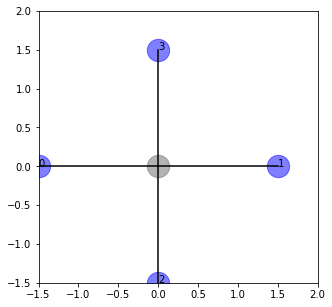

====0th kernel info====
0th-p_support:
torch.Size([4, 2])


0th-x_support:
tensor([[0.5687, 0.3705, 0.1194, 0.4133, 0.8636, 0.0718, 0.2071, 0.3342, 0.9842,
         0.1874, 0.2608, 0.3715, 0.0746, 0.1486, 0.3949, 0.4041, 0.5935, 0.0815,
         0.1453, 0.7090, 0.9035, 0.4510, 0.7391, 0.3119, 0.8395, 0.6997, 0.3878,
         0.4861, 0.3042, 0.4817, 0.7537, 0.5075, 0.6065, 0.4084, 0.1982, 0.5717,
         0.9297, 0.0585, 0.1620, 0.6270, 0.2599, 0.2049, 0.5707, 0.8308, 0.1832,
         0.7619, 0.8137, 0.7318, 0.4220, 0.1331, 0.0043, 0.1205, 0.4827, 0.4054,
         0.9167, 0.7662, 0.1106, 0.3905, 0.9730, 0.7531],
        [0.0905, 0.8255, 0.8623, 0.2437, 0.9962, 0.6516, 0.8369, 0.3628, 0.3459,
         0.8123, 0.0044, 0.7881, 0.1738, 0.0121, 0.1886, 0.4172, 0.2061, 0.7369,
         0.4903, 0.3737, 0.6203, 0.2893, 0.7664, 0.5208, 0.8004, 0.0019, 0.2980,
         0.0084, 0.9743, 0.0353, 0.8551, 0.1593, 0.2032, 0.2180, 0.1275, 0.7670,
         0.1741, 0.4445, 0.8649, 0.9870, 0.2070, 0.7938, 

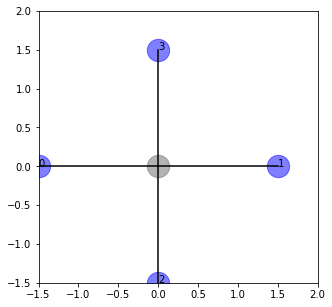

====1th kernel info====
1th-p_support:
torch.Size([4, 2])


1th-x_support:
tensor([[0.2238, 0.8958, 0.3616, 0.4830, 0.4600, 0.1006, 0.6289, 0.0025, 0.4056,
         0.8571, 0.4904, 0.2870, 0.8620, 0.1938, 0.4080, 0.4783, 0.3176, 0.3911,
         0.4506, 0.6010, 0.0759, 0.2513, 0.5970, 0.5903, 0.7427, 0.3417, 0.9877,
         0.8943, 0.6538, 0.4952, 0.9669, 0.7187, 0.0501, 0.3538, 0.9681, 0.4288,
         0.1245, 0.8498, 0.3305, 0.9810, 0.1366, 0.5898, 0.1761, 0.8391, 0.4196,
         0.3162, 0.9844, 0.7774, 0.8946, 0.6864, 0.5636, 0.5157, 0.3059, 0.8494,
         0.7796, 0.3861, 0.8320, 0.6084, 0.4668, 0.7333],
        [0.0409, 0.0703, 0.5799, 0.0556, 0.8890, 0.0349, 0.2096, 0.5065, 0.3202,
         0.3925, 0.9177, 0.7091, 0.6308, 0.7285, 0.2831, 0.8445, 0.7532, 0.2320,
         0.5737, 0.9694, 0.5545, 0.2763, 0.2107, 0.5744, 0.3180, 0.5752, 0.4978,
         0.5237, 0.1435, 0.2011, 0.0133, 0.2938, 0.9325, 0.5416, 0.2531, 0.7930,
         0.1751, 0.6303, 0.1036, 0.9665, 0.5829, 0.0418, 

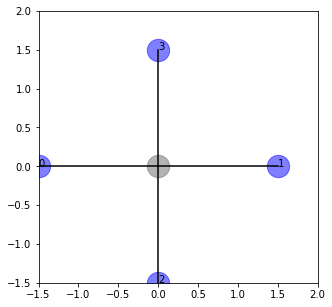

====2th kernel info====
2th-p_support:
torch.Size([4, 2])


2th-x_support:
tensor([[7.4744e-01, 3.8968e-01, 1.6070e-01, 9.2967e-01, 5.1125e-01, 6.3194e-01,
         5.8001e-01, 4.6269e-01, 7.3584e-01, 4.8140e-01, 7.2334e-01, 1.7986e-01,
         8.9227e-01, 2.1560e-01, 4.6939e-01, 2.0912e-01, 5.5651e-01, 6.5145e-01,
         2.7911e-01, 5.6027e-01, 4.4390e-01, 8.7026e-01, 1.8542e-01, 5.2661e-01,
         5.7080e-01, 8.6781e-01, 9.1801e-01, 7.9653e-01, 1.5502e-01, 7.2390e-01,
         9.5142e-01, 9.0276e-02, 7.9419e-01, 9.6301e-01, 9.3316e-01, 7.0170e-01,
         1.3950e-01, 7.5367e-01, 9.7638e-04, 9.3904e-01, 9.9886e-01, 3.9176e-01,
         3.4852e-01, 6.8520e-01, 2.5071e-01, 7.3234e-01, 9.1144e-01, 3.6053e-01,
         3.4173e-01, 2.7820e-01, 8.4331e-01, 6.1292e-01, 3.1830e-01, 8.9754e-01,
         8.8782e-01, 9.1634e-01, 8.5538e-02, 7.6582e-01, 5.1166e-02, 2.3224e-01],
        [4.0234e-01, 2.7990e-02, 9.0458e-01, 1.5851e-01, 1.5066e-01, 4.7484e-01,
         3.2638e-01, 3.0276e-01, 

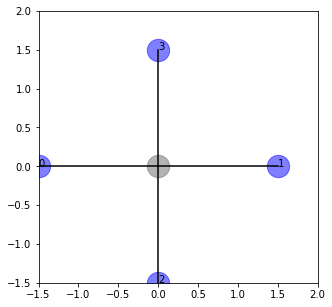

====3th kernel info====
3th-p_support:
torch.Size([4, 2])


3th-x_support:
tensor([[0.9853, 0.5227, 0.6406, 0.8211, 0.2875, 0.4115, 0.2458, 0.1280, 0.6488,
         0.5153, 0.8121, 0.3327, 0.0572, 0.8299, 0.9374, 0.5112, 0.4956, 0.1058,
         0.5846, 0.8363, 0.1179, 0.1253, 0.2114, 0.4882, 0.1048, 0.6143, 0.4833,
         0.2889, 0.4705, 0.6909, 0.5680, 0.6918, 0.4717, 0.4844, 0.2514, 0.7143,
         0.0296, 0.7100, 0.3565, 0.5279, 0.8897, 0.6878, 0.9154, 0.5300, 0.3296,
         0.9334, 0.7543, 0.4789, 0.7807, 0.5989, 0.4049, 0.9456, 0.4425, 0.2191,
         0.3784, 0.0581, 0.2922, 0.8816, 0.4700, 0.1035],
        [0.0067, 0.1056, 0.0016, 0.4364, 0.5942, 0.5011, 0.1539, 0.8402, 0.1328,
         0.5335, 0.9441, 0.6251, 0.0047, 0.2159, 0.2471, 0.3650, 0.4022, 0.1367,
         0.6077, 0.7086, 0.4832, 0.4412, 0.1324, 0.9180, 0.4187, 0.2897, 0.5589,
         0.0513, 0.6664, 0.0986, 0.1963, 0.4699, 0.0695, 0.3151, 0.2616, 0.6475,
         0.0671, 0.3383, 0.4875, 0.8864, 0.1567, 0.8300, 

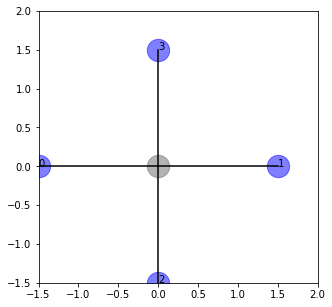

====4th kernel info====
4th-p_support:
torch.Size([4, 2])


4th-x_support:
tensor([[1.8751e-01, 5.8697e-01, 6.9586e-01, 3.5461e-01, 7.1395e-01, 5.5143e-02,
         4.3016e-01, 8.0658e-01, 4.5959e-01, 5.5825e-01, 1.9504e-01, 4.0130e-01,
         7.6785e-01, 1.0682e-01, 2.8948e-01, 2.2440e-01, 2.0021e-02, 6.1268e-02,
         9.2472e-01, 3.5019e-01, 9.5409e-01, 5.8872e-02, 2.9352e-01, 2.0098e-01,
         9.9603e-02, 6.8208e-01, 8.4672e-01, 4.6485e-01, 1.4766e-01, 7.7641e-01,
         5.9778e-04, 1.1050e-01, 1.5575e-01, 4.4788e-01, 9.9288e-01, 7.3498e-01,
         4.6871e-01, 4.3908e-01, 2.1299e-01, 9.5749e-01, 9.2706e-03, 8.7335e-01,
         7.6108e-01, 1.7845e-01, 6.9630e-01, 1.5728e-01, 7.2070e-01, 9.1677e-01,
         6.8755e-01, 2.1066e-01, 5.4776e-01, 1.0069e-01, 9.0845e-01, 4.0720e-01,
         3.9764e-01, 9.3292e-01, 1.6795e-01, 8.8383e-01, 3.4646e-02, 7.3824e-01],
        [3.1201e-01, 9.5076e-01, 3.9627e-01, 9.8402e-01, 2.3213e-01, 6.6745e-02,
         5.1028e-01, 9.9561e-01, 

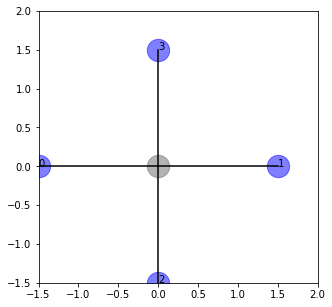

====5th kernel info====
5th-p_support:
torch.Size([4, 2])


5th-x_support:
tensor([[2.6748e-01, 5.0925e-01, 5.6000e-01, 8.3920e-01, 5.8479e-01, 6.9024e-01,
         3.2103e-01, 7.4852e-02, 1.7216e-01, 4.4999e-03, 5.7872e-01, 4.8763e-04,
         2.2409e-01, 7.2399e-01, 2.5972e-01, 4.3274e-01, 4.1725e-01, 6.8685e-01,
         4.9544e-01, 9.0151e-01, 1.1998e-01, 4.1957e-01, 3.5442e-01, 8.5062e-01,
         9.1902e-01, 6.3172e-01, 2.1108e-01, 2.8541e-01, 5.7470e-01, 3.4536e-01,
         5.7340e-02, 2.3512e-01, 5.0131e-01, 6.7541e-01, 3.9609e-01, 6.4925e-01,
         3.9794e-01, 3.5171e-01, 5.2836e-01, 1.4417e-01, 7.2411e-01, 9.3207e-01,
         8.7751e-01, 1.9003e-01, 8.8769e-01, 7.6886e-01, 8.4702e-01, 2.2967e-02,
         9.9618e-01, 9.9322e-01, 8.9335e-01, 9.7899e-01, 5.5258e-01, 4.8920e-01,
         2.5467e-01, 9.1685e-01, 4.1322e-01, 8.9260e-01, 6.6950e-01, 5.6851e-01],
        [8.1474e-01, 9.3244e-01, 3.6304e-01, 2.5130e-01, 5.4409e-01, 1.1857e-01,
         7.4587e-01, 6.8783e-01, 

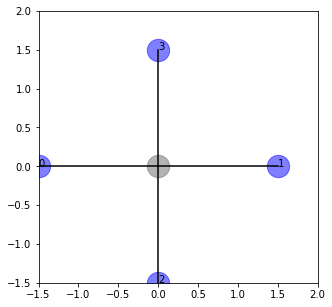

====6th kernel info====
6th-p_support:
torch.Size([4, 2])


6th-x_support:
tensor([[0.4078, 0.4162, 0.0577, 0.1822, 0.0858, 0.4884, 0.5862, 0.1077, 0.8670,
         0.7672, 0.7612, 0.5651, 0.3975, 0.0982, 0.6973, 0.6707, 0.8046, 0.6638,
         0.0079, 0.7132, 0.6312, 0.3530, 0.6946, 0.9002, 0.2729, 0.6590, 0.4838,
         0.6734, 0.6411, 0.8766, 0.7207, 0.5891, 0.3941, 0.3496, 0.6592, 0.6192,
         0.8161, 0.1984, 0.0449, 0.9941, 0.1150, 0.1243, 0.4647, 0.7429, 0.0639,
         0.6525, 0.8646, 0.2560, 0.7589, 0.2350, 0.2320, 0.4320, 0.3731, 0.4475,
         0.4841, 0.4443, 0.2507, 0.7222, 0.8208, 0.3880],
        [0.8330, 0.3348, 0.8542, 0.3227, 0.2068, 0.0696, 0.2996, 0.6471, 0.4376,
         0.0922, 0.0010, 0.9125, 0.0750, 0.8954, 0.6278, 0.8675, 0.0298, 0.7885,
         0.0853, 0.6604, 0.5764, 0.0352, 0.8424, 0.9964, 0.3930, 0.7080, 0.4123,
         0.7629, 0.8325, 0.2729, 0.1516, 0.8447, 0.9166, 0.0901, 0.1197, 0.9357,
         0.2898, 0.2303, 0.3900, 0.5005, 0.8097, 0.7826, 

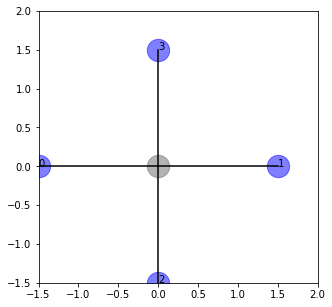

====7th kernel info====
7th-p_support:
torch.Size([4, 2])


7th-x_support:
tensor([[7.4717e-01, 3.3842e-01, 1.1111e-01, 1.1978e-02, 5.2978e-01, 1.0887e-01,
         5.6201e-01, 6.4175e-01, 8.8965e-01, 8.2370e-01, 4.8648e-01, 4.9182e-01,
         9.6620e-01, 2.5364e-01, 4.3524e-01, 5.8827e-01, 4.4654e-01, 8.1132e-01,
         7.2987e-01, 9.5478e-01, 3.7693e-01, 8.3008e-01, 7.8581e-01, 2.9568e-01,
         7.6279e-01, 2.4224e-01, 2.1926e-01, 3.0035e-01, 4.4421e-01, 2.7650e-01,
         5.7408e-01, 9.7407e-01, 1.9863e-01, 4.7951e-01, 8.9416e-01, 1.4790e-01,
         7.9321e-01, 9.3136e-01, 4.3040e-01, 8.9253e-01, 5.0200e-01, 6.1613e-01,
         7.4265e-02, 5.1854e-04, 2.1858e-01, 2.9017e-01, 5.4942e-01, 6.3882e-01,
         2.4487e-01, 9.8694e-01, 5.0279e-02, 9.6363e-01, 1.1530e-01, 2.8979e-01,
         3.1949e-01, 6.3340e-01, 2.5250e-01, 1.3056e-01, 4.1671e-01, 6.2431e-01],
        [8.6430e-01, 6.4160e-01, 4.2707e-01, 5.9517e-01, 2.6968e-01, 9.4948e-01,
         4.8681e-01, 2.3624e-01, 

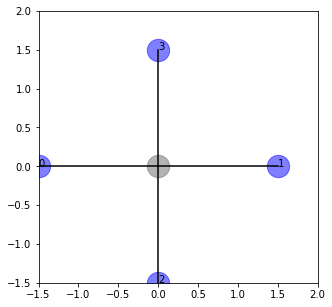

====8th kernel info====
8th-p_support:
torch.Size([4, 2])


8th-x_support:
tensor([[0.9574, 0.3720, 0.2158, 0.4080, 0.2608, 0.9213, 0.2042, 0.8604, 0.7784,
         0.7630, 0.9289, 0.4234, 0.1619, 0.5357, 0.4256, 0.6667, 0.0459, 0.3991,
         0.4807, 0.9957, 0.3499, 0.3557, 0.7847, 0.7350, 0.7534, 0.3271, 0.1005,
         0.0030, 0.9434, 0.7572, 0.6691, 0.4419, 0.9002, 0.1308, 0.9772, 0.2937,
         0.1788, 0.6884, 0.8031, 0.5332, 0.6149, 0.5022, 0.0647, 0.6282, 0.9119,
         0.8059, 0.5286, 0.1512, 0.3426, 0.5039, 0.7561, 0.7842, 0.6293, 0.0465,
         0.0213, 0.2881, 0.1141, 0.7930, 0.0856, 0.0593],
        [0.4669, 0.9500, 0.7627, 0.5799, 0.1169, 0.3790, 0.5230, 0.1189, 0.7665,
         0.8221, 0.0860, 0.6352, 0.6297, 0.9692, 0.0893, 0.6479, 0.0166, 0.2755,
         0.6636, 0.3563, 0.0421, 0.8717, 0.3119, 0.5520, 0.0339, 0.6407, 0.5872,
         0.1301, 0.4776, 0.4061, 0.8918, 0.6230, 0.0371, 0.6508, 0.3102, 0.7896,
         0.6238, 0.3320, 0.6491, 0.7391, 0.8523, 0.6495, 

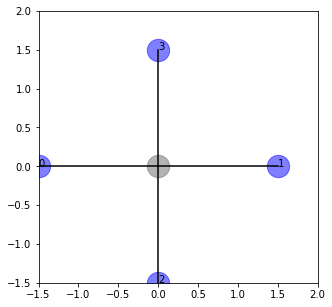

====9th kernel info====
9th-p_support:
torch.Size([4, 2])


9th-x_support:
tensor([[0.0718, 0.3913, 0.2055, 0.0326, 0.6640, 0.6566, 0.2119, 0.5295, 0.1053,
         0.7830, 0.1514, 0.4699, 0.4513, 0.2438, 0.8784, 0.1254, 0.4472, 0.7210,
         0.4390, 0.4344, 0.6144, 0.9115, 0.7935, 0.8599, 0.5806, 0.8445, 0.7623,
         0.5374, 0.4463, 0.7064, 0.7526, 0.5836, 0.1510, 0.5752, 0.2685, 0.6106,
         0.7874, 0.2013, 0.4890, 0.6372, 0.4949, 0.9882, 0.8293, 0.7503, 0.4033,
         0.5046, 0.7093, 0.6035, 0.8767, 0.9098, 0.3303, 0.4043, 0.4227, 0.4391,
         0.5014, 0.7633, 0.0317, 0.0756, 0.1234, 0.7132],
        [0.7770, 0.8743, 0.4837, 0.5969, 0.3415, 0.3024, 0.9151, 0.5546, 0.5340,
         0.1894, 0.1018, 0.3189, 0.9728, 0.9414, 0.7281, 0.5121, 0.1054, 0.4028,
         0.5406, 0.0113, 0.2495, 0.1352, 0.0583, 0.1192, 0.5970, 0.5007, 0.8365,
         0.7376, 0.6146, 0.8734, 0.9550, 0.0720, 0.3536, 0.7749, 0.6682, 0.2410,
         0.4840, 0.9091, 0.3595, 0.2461, 0.8091, 0.8603, 

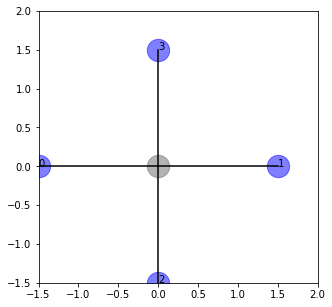

====10th kernel info====
10th-p_support:
torch.Size([4, 2])


10th-x_support:
tensor([[0.2951, 0.4651, 0.7385, 0.0462, 0.7624, 0.6037, 0.6368, 0.3620, 0.5541,
         0.5980, 0.7098, 0.0057, 0.8300, 0.8139, 0.4131, 0.4410, 0.8086, 0.6377,
         0.1573, 0.4172, 0.2258, 0.5981, 0.0870, 0.7998, 0.2386, 0.1821, 0.1094,
         0.6522, 0.0281, 0.7045, 0.8063, 0.9726, 0.7834, 0.3764, 0.9942, 0.0543,
         0.4142, 0.7425, 0.0217, 0.2949, 0.1676, 0.1933, 0.8836, 0.4403, 0.2875,
         0.6643, 0.5800, 0.3672, 0.0855, 0.3371, 0.1512, 0.7134, 0.8637, 0.6240,
         0.6181, 0.8359, 0.6941, 0.6777, 0.3479, 0.3938],
        [0.1220, 0.5269, 0.9439, 0.5226, 0.7031, 0.8440, 0.5241, 0.8072, 0.1153,
         0.8157, 0.5538, 0.2493, 0.4774, 0.1059, 0.8658, 0.1133, 0.0667, 0.1625,
         0.2631, 0.1572, 0.7017, 0.5008, 0.9940, 0.8868, 0.9662, 0.4396, 0.0744,
         0.6728, 0.2039, 0.0744, 0.7411, 0.8957, 0.8848, 0.2637, 0.5734, 0.9221,
         0.6824, 0.4023, 0.3212, 0.9047, 0.3175, 0.053

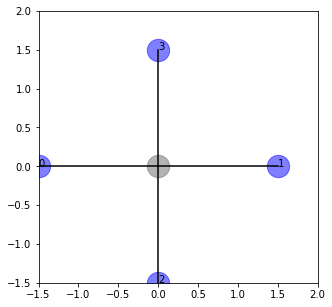

====11th kernel info====
11th-p_support:
torch.Size([4, 2])


11th-x_support:
tensor([[0.1775, 0.4880, 0.6461, 0.8925, 0.0259, 0.9771, 0.9969, 0.7451, 0.0539,
         0.5023, 0.2014, 0.7621, 0.1501, 0.6677, 0.1177, 0.9366, 0.3322, 0.1395,
         0.5544, 0.7785, 0.8808, 0.2097, 0.9556, 0.1854, 0.3902, 0.4984, 0.3462,
         0.8246, 0.7084, 0.2142, 0.8513, 0.9429, 0.8919, 0.1233, 0.1749, 0.4605,
         0.1161, 0.9649, 0.0919, 0.2793, 0.1745, 0.6527, 0.4946, 0.1440, 0.3155,
         0.4919, 0.6995, 0.8629, 0.1799, 0.7844, 0.6762, 0.3095, 0.1511, 0.6092,
         0.1851, 0.4393, 0.2385, 0.4811, 0.1119, 0.6495],
        [0.4553, 0.6176, 0.6164, 0.1435, 0.0504, 0.8594, 0.3293, 0.5666, 0.6631,
         0.8469, 0.3300, 0.9523, 0.9038, 0.8067, 0.0022, 0.7661, 0.3641, 0.6891,
         0.7392, 0.5474, 0.4944, 0.8007, 0.7061, 0.2237, 0.2954, 0.7837, 0.4886,
         0.4603, 0.3482, 0.1490, 0.5206, 0.6268, 0.4223, 0.6810, 0.9045, 0.1277,
         0.1486, 0.2394, 0.1037, 0.6597, 0.6366, 0.239

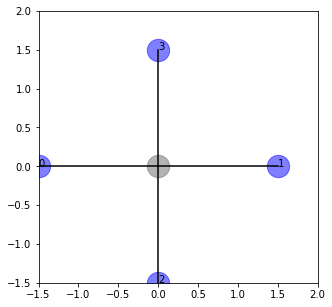

====12th kernel info====
12th-p_support:
torch.Size([4, 2])


12th-x_support:
tensor([[0.7017, 0.0112, 0.9785, 0.0987, 0.6045, 0.8022, 0.9672, 0.4144, 0.8597,
         0.9375, 0.7475, 0.2777, 0.4354, 0.9515, 0.4467, 0.9969, 0.6970, 0.5386,
         0.0794, 0.7291, 0.2635, 0.9961, 0.0336, 0.3146, 0.0555, 0.9577, 0.3616,
         0.0849, 0.8935, 0.3699, 0.6905, 0.3258, 0.4843, 0.9869, 0.0096, 0.7871,
         0.0485, 0.7293, 0.6460, 0.7989, 0.6014, 0.5968, 0.2427, 0.9248, 0.0240,
         0.2241, 0.2575, 0.6277, 0.3032, 0.0333, 0.7377, 0.5388, 0.3876, 0.4788,
         0.5709, 0.8429, 0.7834, 0.2718, 0.4334, 0.3093],
        [0.2574, 0.9763, 0.0136, 0.8895, 0.0374, 0.2929, 0.4123, 0.8493, 0.2519,
         0.4620, 0.5284, 0.2111, 0.7318, 0.5355, 0.4407, 0.1704, 0.4063, 0.2821,
         0.8952, 0.5810, 0.1420, 0.2820, 0.4250, 0.3163, 0.4221, 0.0832, 0.1924,
         0.0395, 0.4705, 0.3314, 0.0791, 0.9877, 0.1121, 0.6676, 0.1068, 0.8144,
         0.3529, 0.6813, 0.3729, 0.5569, 0.1175, 0.566

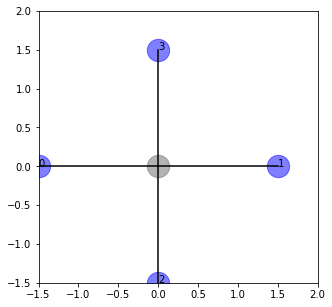

====13th kernel info====
13th-p_support:
torch.Size([4, 2])


13th-x_support:
tensor([[0.7337, 0.1307, 0.6250, 0.6955, 0.1429, 0.3891, 0.3270, 0.5075, 0.5563,
         0.0602, 0.7174, 0.5811, 0.2727, 0.9384, 0.1576, 0.8814, 0.9825, 0.8169,
         0.0229, 0.4097, 0.4237, 0.6101, 0.0311, 0.6362, 0.7779, 0.4352, 0.8751,
         0.2642, 0.1725, 0.9045, 0.6001, 0.8238, 0.9882, 0.1965, 0.3604, 0.0566,
         0.4819, 0.8310, 0.8020, 0.4324, 0.2239, 0.4957, 0.7809, 0.6808, 0.2560,
         0.2782, 0.1062, 0.9938, 0.5643, 0.0646, 0.1117, 0.1930, 0.6804, 0.5819,
         0.0217, 0.8364, 0.4707, 0.1736, 0.6074, 0.3443],
        [0.0991, 0.6064, 0.3487, 0.6130, 0.5302, 0.4804, 0.5096, 0.2082, 0.4782,
         0.0461, 0.5239, 0.1967, 0.7542, 0.7495, 0.8248, 0.5795, 0.1414, 0.9469,
         0.4803, 0.2317, 0.8312, 0.4322, 0.8605, 0.1756, 0.7800, 0.6235, 0.0977,
         0.0038, 0.6967, 0.6727, 0.6387, 0.9076, 0.6132, 0.1180, 0.6943, 0.5724,
         0.3005, 0.9011, 0.0394, 0.0682, 0.1070, 0.155

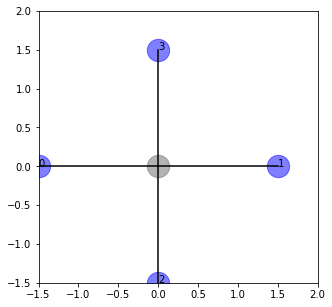

====14th kernel info====
14th-p_support:
torch.Size([4, 2])


14th-x_support:
tensor([[0.0526, 0.8942, 0.7464, 0.9227, 0.7077, 0.5722, 0.3280, 0.9670, 0.8943,
         0.9210, 0.6271, 0.0581, 0.9641, 0.4819, 0.6004, 0.1905, 0.8887, 0.8624,
         0.7967, 0.9812, 0.4944, 0.4847, 0.4370, 0.0497, 0.3273, 0.9128, 0.8427,
         0.3323, 0.1497, 0.4722, 0.0082, 0.2734, 0.1795, 0.4007, 0.2609, 0.0569,
         0.5907, 0.2635, 0.7462, 0.5002, 0.7569, 0.7804, 0.7601, 0.3375, 0.2579,
         0.1059, 0.5182, 0.4986, 0.4990, 0.7933, 0.3001, 0.5581, 0.7887, 0.3827,
         0.3691, 0.5563, 0.9473, 0.5675, 0.6712, 0.8628],
        [0.3541, 0.4901, 0.5567, 0.4015, 0.7380, 0.3814, 0.9575, 0.8876, 0.2627,
         0.7341, 0.0914, 0.2990, 0.9835, 0.7466, 0.6241, 0.9244, 0.7658, 0.7487,
         0.4937, 0.6292, 0.5300, 0.0606, 0.3465, 0.0436, 0.3284, 0.1239, 0.4383,
         0.5118, 0.4151, 0.7709, 0.1768, 0.5098, 0.8778, 0.9474, 0.4442, 0.2933,
         0.2548, 0.4110, 0.5634, 0.5049, 0.2948, 0.874

In [96]:
# visualize saved model kernels
model = PredefinedKernelSetConv(D=2, node_attr_dim=60, edge_attr_dim=1, L1=15, L2=15, L3=15, L4=15, is_first_layer=False)
# model = KernelSetConv(D=2, node_attr_dim = 5, edge_attr_dim = 1, L1=15, L2=15, L3=15, L4=15)
model.load_state_dict(torch.load('../init_kernellayers/3th_layer.pth'))

#1K_no_fixed_kernels/0th_layer.pth
#3Ksamples.pth
#1Ksamples.pth
print(list(model.state_dict()))
vis_kernel_in_kernelsetconv(model, prefix='trainable')

PredefinedKernelSetConv: there are 15 degree1 trainable kernels
PredefinedKernelSetConv: there are 15 degree2 trainable kernels
PredefinedKernelSetConv: there are 15 degree3 trainable kernels
PredefinedKernelSetConv: there are 15 degree4 trainable kernels
self.num_kernel_list:[15, 15, 15, 15]
['trainable_kernelconv_set.0.x_center', 'trainable_kernelconv_set.0.x_support', 'trainable_kernelconv_set.0.edge_attr_support', 'trainable_kernelconv_set.0.p_support', 'trainable_kernelconv_set.0.length_sc_weight', 'trainable_kernelconv_set.0.angle_sc_weight', 'trainable_kernelconv_set.0.center_attr_sc_weight', 'trainable_kernelconv_set.0.support_attr_sc_weight', 'trainable_kernelconv_set.0.edge_attr_support_sc_weight', 'trainable_kernelconv_set.1.x_center', 'trainable_kernelconv_set.1.x_support', 'trainable_kernelconv_set.1.edge_attr_support', 'trainable_kernelconv_set.1.p_support', 'trainable_kernelconv_set.1.length_sc_weight', 'trainable_kernelconv_set.1.angle_sc_weight', 'trainable_kernelconv_

/home/liuy69/bin/anaconda2/envs/GCN_property/lib/python3.6/site-packages/ipykernel_launcher.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


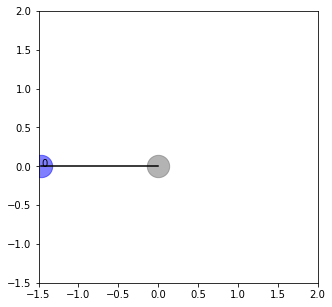

====0th kernel info====
0th-p_support:
torch.Size([1, 2])


0th-x_support:
tensor([[0.5975, 0.4170, 0.3530, 0.2282, 0.4133, 0.2874, 0.1686, 0.3803, 0.7736,
         0.6891, 0.1395, 0.3645, 0.5901, 0.9159, 0.2210, 0.7744, 0.2287, 0.5896,
         0.0839, 0.9484, 0.9142, 0.6234, 0.0583, 0.0994, 0.3288, 0.4621, 0.1078,
         0.7038, 0.7449, 0.1826, 0.1810, 0.3081, 0.0658, 0.4868, 0.8583, 0.4173,
         0.9608, 0.0133, 0.0122, 0.0657, 0.2637, 0.9100, 0.7898, 0.2157, 0.3271,
         0.5232, 0.7307, 0.4449, 0.3041, 0.1575, 0.5342, 0.2409, 0.7871, 0.7551,
         0.7555, 0.6113, 0.6786, 0.9037, 0.4774, 0.4729]])


0th-x_center:
tensor([[0.1099, 0.7867, 0.3077, 0.1823, 0.5577, 0.4647, 0.2366, 0.4093, 0.3829,
         0.3435, 0.0792, 0.9199, 0.2361, 0.0696, 0.2984, 0.5714, 0.9707, 0.7867,
         0.4668, 0.4466, 0.7549, 0.6416, 0.7038, 0.4581, 0.1707, 0.7467, 0.2951,
         0.6313, 0.1962, 0.8778, 0.8546, 0.6186, 0.4594, 0.4922, 0.5997, 0.8616,
         0.3595, 0.1096, 0.8984, 0.7479,

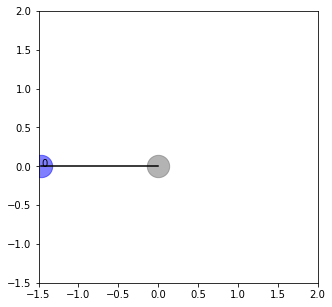

====1th kernel info====
1th-p_support:
torch.Size([1, 2])


1th-x_support:
tensor([[0.4555, 0.2483, 0.7949, 0.5094, 0.8882, 0.2464, 0.9303, 0.2327, 0.3399,
         0.6268, 0.8348, 0.2086, 0.1814, 0.2303, 0.3100, 0.8403, 0.1518, 0.7538,
         0.9281, 0.0217, 0.5668, 0.3722, 0.7105, 0.4560, 0.0548, 0.2289, 0.0447,
         0.9107, 0.3975, 0.1249, 0.8168, 0.3248, 0.8142, 0.4847, 0.0894, 0.9418,
         0.3224, 0.8543, 0.0540, 0.5843, 0.9609, 0.6304, 0.6942, 0.2718, 0.1515,
         0.6445, 0.6838, 0.2982, 0.3396, 0.3045, 0.0791, 0.6177, 0.3699, 0.3708,
         0.0880, 0.3196, 0.5084, 0.8086, 0.9367, 0.7669]])


1th-x_center:
tensor([[0.9308, 0.9793, 0.2482, 0.5929, 0.7867, 0.1655, 0.7663, 0.1629, 0.3000,
         0.7259, 0.2354, 0.3232, 0.0425, 0.2020, 0.6028, 0.0158, 0.0378, 0.9678,
         0.0554, 0.2995, 0.4516, 0.0673, 0.8376, 0.3106, 0.1451, 0.5013, 0.2485,
         0.7348, 0.3236, 0.2588, 0.9348, 0.7117, 0.2830, 0.6388, 0.1244, 0.6168,
         0.5963, 0.7213, 0.7471, 0.7319,

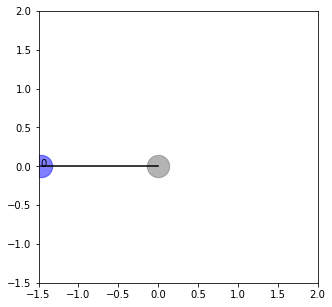

====2th kernel info====
2th-p_support:
torch.Size([1, 2])


2th-x_support:
tensor([[0.9293, 0.0433, 0.7624, 0.0392, 0.0454, 0.9126, 0.7622, 0.4165, 0.0970,
         0.0513, 0.2167, 0.1494, 0.8276, 0.5227, 0.5554, 0.5349, 0.2060, 0.2795,
         0.9685, 0.3885, 0.1140, 0.9331, 0.5517, 0.1133, 0.9616, 0.4705, 0.5326,
         0.3503, 0.5245, 0.6812, 0.9276, 0.9260, 0.0458, 0.3487, 0.0353, 0.5880,
         0.3323, 0.3981, 0.5538, 0.7545, 0.3782, 0.1753, 0.0344, 0.4766, 0.1554,
         0.4861, 0.8201, 0.7206, 0.9787, 0.1124, 0.6656, 0.8606, 0.4455, 0.6293,
         0.4561, 0.3503, 0.2818, 0.4641, 0.2227, 0.7210]])


2th-x_center:
tensor([[0.0751, 0.0908, 0.2486, 0.9740, 0.9704, 0.3440, 0.0212, 0.7130, 0.2224,
         0.6862, 0.6091, 0.2530, 0.7595, 0.0681, 0.7105, 0.4688, 0.3320, 0.4955,
         0.7538, 0.3567, 0.9462, 0.8911, 0.3909, 0.7948, 0.1730, 0.5131, 0.6473,
         0.9773, 0.4081, 0.0174, 0.7811, 0.1198, 0.4090, 0.8424, 0.0741, 0.6673,
         0.5345, 0.3633, 0.9452, 0.4310,

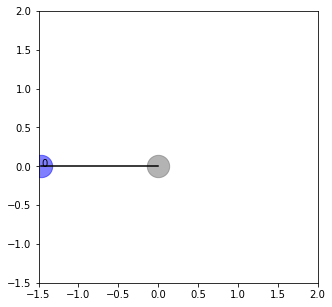

====3th kernel info====
3th-p_support:
torch.Size([1, 2])


3th-x_support:
tensor([[0.1618, 0.4146, 0.3704, 0.5454, 0.6703, 0.0147, 0.1049, 0.2627, 0.0593,
         0.9491, 0.9504, 0.2899, 0.3209, 0.6553, 0.9916, 0.2937, 0.9859, 0.5037,
         0.7392, 0.0364, 0.5596, 0.9122, 0.8372, 0.5641, 0.4925, 0.6267, 0.2353,
         0.5064, 0.1343, 0.3749, 0.3889, 0.0133, 0.7927, 0.7665, 0.2469, 0.2182,
         0.6664, 0.0274, 0.5761, 0.2889, 0.3106, 0.6107, 0.6140, 0.2244, 0.0178,
         0.6877, 0.7098, 0.1068, 0.9858, 0.5634, 0.6402, 0.3128, 0.2706, 0.7503,
         0.1527, 0.6158, 0.6893, 0.3577, 0.5191, 0.7938]])


3th-x_center:
tensor([[0.7779, 0.9556, 0.2210, 0.7656, 0.6012, 0.9485, 0.5183, 0.5960, 0.6262,
         0.5674, 0.1028, 0.2542, 0.9731, 0.6051, 0.2035, 0.4595, 0.0791, 0.3859,
         0.2623, 0.0352, 0.4330, 0.5247, 0.7203, 0.4476, 0.0681, 0.5589, 0.7598,
         0.8897, 0.0836, 0.3030, 0.4292, 0.3495, 0.6050, 0.3638, 0.4003, 0.9929,
         0.2477, 0.7473, 0.5016, 0.9123,

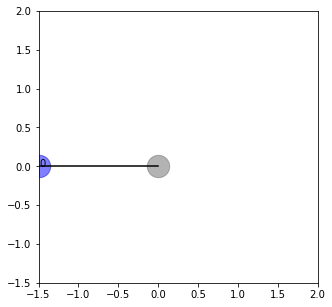

====4th kernel info====
4th-p_support:
torch.Size([1, 2])


4th-x_support:
tensor([[0.8678, 0.2349, 0.0772, 0.3671, 0.2266, 0.0741, 0.8351, 0.1102, 0.5329,
         0.6952, 0.3803, 0.3807, 0.5870, 0.1221, 0.2638, 0.1214, 0.7615, 0.6688,
         0.4083, 0.3828, 0.0245, 0.4537, 0.7817, 0.0924, 0.5008, 0.8325, 0.1240,
         0.1018, 0.5796, 0.7988, 0.1249, 0.3148, 0.9469, 0.9553, 0.6756, 0.1427,
         0.3033, 0.4855, 0.5595, 0.6682, 0.2110, 0.0632, 0.0450, 0.2614, 0.2804,
         0.1982, 0.0702, 0.1040, 0.9433, 0.9988, 0.5622, 0.1039, 0.0102, 0.9827,
         0.9211, 0.6971, 0.2317, 0.3150, 0.1162, 0.8734]])


4th-x_center:
tensor([[0.1567, 0.3367, 0.4522, 0.3272, 0.4041, 0.0042, 0.1273, 0.0373, 0.2244,
         0.9536, 0.0389, 0.3821, 0.4679, 0.8528, 0.9753, 0.1020, 0.3593, 0.6591,
         0.5185, 0.7363, 0.8258, 0.1023, 0.5164, 0.6288, 0.7719, 0.5067, 0.9079,
         0.3367, 0.4127, 0.4312, 0.7093, 0.8007, 0.8494, 0.2173, 0.1269, 0.5269,
         0.2937, 0.2752, 0.6346, 0.0335,

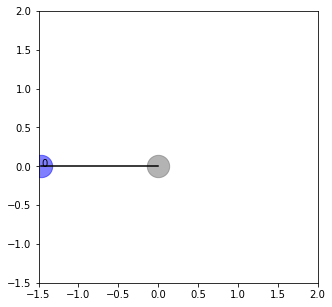

====5th kernel info====
5th-p_support:
torch.Size([1, 2])


5th-x_support:
tensor([[0.3953, 0.0889, 0.8319, 0.0826, 0.9907, 0.5997, 0.6408, 0.2949, 0.7825,
         0.1664, 0.2260, 0.0391, 0.9257, 0.0231, 0.2806, 0.2885, 0.5172, 0.4604,
         0.2981, 0.5572, 0.7692, 0.6314, 0.8103, 0.5865, 0.5050, 0.5129, 0.4638,
         0.8916, 0.2447, 0.8022, 0.0257, 0.0536, 0.8857, 0.7922, 0.0044, 0.0717,
         0.4829, 0.9490, 0.8555, 0.6492, 0.3112, 0.9010, 0.5913, 0.8032, 0.8101,
         0.9280, 0.4415, 0.1034, 0.9254, 0.0743, 0.1067, 0.6989, 0.4206, 0.0526,
         0.0372, 0.6121, 0.1698, 0.0930, 0.2852, 0.0864]])


5th-x_center:
tensor([[0.6645, 0.3078, 0.4477, 0.4993, 0.4115, 0.5691, 0.2732, 0.0475, 0.9935,
         0.3840, 0.0995, 0.6566, 0.5003, 0.5234, 0.0688, 0.1967, 0.2610, 0.8025,
         0.7584, 0.3873, 0.3128, 0.1244, 0.7600, 0.4549, 0.6574, 0.4695, 0.2671,
         0.0543, 0.7213, 0.0271, 0.2134, 0.9873, 0.4470, 0.2566, 0.6236, 0.6097,
         0.9639, 0.4470, 0.6006, 0.2282,

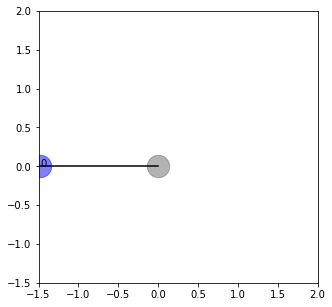

====6th kernel info====
6th-p_support:
torch.Size([1, 2])


6th-x_support:
tensor([[0.2610, 0.0787, 0.9245, 0.2417, 0.5762, 0.7904, 0.8937, 0.4814, 0.6086,
         0.4402, 0.0340, 0.0065, 0.3639, 0.6406, 0.4775, 0.2287, 0.3190, 0.6066,
         0.1183, 0.7160, 0.3880, 0.3385, 0.3926, 0.8103, 0.5565, 0.1877, 0.8756,
         0.7490, 0.3926, 0.4001, 0.8182, 0.5341, 0.5949, 0.0154, 0.9370, 0.6614,
         0.6272, 0.3270, 0.4851, 0.8455, 0.2303, 0.7161, 0.2500, 0.1319, 0.6943,
         0.9811, 0.7236, 0.9845, 0.3973, 0.7466, 0.9638, 0.3620, 0.1264, 0.8329,
         0.6479, 0.3292, 0.6206, 0.1738, 0.9838, 0.0076]])


6th-x_center:
tensor([[0.9711, 0.3564, 0.8487, 0.4226, 0.2791, 0.2322, 0.6652, 0.5187, 0.6632,
         0.7300, 0.9843, 0.9251, 0.3738, 0.1617, 0.5672, 0.1088, 0.7757, 0.0265,
         0.2110, 0.2340, 0.2436, 0.0013, 0.9362, 0.0554, 0.6168, 0.7965, 0.5832,
         0.3845, 0.4040, 0.3478, 0.7188, 0.7171, 0.9566, 0.6129, 0.6471, 0.4560,
         0.1036, 0.4540, 0.9609, 0.8684,

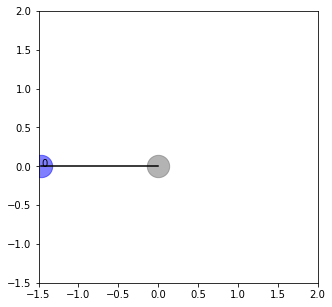

====7th kernel info====
7th-p_support:
torch.Size([1, 2])


7th-x_support:
tensor([[0.5249, 0.9806, 0.8192, 0.1221, 0.3837, 0.6362, 0.6255, 0.7155, 0.8257,
         0.1559, 0.4126, 0.7621, 0.6881, 0.4354, 0.2387, 0.5045, 0.3155, 0.6229,
         0.5884, 0.4120, 0.4604, 0.2727, 0.8329, 0.1468, 0.7781, 0.6634, 0.7098,
         0.7309, 0.6556, 0.9732, 0.1396, 0.8959, 0.1488, 0.8831, 0.8016, 0.8016,
         0.9076, 0.1743, 0.8843, 0.2395, 0.5807, 0.6025, 0.6220, 0.3196, 0.8564,
         0.9325, 0.3121, 0.9034, 0.4130, 0.2566, 0.3004, 0.5183, 0.7571, 0.2477,
         0.9181, 0.6274, 0.7637, 0.7268, 0.4335, 0.1130]])


7th-x_center:
tensor([[0.6652, 0.7819, 0.7944, 0.1108, 0.7689, 0.0552, 0.8161, 0.4231, 0.4143,
         0.8441, 0.4586, 0.5605, 0.7859, 0.9657, 0.7452, 0.6253, 0.0817, 0.9454,
         0.8534, 0.0012, 0.6710, 0.5547, 0.1396, 0.7620, 0.5296, 0.3022, 0.9693,
         0.8303, 0.6230, 0.7624, 0.6850, 0.8876, 0.7072, 0.5594, 0.4039, 0.1275,
         0.6723, 0.2175, 0.0612, 0.6637,

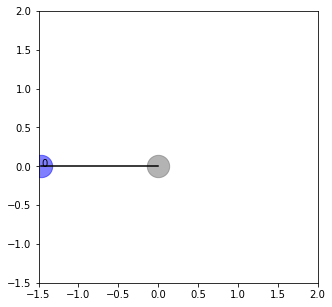

====8th kernel info====
8th-p_support:
torch.Size([1, 2])


8th-x_support:
tensor([[0.2550, 0.4501, 0.6793, 0.0750, 0.4780, 0.2170, 0.3906, 0.9181, 0.0137,
         0.7075, 0.4246, 0.9567, 0.3921, 0.6503, 0.8589, 0.1035, 0.1594, 0.9421,
         0.2898, 0.8448, 0.2040, 0.0306, 0.0145, 0.0429, 0.3953, 0.2477, 0.7384,
         0.5049, 0.1453, 0.9580, 0.6242, 0.9880, 0.5550, 0.5079, 0.2218, 0.9034,
         0.8590, 0.7942, 0.0393, 0.4686, 0.7115, 0.5214, 0.0828, 0.6325, 0.2281,
         0.4248, 0.3517, 0.9146, 0.5420, 0.1494, 0.0037, 0.1338, 0.0647, 0.4470,
         0.0234, 0.2938, 0.5420, 0.2526, 0.6698, 0.4348]])


8th-x_center:
tensor([[0.9694, 0.1158, 0.3083, 0.9685, 0.2202, 0.4249, 0.0242, 0.7056, 0.0245,
         0.5604, 0.4776, 0.8387, 0.3164, 0.3468, 0.6730, 0.7796, 0.0556, 0.6386,
         0.3876, 0.8864, 0.7779, 0.5292, 0.9266, 0.0520, 0.9199, 0.5756, 0.6862,
         0.0158, 0.7278, 0.9520, 0.9511, 0.4666, 0.1158, 0.1780, 0.7225, 0.3957,
         0.7228, 0.2157, 0.1897, 0.5073,

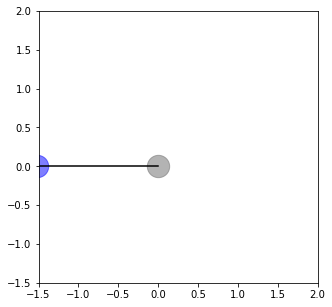

====9th kernel info====
9th-p_support:
torch.Size([1, 2])


9th-x_support:
tensor([[0.3746, 0.9128, 0.0638, 0.0182, 0.0992, 0.3919, 0.5820, 0.0035, 0.6879,
         0.2879, 0.7913, 0.3319, 0.0268, 0.3298, 0.6579, 0.4918, 0.3005, 0.5824,
         0.4145, 0.6960, 0.5178, 0.5887, 0.2969, 0.1195, 0.0060, 0.8213, 0.6568,
         0.9681, 0.4096, 0.5754, 0.7075, 0.0986, 0.7213, 0.1954, 0.3307, 0.1626,
         0.3323, 0.1599, 0.2451, 0.1628, 0.6629, 0.9830, 0.9387, 0.3252, 0.8403,
         0.1938, 0.4578, 0.4468, 0.3053, 0.3512, 0.2721, 0.0574, 0.7022, 0.7159,
         0.4989, 0.4062, 0.9420, 0.7491, 0.6790, 0.5982]])


9th-x_center:
tensor([[0.7188, 0.4917, 0.7005, 0.7645, 0.2101, 0.3969, 0.0665, 0.6268, 0.7331,
         0.3547, 0.0917, 0.7117, 0.0184, 0.3647, 0.0810, 0.5150, 0.6205, 0.6909,
         0.7711, 0.7124, 0.1293, 0.8800, 0.2087, 0.0478, 0.2105, 0.0108, 0.4533,
         0.1295, 0.3233, 0.1541, 0.6562, 0.2315, 0.7076, 0.1909, 0.2725, 0.1427,
         0.8218, 0.2754, 0.9988, 0.3318,

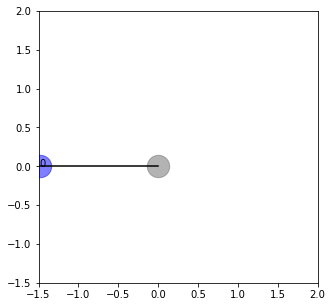

====10th kernel info====
10th-p_support:
torch.Size([1, 2])


10th-x_support:
tensor([[8.7362e-01, 3.2515e-01, 8.6756e-01, 1.0427e-01, 9.9680e-01, 8.3800e-04,
         5.6980e-01, 8.9176e-01, 3.5663e-01, 5.3045e-01, 4.6465e-01, 9.4811e-01,
         7.9762e-01, 1.0922e-01, 3.4862e-01, 9.2765e-01, 1.6777e-01, 1.1621e-01,
         2.0496e-01, 3.7863e-01, 5.2129e-01, 7.7625e-01, 6.0755e-02, 9.1471e-01,
         1.9561e-01, 4.5815e-01, 6.8023e-01, 7.0308e-02, 6.7110e-01, 6.3513e-01,
         8.8740e-01, 5.8622e-01, 7.2091e-01, 6.9948e-03, 9.8758e-01, 4.9541e-01,
         3.9006e-01, 1.0571e-01, 1.1672e-01, 2.4618e-01, 8.3641e-01, 6.0379e-01,
         6.3850e-01, 5.7682e-01, 8.5959e-01, 5.9413e-01, 4.6637e-01, 6.3311e-01,
         9.2849e-01, 6.9559e-01, 9.3451e-01, 9.1184e-01, 8.5583e-01, 2.2036e-01,
         5.2067e-01, 4.8556e-01, 5.4078e-01, 5.1884e-01, 3.5269e-01, 8.2828e-01]])


10th-x_center:
tensor([[0.0467, 0.1065, 0.1158, 0.3295, 0.1591, 0.3245, 0.5063, 0.4352, 0.1815,
         0.4

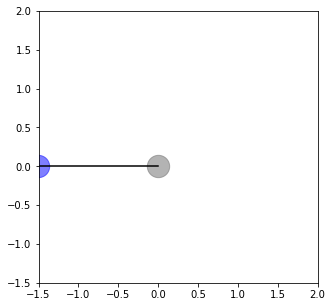

====11th kernel info====
11th-p_support:
torch.Size([1, 2])


11th-x_support:
tensor([[0.6065, 0.7835, 0.9670, 0.3641, 0.8559, 0.4508, 0.7570, 0.9228, 0.4972,
         0.4169, 0.9872, 0.5526, 0.3786, 0.5267, 0.9969, 0.2183, 0.3069, 0.0389,
         0.8420, 0.6942, 0.0568, 0.4434, 0.6707, 0.8073, 0.8412, 0.4662, 0.3884,
         0.8812, 0.6869, 0.8609, 0.3166, 0.0255, 0.6271, 0.4924, 0.5351, 0.3883,
         0.1568, 0.1909, 0.7163, 0.5016, 0.2828, 0.2365, 0.1892, 0.5822, 0.6046,
         0.1301, 0.5550, 0.6829, 0.0433, 0.1875, 0.0871, 1.0008, 0.1384, 0.8223,
         0.8021, 0.3154, 0.1588, 0.2382, 0.6952, 0.7118]])


11th-x_center:
tensor([[0.5137, 0.7344, 0.9639, 0.5612, 0.6152, 0.3968, 0.6524, 0.5465, 0.7675,
         0.7764, 0.9698, 0.4677, 0.6971, 0.0512, 0.9100, 0.5688, 0.6455, 0.4706,
         0.4968, 0.2848, 0.5828, 0.6121, 0.7835, 0.7285, 0.8244, 0.7823, 0.3128,
         0.6844, 0.6430, 0.2528, 0.8004, 0.2772, 0.8505, 0.0432, 0.4032, 0.9062,
         0.1704, 0.4263, 0.3858, 0.7

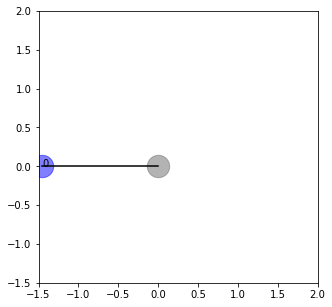

====12th kernel info====
12th-p_support:
torch.Size([1, 2])


12th-x_support:
tensor([[0.3228, 0.9311, 0.5763, 0.0536, 0.9607, 0.2127, 0.3316, 0.0097, 0.4951,
         0.7616, 0.6011, 0.6667, 0.9146, 0.2168, 0.6410, 0.4823, 0.8479, 0.1895,
         0.7147, 0.0613, 0.6704, 0.4061, 0.0292, 0.1759, 0.7332, 0.2413, 0.5588,
         0.7124, 0.9719, 0.8255, 0.9376, 0.4194, 0.9188, 0.0179, 0.9364, 0.1821,
         0.0620, 0.4392, 0.9384, 0.6689, 0.3960, 0.4528, 0.5987, 0.4269, 0.9281,
         0.4577, 0.9081, 0.0678, 0.3377, 0.1079, 0.0396, 0.2059, 0.8394, 0.2510,
         0.6053, 0.4526, 0.5930, 0.8847, 0.9028, 0.3789]])


12th-x_center:
tensor([[0.8008, 0.2817, 0.4458, 0.2597, 0.6830, 0.1863, 0.9591, 0.2430, 0.4771,
         0.0740, 0.4194, 0.6061, 0.8775, 0.5792, 0.7032, 0.3106, 0.3410, 0.4468,
         0.9790, 0.9043, 0.1472, 0.0405, 0.1123, 0.2488, 0.1925, 0.9649, 0.2626,
         0.9242, 0.3566, 0.2712, 0.4652, 0.3875, 0.7583, 0.1066, 0.5579, 0.9181,
         0.5910, 0.9472, 0.1459, 0.6

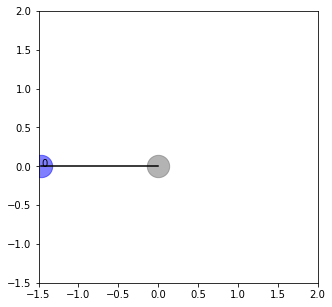

====13th kernel info====
13th-p_support:
torch.Size([1, 2])


13th-x_support:
tensor([[0.8187, 0.6445, 0.8826, 0.9470, 0.4389, 0.6923, 0.2570, 0.8134, 0.3421,
         0.3611, 0.2177, 0.5484, 0.6924, 0.4680, 0.5458, 0.5335, 0.0142, 0.0038,
         0.6932, 0.6028, 0.4144, 0.4760, 0.4557, 0.8630, 0.9888, 0.0861, 0.9002,
         0.5112, 0.6034, 0.9485, 0.1526, 0.3049, 0.3969, 0.0612, 0.5957, 0.5101,
         0.9839, 0.8890, 0.6835, 0.0711, 0.6406, 0.3758, 0.1191, 0.0270, 0.3399,
         0.8617, 0.0749, 0.5138, 0.4226, 0.3335, 0.7253, 0.3963, 0.5131, 0.7912,
         0.0746, 0.8354, 0.6384, 0.3766, 0.9948, 0.9649]])


13th-x_center:
tensor([[0.7248, 0.5487, 0.1927, 0.2365, 0.6831, 0.2301, 0.7314, 0.8513, 0.0722,
         0.5935, 0.5753, 0.3762, 0.6458, 0.1460, 0.0024, 0.3356, 0.0248, 0.0846,
         0.1725, 0.4159, 0.8620, 0.8937, 0.1253, 0.1446, 0.2321, 0.4611, 0.7452,
         0.1810, 0.7759, 0.3141, 0.6175, 0.3226, 0.7319, 0.5329, 0.4428, 0.1657,
         0.5449, 0.1445, 0.3983, 0.1

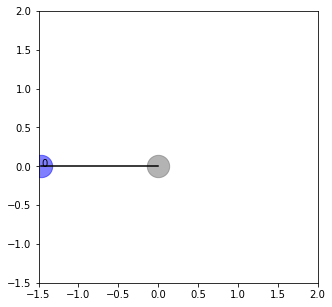

====14th kernel info====
14th-p_support:
torch.Size([1, 2])


14th-x_support:
tensor([[0.1771, 0.3717, 0.1492, 0.6631, 0.5638, 0.1640, 0.7601, 0.6249, 0.7011,
         0.6160, 0.0340, 0.0132, 0.6725, 0.6183, 0.8826, 0.3628, 0.6214, 0.6002,
         0.2678, 0.4585, 0.6895, 0.6605, 0.9327, 0.6370, 0.8641, 0.4203, 0.5922,
         0.7449, 0.4492, 0.3078, 0.8275, 0.1663, 0.1507, 0.6600, 0.6773, 0.7600,
         0.2568, 0.6454, 0.0561, 0.0831, 0.2829, 0.3476, 0.7154, 0.4388, 0.0393,
         0.7901, 0.6772, 0.3652, 0.8967, 0.9912, 0.2378, 0.9335, 0.9792, 0.7642,
         0.8648, 0.7862, 0.7930, 0.3941, 0.5712, 0.7802]])


14th-x_center:
tensor([[0.5750, 0.3662, 0.0638, 0.4644, 0.5217, 0.8942, 0.8768, 0.7581, 0.9930,
         0.1330, 0.6821, 0.2373, 0.3716, 0.6830, 0.0829, 0.3973, 0.0179, 0.5746,
         0.0853, 0.6144, 0.6783, 0.5540, 0.5203, 0.0028, 0.6998, 0.4694, 0.6895,
         0.7765, 0.6825, 0.4840, 0.8950, 0.3655, 0.0392, 0.4654, 0.1030, 0.9454,
         0.4694, 0.2840, 0.2838, 0.2

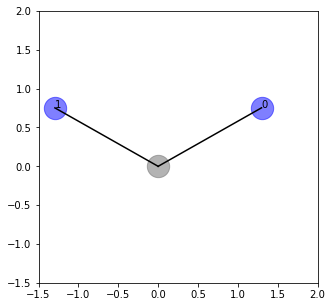

====0th kernel info====
0th-p_support:
torch.Size([2, 2])


0th-x_support:
tensor([[0.6658, 0.0523, 0.6588, 0.7229, 0.1985, 0.2749, 0.9366, 0.5317, 0.8772,
         0.0399, 0.1562, 0.6564, 0.4184, 0.1548, 0.6160, 0.9479, 0.6624, 0.1342,
         0.3348, 0.3318, 0.5464, 0.1639, 0.5742, 0.8694, 0.9269, 0.9210, 0.5479,
         0.1020, 0.6095, 0.9680, 0.8535, 0.8040, 0.4703, 0.6828, 0.6086, 0.5396,
         0.4467, 0.3865, 0.2946, 0.5836, 0.9351, 0.9580, 0.4816, 0.5474, 0.2520,
         0.4742, 0.7940, 0.1802, 0.2621, 0.0785, 0.1831, 0.3358, 0.0474, 0.2713,
         0.8003, 0.6212, 0.8967, 0.4236, 0.8639, 0.8386],
        [0.6195, 0.5033, 0.6488, 0.4549, 0.9928, 0.5246, 0.9403, 0.3306, 0.2787,
         0.5126, 0.8831, 0.7582, 0.9661, 0.2356, 0.0043, 0.9177, 0.9258, 0.1362,
         0.9352, 0.9907, 0.9833, 0.4158, 0.8902, 0.0033, 0.3282, 0.6018, 0.1820,
         0.4535, 0.6632, 0.0640, 0.6980, 0.2087, 0.3767, 0.2491, 0.6026, 0.1109,
         0.8399, 0.8411, 0.5278, 0.7873, 0.4783, 0.2423, 

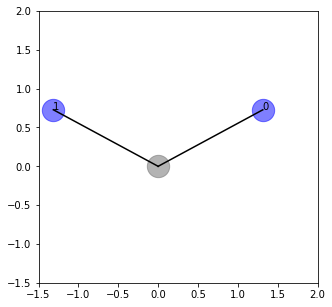

====1th kernel info====
1th-p_support:
torch.Size([2, 2])


1th-x_support:
tensor([[0.9523, 0.2726, 0.5894, 0.7148, 0.5260, 0.3102, 0.5369, 0.8906, 0.9935,
         0.8407, 0.9901, 0.4490, 0.0361, 0.1542, 0.2426, 0.6698, 0.8397, 0.1676,
         0.6168, 0.5554, 0.9046, 0.0912, 0.7335, 0.8648, 0.2096, 0.1593, 0.0168,
         0.8674, 0.9446, 0.5229, 0.9800, 0.1267, 0.4425, 0.8726, 0.4805, 0.3891,
         0.4274, 0.5415, 0.6633, 0.3379, 0.4711, 0.5291, 0.7387, 0.9814, 0.7223,
         0.1495, 0.5058, 0.9127, 0.4488, 0.2265, 0.2686, 0.9699, 0.9565, 0.0073,
         0.1820, 0.5369, 0.8238, 0.2660, 0.6333, 0.8132],
        [0.7544, 0.9786, 0.6366, 0.3683, 0.2428, 0.8907, 0.1735, 0.9540, 0.1291,
         0.8042, 0.8392, 0.4997, 0.7138, 0.0366, 0.2547, 0.2130, 0.5307, 0.7057,
         0.4698, 0.0609, 0.1258, 0.4623, 0.7454, 0.6691, 0.1266, 0.5507, 0.8158,
         0.8100, 0.9227, 0.0227, 0.7091, 0.7886, 0.0417, 0.7267, 0.1524, 0.3421,
         0.2903, 0.4105, 0.6036, 0.7897, 0.6838, 0.9810, 

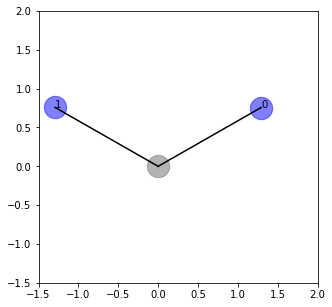

====2th kernel info====
2th-p_support:
torch.Size([2, 2])


2th-x_support:
tensor([[0.8183, 0.2067, 0.2801, 0.8078, 0.3260, 0.4582, 0.1293, 0.6557, 0.4908,
         0.5113, 0.4606, 0.9976, 0.9256, 0.3657, 0.4313, 0.6207, 0.4625, 0.9161,
         0.6675, 0.2957, 0.9603, 0.3405, 0.3432, 0.5698, 0.9758, 0.0255, 0.3425,
         0.8962, 0.2399, 0.6289, 0.1340, 0.7097, 0.0830, 0.1147, 0.5137, 0.8749,
         0.9566, 0.2861, 0.0743, 0.2242, 0.3448, 0.1604, 0.3128, 0.7387, 0.6625,
         0.3668, 0.8086, 0.0617, 0.4529, 0.6684, 0.5293, 0.9761, 0.1640, 0.7590,
         0.3942, 0.3132, 0.8733, 0.6100, 0.7094, 0.0925],
        [0.8319, 0.3741, 0.2953, 0.2958, 0.1489, 0.8035, 0.0404, 0.8065, 0.1355,
         0.6304, 0.7647, 0.8813, 0.4630, 0.0258, 0.7303, 0.5467, 0.3001, 0.0567,
         0.8222, 0.3623, 0.8579, 0.1723, 0.9368, 0.7854, 0.7375, 0.2844, 0.9909,
         0.0097, 0.7019, 0.5825, 0.9982, 0.4363, 0.2895, 0.8351, 0.7857, 0.5756,
         0.0903, 0.7969, 0.0886, 0.5515, 0.0388, 0.7181, 

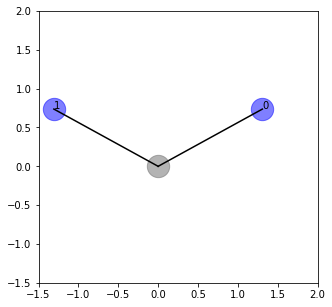

====3th kernel info====
3th-p_support:
torch.Size([2, 2])


3th-x_support:
tensor([[0.0539, 0.3004, 0.9257, 0.8800, 0.9905, 0.9112, 0.0851, 0.8582, 0.2177,
         0.5478, 0.5632, 0.6184, 0.8878, 0.7931, 0.4791, 0.0358, 0.8131, 0.0302,
         0.2392, 0.2059, 0.1589, 0.7634, 0.9860, 0.2724, 0.7989, 0.5924, 0.4298,
         0.9581, 0.0766, 0.8943, 0.4747, 0.3908, 0.0580, 0.7155, 0.4537, 0.7511,
         0.1535, 0.7074, 0.6530, 0.1520, 0.0752, 0.3773, 0.7463, 0.1177, 0.0261,
         0.1958, 0.4974, 0.6424, 0.7280, 0.0928, 0.9723, 0.6718, 0.9765, 0.0549,
         0.7705, 0.6900, 0.4395, 0.8468, 0.0310, 0.1880],
        [0.8569, 0.6120, 0.8597, 0.2058, 0.4245, 0.8696, 0.0227, 0.3454, 0.6075,
         0.4026, 0.5972, 0.8373, 0.3969, 0.6864, 0.2456, 0.7157, 0.9867, 0.2478,
         0.6900, 0.0593, 0.4931, 0.7421, 0.3183, 0.8187, 0.7813, 0.5800, 0.8666,
         0.0657, 0.6559, 0.5594, 0.1979, 0.1826, 0.2982, 0.8443, 0.7990, 0.4062,
         0.8895, 0.7782, 0.2931, 0.8816, 0.5417, 0.5261, 

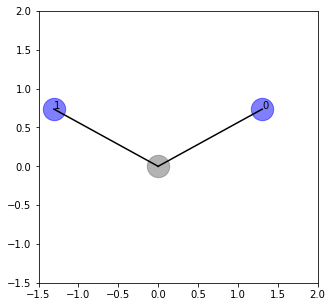

====4th kernel info====
4th-p_support:
torch.Size([2, 2])


4th-x_support:
tensor([[0.3867, 0.0311, 0.1983, 0.3750, 0.0894, 0.6075, 0.3996, 0.7482, 0.7826,
         0.3417, 0.7092, 0.2696, 0.9712, 0.9096, 0.1755, 0.3982, 0.9696, 0.3797,
         0.7529, 0.9247, 0.9429, 0.9708, 0.9915, 0.4997, 0.0895, 0.2669, 0.0273,
         0.2900, 0.7991, 0.2727, 0.6858, 0.2807, 0.3379, 0.5665, 0.6744, 0.7878,
         0.0287, 0.2308, 0.0069, 0.0862, 0.6008, 0.4136, 0.9792, 0.1522, 0.7753,
         0.9563, 0.9685, 0.3763, 0.5869, 0.9069, 0.6869, 0.6903, 0.6515, 0.7266,
         0.7658, 0.7436, 0.8028, 0.3905, 0.5303, 0.5350],
        [0.6580, 0.8746, 0.9422, 0.3248, 0.6791, 0.4509, 0.9797, 0.5854, 0.2586,
         0.7808, 0.6045, 0.0851, 0.6829, 0.9068, 0.0332, 0.1135, 0.1890, 0.8034,
         0.7906, 0.8560, 0.7535, 0.9470, 0.2405, 0.8161, 0.6283, 0.5619, 0.1888,
         0.7454, 0.4738, 0.4633, 0.0156, 0.4199, 0.8103, 0.9278, 0.3307, 0.6606,
         0.3353, 0.7097, 0.3048, 0.1812, 0.9545, 0.2550, 

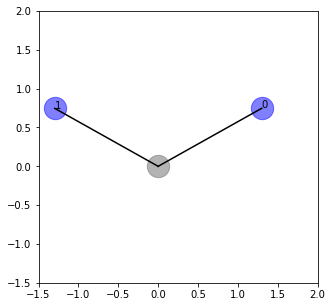

====5th kernel info====
5th-p_support:
torch.Size([2, 2])


5th-x_support:
tensor([[0.8592, 0.6583, 0.5737, 0.5547, 0.6594, 0.0483, 0.1385, 0.8850, 0.3783,
         0.6371, 0.9503, 0.4723, 0.8277, 0.3416, 0.5602, 0.8833, 0.7287, 0.0648,
         0.5245, 0.9876, 0.4686, 0.0375, 0.8898, 0.7902, 0.2775, 0.9321, 0.9357,
         0.4875, 0.5767, 0.1160, 0.4164, 0.0761, 0.9327, 0.2577, 0.3817, 0.6494,
         0.9675, 0.9990, 0.8560, 0.2410, 0.7580, 0.4573, 0.8000, 0.1724, 0.7672,
         0.8729, 0.4893, 0.9593, 0.8131, 0.6703, 0.9170, 0.8577, 0.7652, 0.9698,
         0.1847, 0.4969, 0.7214, 0.4827, 0.2923, 0.6745],
        [0.9710, 0.4955, 0.0048, 0.4686, 0.5604, 0.1210, 0.1470, 0.2422, 0.3343,
         0.0948, 0.0866, 0.6496, 0.7707, 0.8281, 0.5505, 0.1634, 0.1660, 0.4829,
         0.9713, 0.0604, 0.4090, 0.4058, 0.7278, 0.1484, 0.4303, 0.9103, 0.8433,
         0.5492, 0.2150, 0.5709, 0.9971, 0.4592, 0.4097, 0.4024, 0.8250, 0.5294,
         0.9748, 0.7683, 0.0012, 0.0139, 0.6827, 0.7448, 

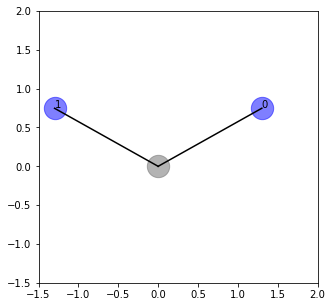

====6th kernel info====
6th-p_support:
torch.Size([2, 2])


6th-x_support:
tensor([[0.8197, 0.7753, 0.0393, 0.3810, 0.3349, 0.4326, 0.3427, 0.6471, 0.2717,
         0.3996, 0.4785, 0.1222, 0.3425, 0.5578, 0.4820, 0.6327, 0.5933, 0.0248,
         0.7199, 0.3581, 0.8380, 0.2099, 0.7231, 0.7668, 0.6003, 0.2088, 0.1360,
         0.4343, 0.2171, 0.2578, 0.1494, 0.9433, 0.6969, 0.1593, 0.9461, 0.5194,
         0.4652, 0.8949, 0.8326, 0.8134, 0.4971, 0.1767, 0.3369, 0.5795, 0.1020,
         0.2330, 0.2293, 0.4713, 0.7665, 0.6987, 0.8850, 0.0069, 0.6926, 0.3121,
         0.6547, 0.2509, 0.8957, 0.2043, 0.4456, 0.2670],
        [0.1911, 0.8866, 0.1967, 0.1238, 0.6266, 0.8869, 0.5145, 0.5332, 0.3671,
         0.6344, 0.9679, 0.1279, 0.6455, 0.8906, 0.6258, 0.0127, 0.4646, 0.4398,
         0.5922, 0.8007, 0.6415, 0.3716, 0.9349, 0.6773, 0.4774, 0.4208, 0.6585,
         0.5402, 0.8933, 0.6523, 0.3860, 0.3694, 0.7057, 0.3070, 0.7276, 0.6909,
         0.0958, 0.4893, 0.6964, 0.7912, 0.4634, 0.6684, 

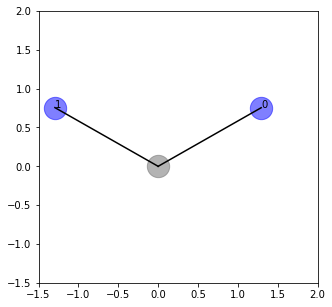

====7th kernel info====
7th-p_support:
torch.Size([2, 2])


7th-x_support:
tensor([[0.0073, 0.5561, 0.3478, 0.7876, 0.2859, 0.3622, 0.7784, 0.6527, 0.1983,
         0.4698, 0.5134, 0.2172, 0.0536, 0.7380, 0.0910, 0.6619, 0.7360, 0.9445,
         0.9396, 0.3801, 0.3759, 0.6826, 0.9726, 0.3508, 0.3904, 0.7944, 0.2049,
         0.7042, 0.1859, 0.9467, 0.2044, 0.9177, 0.4518, 0.5640, 0.5981, 0.0653,
         0.6672, 0.0051, 0.0960, 0.1238, 0.6030, 0.3022, 0.5192, 0.3962, 0.9698,
         0.0229, 0.4422, 0.9757, 0.7456, 0.4132, 0.3041, 0.7551, 0.7732, 0.5574,
         0.5708, 0.6905, 0.6642, 0.5139, 0.6138, 0.6298],
        [0.2793, 0.4842, 0.4306, 0.0583, 0.8158, 0.6706, 0.5993, 0.4955, 0.9181,
         0.2926, 0.9373, 0.7070, 0.6616, 0.6383, 0.5590, 0.0145, 0.3500, 0.4907,
         0.2469, 0.2718, 0.4352, 0.5744, 0.3001, 0.9138, 0.7925, 0.6884, 0.9681,
         0.5394, 0.7678, 0.8818, 0.7439, 0.7861, 0.9444, 0.3255, 0.5010, 0.5724,
         0.6589, 0.3889, 0.3447, 0.9870, 0.5529, 0.4423, 

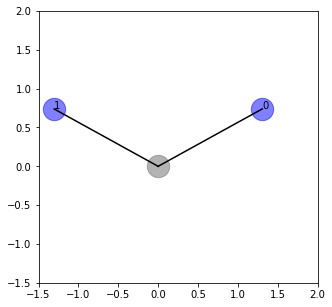

====8th kernel info====
8th-p_support:
torch.Size([2, 2])


8th-x_support:
tensor([[0.3138, 0.6021, 0.2149, 0.3728, 0.8450, 0.4160, 0.7150, 0.4011, 0.1004,
         0.2234, 0.3138, 0.7491, 0.7663, 0.0260, 0.5861, 0.7853, 0.4819, 0.7897,
         0.0116, 0.9914, 0.8841, 0.0686, 0.8554, 0.8105, 0.8560, 0.0947, 0.5419,
         0.9111, 0.5589, 0.3847, 0.9142, 0.8083, 0.5976, 0.6075, 0.7706, 0.1159,
         0.9132, 0.6254, 0.7239, 0.0362, 0.3562, 0.1208, 0.0949, 0.8128, 0.8104,
         0.2226, 0.9285, 0.4117, 0.4380, 0.5016, 0.7948, 0.4924, 0.4830, 0.5362,
         0.6419, 0.6102, 0.1476, 0.8506, 0.7070, 0.7511],
        [0.9476, 0.8495, 0.9071, 0.9541, 0.8474, 0.9891, 0.0173, 0.9183, 0.7019,
         0.6001, 0.0838, 0.9627, 0.2200, 0.8127, 0.0743, 0.1947, 0.5764, 0.1632,
         0.1348, 0.5625, 0.9419, 0.7716, 0.2652, 0.6656, 0.9435, 0.8267, 0.4779,
         0.6761, 0.9355, 0.4711, 0.3632, 0.5556, 0.3853, 0.7162, 0.2548, 0.0069,
         0.3994, 0.0683, 0.9180, 0.9471, 0.1813, 0.4144, 

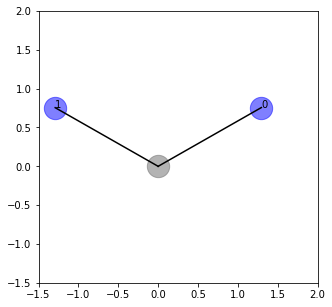

====9th kernel info====
9th-p_support:
torch.Size([2, 2])


9th-x_support:
tensor([[2.7308e-01, 5.6359e-01, 2.6353e-01, 5.6570e-01, 3.5224e-01, 8.1968e-01,
         1.1680e-02, 6.7967e-01, 8.4908e-01, 3.3228e-01, 9.0806e-01, 5.0122e-01,
         4.1376e-01, 1.3173e-01, 9.4402e-01, 2.6215e-01, 3.9813e-01, 5.9372e-01,
         2.2034e-01, 6.1781e-01, 5.4602e-01, 8.3249e-01, 5.7111e-01, 4.0678e-02,
         2.5777e-01, 6.0797e-01, 2.7404e-01, 3.0489e-01, 6.6469e-01, 6.5747e-01,
         2.9019e-01, 3.5886e-01, 9.2921e-01, 9.9606e-01, 4.4276e-01, 4.3079e-01,
         3.1600e-01, 1.9044e-01, 7.6054e-01, 5.3328e-01, 4.5383e-01, 7.5219e-01,
         6.0439e-01, 8.7748e-01, 8.0582e-01, 1.9513e-01, 9.5682e-02, 9.3742e-01,
         9.6643e-01, 4.9500e-01, 5.2404e-01, 6.2953e-01, 1.2340e-01, 9.8845e-01,
         6.7178e-01, 3.7505e-01, 5.1836e-01, 5.8200e-01, 1.4349e-02, 9.6533e-01],
        [9.6123e-01, 3.8719e-01, 6.0834e-01, 4.4572e-01, 3.8786e-01, 1.2095e-01,
         3.9000e-01, 1.3709e-01, 

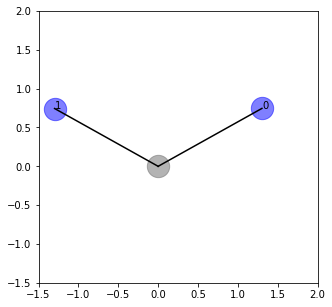

====10th kernel info====
10th-p_support:
torch.Size([2, 2])


10th-x_support:
tensor([[0.5192, 0.6164, 0.8053, 0.8105, 0.6791, 0.3616, 0.4734, 0.9721, 0.7761,
         0.8707, 0.8666, 0.4169, 0.7670, 0.3005, 0.5226, 0.5330, 0.1954, 0.7569,
         0.4938, 0.6263, 0.3145, 0.2954, 0.1857, 0.6392, 0.2026, 0.1168, 0.8987,
         0.9697, 0.6793, 0.7570, 0.5533, 0.3310, 0.9845, 0.2517, 0.3654, 0.5538,
         0.5271, 0.5106, 0.4716, 0.0071, 0.2619, 0.3966, 0.4350, 0.9147, 0.7083,
         0.5321, 0.5401, 0.9695, 0.2991, 0.7065, 0.8275, 0.4466, 0.7227, 0.1294,
         0.6255, 0.3133, 0.0723, 0.8417, 0.2151, 0.9110],
        [0.5553, 0.6040, 0.1027, 0.7769, 0.7091, 0.3960, 0.0953, 0.6546, 0.4806,
         0.2955, 0.8982, 0.0822, 0.7901, 0.2633, 0.0039, 0.8188, 0.0153, 0.3876,
         0.2773, 0.2861, 0.1423, 0.7882, 0.5973, 0.9311, 0.3524, 0.4612, 0.2712,
         0.2047, 0.0692, 0.7954, 0.8499, 0.0967, 0.1225, 0.8510, 0.2267, 0.8184,
         0.8868, 0.7852, 0.9325, 0.1646, 0.4320, 0.615

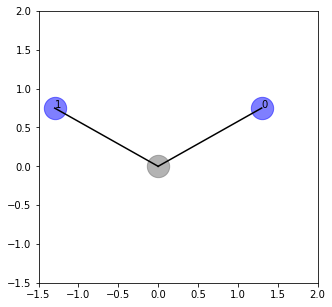

====11th kernel info====
11th-p_support:
torch.Size([2, 2])


11th-x_support:
tensor([[8.5617e-01, 4.1525e-01, 9.5813e-01, 1.6502e-01, 5.5546e-01, 2.6155e-01,
         4.4026e-01, 4.2657e-01, 7.0813e-01, 2.1546e-01, 2.0596e-01, 8.5026e-01,
         9.0607e-01, 7.2174e-01, 3.6008e-01, 5.8609e-01, 8.3831e-01, 5.6978e-01,
         6.6209e-01, 3.6708e-02, 4.0221e-01, 6.5997e-01, 3.9701e-01, 8.8721e-01,
         5.4295e-01, 9.8827e-01, 9.4507e-02, 2.0236e-01, 6.5327e-01, 2.6458e-01,
         9.9820e-01, 5.2092e-01, 7.2681e-01, 5.7813e-01, 9.9939e-01, 9.1573e-02,
         9.6632e-01, 6.5765e-01, 9.8118e-01, 7.9812e-01, 3.5140e-01, 1.5400e-01,
         2.6134e-01, 1.1834e-01, 8.7268e-01, 7.4915e-01, 4.6755e-01, 6.8202e-01,
         4.7371e-01, 7.0732e-01, 3.0685e-01, 7.1012e-01, 9.3769e-01, 7.8906e-01,
         2.5236e-01, 9.4941e-01, 9.4832e-02, 6.8910e-01, 7.2640e-01, 5.7922e-01],
        [9.2548e-01, 7.3793e-01, 8.2006e-01, 8.0629e-01, 7.0958e-01, 5.7259e-01,
         2.5798e-01, 7.3277e-0

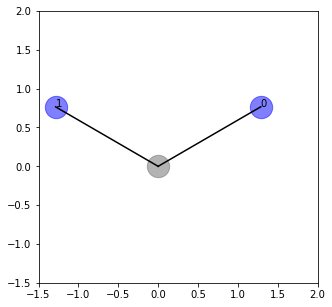

====12th kernel info====
12th-p_support:
torch.Size([2, 2])


12th-x_support:
tensor([[0.4663, 0.4989, 0.6250, 0.1828, 0.8362, 0.4135, 0.8167, 0.5859, 0.5077,
         0.4061, 0.5515, 0.5357, 0.6405, 0.5500, 0.7539, 0.0350, 0.7557, 0.3429,
         0.6046, 0.2004, 0.3466, 0.3783, 0.9676, 0.8615, 0.8174, 0.8301, 0.2932,
         0.2125, 0.6965, 0.1945, 0.8549, 0.2737, 0.8832, 0.0511, 0.3825, 0.1504,
         0.3954, 0.4925, 0.4241, 0.8014, 0.8740, 0.5942, 0.8080, 0.7980, 0.7349,
         0.5179, 0.6554, 0.3870, 0.6186, 0.8187, 0.6326, 0.9718, 0.7441, 0.3487,
         0.8414, 0.8086, 0.2385, 0.8531, 0.9065, 0.8630],
        [0.6474, 0.7165, 0.1297, 0.0236, 0.3643, 0.4424, 0.1696, 0.6471, 0.5588,
         0.2728, 0.8312, 0.5239, 0.3981, 0.8779, 0.6413, 0.2586, 0.8770, 0.2370,
         0.8043, 0.3493, 0.5537, 0.9413, 0.7724, 0.4818, 0.0074, 0.2295, 0.2159,
         0.7290, 0.3717, 0.4027, 0.1884, 0.7212, 0.1208, 0.4069, 0.3796, 0.9754,
         0.5246, 0.6962, 0.2766, 0.7803, 0.4744, 0.458

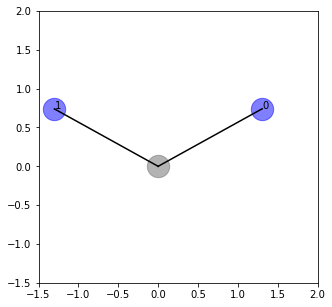

====13th kernel info====
13th-p_support:
torch.Size([2, 2])


13th-x_support:
tensor([[0.4098, 0.1858, 0.4673, 0.7260, 0.8605, 0.4703, 0.4326, 0.4704, 0.4808,
         0.6364, 0.9140, 0.5416, 0.9421, 0.9412, 0.5996, 0.2391, 0.7185, 0.9221,
         0.8624, 0.5698, 0.1274, 0.4918, 0.2535, 0.5980, 0.5881, 0.9651, 0.9596,
         0.1025, 0.7362, 0.2071, 0.9130, 0.4981, 0.9348, 0.4457, 0.3343, 0.6932,
         0.7782, 0.0117, 0.5786, 0.7582, 0.6277, 0.7536, 0.8447, 0.3632, 0.8861,
         0.8184, 0.2673, 0.4958, 0.9653, 0.5275, 0.7611, 0.6805, 0.3013, 0.5307,
         0.2688, 0.9686, 0.8052, 0.2279, 0.5174, 0.7685],
        [0.4623, 0.4328, 0.8658, 0.6597, 0.6899, 0.0073, 0.2910, 0.2623, 0.1293,
         0.1847, 0.0578, 0.0100, 0.1177, 0.4516, 0.8689, 0.5059, 0.7916, 0.7856,
         0.8033, 0.2563, 0.7391, 0.0827, 0.4923, 0.5191, 0.7459, 0.5024, 0.2669,
         0.2610, 0.2671, 0.0417, 0.5618, 0.5723, 0.3153, 0.7422, 0.2155, 0.1998,
         0.1861, 0.6254, 0.4610, 0.8871, 0.4356, 0.844

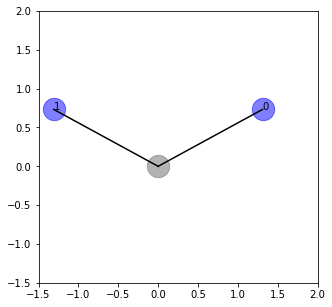

====14th kernel info====
14th-p_support:
torch.Size([2, 2])


14th-x_support:
tensor([[0.1569, 0.1454, 0.6786, 0.7648, 0.8705, 0.4367, 0.2745, 0.1316, 0.3551,
         0.9568, 0.5045, 0.1847, 0.3624, 0.6466, 0.6857, 0.7741, 0.7835, 0.6614,
         0.0793, 0.9053, 0.5918, 0.2437, 0.9369, 0.1239, 0.4232, 0.7268, 0.8306,
         0.3284, 0.3033, 0.7418, 0.4535, 0.1033, 0.7992, 0.0149, 0.7086, 0.2942,
         0.5544, 0.5852, 0.1151, 0.7130, 0.3253, 0.0304, 0.5721, 0.6544, 0.2881,
         0.7119, 0.0411, 0.9175, 0.0268, 0.9329, 0.4130, 0.9304, 0.3467, 0.3523,
         0.6978, 0.7737, 0.2104, 0.8610, 0.5084, 0.0778],
        [0.0620, 0.7567, 0.1342, 0.1526, 0.4387, 0.3298, 0.4471, 0.8365, 0.6277,
         0.9339, 0.2716, 0.5745, 0.1800, 0.2839, 0.7081, 0.1262, 0.5144, 0.1484,
         0.2885, 0.5868, 0.8115, 0.4826, 0.4700, 0.0385, 0.4935, 0.7108, 0.8742,
         0.8928, 0.5999, 0.2842, 0.8322, 0.5692, 0.7372, 0.4618, 0.2651, 0.7197,
         0.8927, 0.4364, 0.1325, 0.6778, 0.3409, 0.421

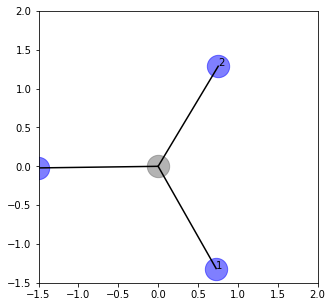

====0th kernel info====
0th-p_support:
torch.Size([3, 2])


0th-x_support:
tensor([[0.0686, 0.6801, 0.0361, 0.5759, 0.9638, 0.5178, 0.5063, 0.3504, 0.6794,
         0.9798, 0.0334, 0.3719, 0.7627, 0.1970, 0.0783, 0.1080, 0.8414, 0.1732,
         0.1618, 0.2851, 0.0330, 0.7083, 0.6861, 0.7337, 0.7078, 0.9406, 0.4335,
         0.4999, 0.0426, 0.9098, 0.6658, 0.8896, 0.5434, 0.6363, 0.5188, 0.9438,
         0.9944, 0.0627, 0.5323, 0.2112, 0.2971, 0.9527, 0.4498, 0.0993, 0.7560,
         0.7731, 0.4324, 0.2486, 0.8822, 0.8809, 0.8046, 0.7394, 0.5438, 0.2991,
         0.6996, 0.1857, 0.1864, 0.7661, 0.4351, 0.4809],
        [0.1490, 0.8164, 0.3071, 0.8485, 0.2578, 0.6484, 0.1942, 0.6844, 0.1666,
         0.4951, 0.8207, 0.4066, 0.4425, 0.7851, 0.3274, 0.0929, 0.6932, 0.4745,
         0.8250, 0.3024, 0.6095, 0.1688, 0.3883, 0.4460, 0.0883, 0.9325, 0.2573,
         0.8156, 0.2173, 0.7933, 0.6167, 0.3350, 0.0918, 0.3271, 0.8082, 0.4034,
         0.6537, 0.1960, 0.2792, 0.9417, 0.6267, 0.7924, 

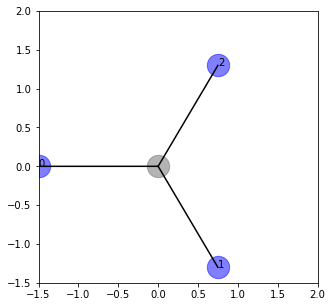

====1th kernel info====
1th-p_support:
torch.Size([3, 2])


1th-x_support:
tensor([[0.6179, 0.0210, 0.8469, 0.4729, 0.7030, 0.3512, 0.6202, 0.0957, 0.1131,
         0.2898, 0.3164, 0.9797, 0.8213, 0.0448, 0.9417, 0.0062, 0.4837, 0.7312,
         0.7416, 0.3661, 0.2207, 0.4279, 0.0108, 0.7508, 0.8967, 0.9778, 0.1087,
         0.5495, 0.4555, 0.3390, 0.9354, 0.8227, 0.1102, 0.9979, 0.2391, 0.8340,
         0.0438, 0.2458, 0.6093, 0.4433, 0.2488, 0.0870, 0.4136, 0.4111, 0.3980,
         0.0432, 0.2216, 0.4015, 0.9039, 0.9675, 0.3396, 0.0222, 0.7625, 0.2504,
         0.3257, 0.3382, 0.4208, 0.9397, 0.8938, 0.6741],
        [0.4051, 0.8913, 0.7471, 0.1440, 0.7237, 0.1128, 0.0078, 0.9597, 0.9030,
         0.8451, 0.9171, 0.9229, 0.5497, 0.0417, 0.5788, 0.3190, 0.9564, 0.7722,
         0.9710, 0.0832, 0.5223, 0.8490, 0.4534, 0.6878, 0.2025, 0.1801, 0.2408,
         0.7990, 0.1875, 0.8030, 0.7599, 0.9186, 0.0168, 0.8647, 0.2726, 0.2818,
         0.5825, 0.3196, 0.0819, 0.8702, 0.3308, 0.8173, 

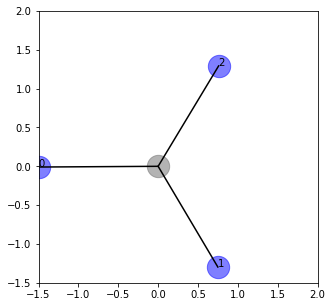

====2th kernel info====
2th-p_support:
torch.Size([3, 2])


2th-x_support:
tensor([[0.8603, 0.0201, 0.1176, 0.9893, 0.8857, 0.7875, 0.4358, 0.0033, 0.6490,
         0.5893, 0.8438, 0.0036, 0.5555, 0.6533, 0.0490, 0.8718, 0.9940, 0.4993,
         0.4059, 0.1680, 0.0241, 0.9284, 0.8017, 0.6665, 0.5235, 0.4646, 0.4906,
         0.4954, 0.0497, 0.2773, 0.5884, 0.1341, 0.3855, 0.1295, 0.9583, 0.1052,
         0.3357, 0.6471, 0.7725, 0.5996, 0.4011, 0.4338, 0.9636, 0.4494, 0.6354,
         0.9611, 0.3618, 0.6949, 0.5626, 0.1120, 0.5925, 0.1672, 0.0369, 0.8648,
         0.9010, 0.1201, 0.2045, 0.4010, 0.8549, 0.7289],
        [0.5686, 0.7381, 0.4593, 0.2822, 0.5303, 0.6698, 0.1746, 0.0449, 0.4957,
         0.1058, 0.4667, 0.2656, 0.8100, 0.5246, 0.6386, 0.1890, 0.5410, 0.5506,
         0.7303, 0.4897, 0.4963, 0.5093, 0.9432, 0.2820, 0.4508, 0.2386, 0.8627,
         0.6138, 0.6225, 0.6776, 0.3330, 0.5498, 0.2161, 0.2351, 0.3865, 0.5784,
         0.4694, 0.1242, 0.3505, 0.7726, 0.8419, 0.6113, 

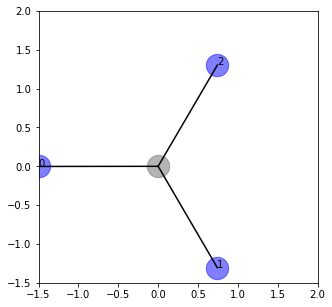

====3th kernel info====
3th-p_support:
torch.Size([3, 2])


3th-x_support:
tensor([[3.2098e-01, 5.2865e-01, 7.9651e-01, 8.8766e-01, 7.7626e-02, 8.9212e-02,
         7.1659e-01, 3.7652e-02, 1.8869e-01, 4.5805e-01, 3.9563e-01, 6.4299e-01,
         8.7057e-01, 8.3704e-01, 2.8632e-01, 9.3286e-01, 6.8700e-01, 3.8429e-01,
         3.0184e-01, 9.4065e-01, 9.0844e-01, 2.8379e-01, 9.8898e-01, 3.2527e-03,
         1.7784e-01, 1.2343e-01, 2.3048e-01, 7.0893e-01, 7.9291e-01, 6.2288e-01,
         6.9565e-01, 1.4407e-01, 2.4992e-01, 2.8444e-01, 4.9010e-01, 8.5995e-01,
         7.5062e-01, 2.4608e-01, 2.9506e-01, 2.7615e-01, 3.8296e-01, 6.2052e-02,
         9.5151e-01, 6.2411e-01, 3.4046e-01, 9.2607e-01, 4.7225e-01, 4.9627e-02,
         6.6192e-01, 4.1710e-01, 7.9601e-01, 2.4984e-01, 5.7063e-01, 8.5313e-01,
         7.7025e-02, 4.4146e-01, 9.9509e-01, 3.5745e-01, 3.9116e-01, 3.3729e-01],
        [7.4636e-02, 6.3239e-01, 7.3810e-01, 7.4017e-01, 5.4657e-04, 1.7052e-01,
         2.9110e-01, 1.0677e-01, 

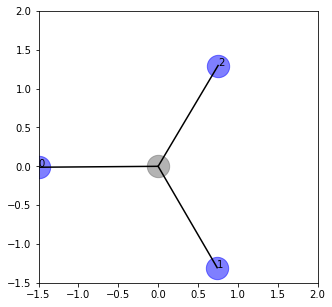

====4th kernel info====
4th-p_support:
torch.Size([3, 2])


4th-x_support:
tensor([[0.2765, 0.4322, 0.2893, 0.0648, 0.7448, 0.6663, 0.5317, 0.6708, 0.5934,
         0.4853, 0.8438, 0.7523, 0.9533, 0.7094, 0.2339, 0.5507, 0.6991, 0.2194,
         0.6573, 0.8047, 0.1692, 0.9276, 0.5764, 0.9075, 0.6479, 0.9699, 0.6263,
         0.7768, 0.4593, 0.6507, 0.5158, 0.4780, 0.9835, 0.9183, 0.2741, 0.6505,
         0.2322, 0.9035, 0.4565, 0.6503, 0.0791, 0.6140, 0.3671, 0.2352, 0.8204,
         0.7252, 0.6815, 0.5930, 0.6742, 0.6506, 0.3187, 0.3124, 0.4674, 0.0570,
         0.0069, 0.4691, 0.8544, 0.6552, 0.4955, 0.3748],
        [0.7230, 0.5514, 0.7741, 0.2975, 0.2825, 0.5777, 0.6118, 0.9127, 0.1978,
         0.3464, 0.3778, 0.4161, 0.9579, 0.1253, 0.0707, 0.5466, 0.0115, 0.3252,
         0.5786, 0.0729, 0.7809, 0.2571, 0.2794, 0.3589, 0.7480, 0.1628, 0.3707,
         0.3327, 0.1008, 0.8168, 0.8242, 0.7078, 0.7423, 0.6122, 0.3509, 0.0963,
         0.4134, 0.6593, 0.3543, 0.9204, 0.7038, 0.9165, 

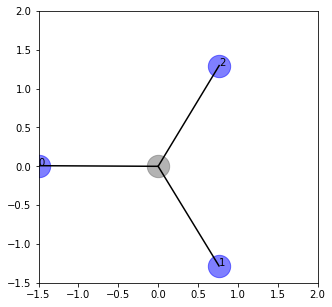

====5th kernel info====
5th-p_support:
torch.Size([3, 2])


5th-x_support:
tensor([[0.9952, 0.4642, 0.6568, 0.4890, 0.7947, 0.0768, 0.5226, 0.7640, 0.8909,
         0.5592, 0.5819, 0.4967, 0.5536, 0.8487, 0.4539, 0.4234, 0.7353, 0.9175,
         0.8644, 0.2177, 0.4802, 0.6560, 0.1287, 0.2130, 0.5368, 0.5328, 0.5735,
         0.6145, 0.6430, 0.7996, 0.0418, 0.5065, 0.2248, 0.2748, 0.1169, 0.2529,
         0.3415, 0.5011, 0.9291, 0.8082, 0.0845, 0.7363, 0.4561, 0.7239, 0.2805,
         0.5384, 0.8985, 0.0306, 0.9615, 0.5785, 0.4026, 0.3116, 0.6771, 0.2479,
         0.6335, 0.1069, 0.8760, 0.8046, 0.5098, 0.6196],
        [0.9069, 0.1060, 0.9841, 0.6373, 0.2384, 0.3912, 0.1402, 0.3616, 0.2789,
         0.3056, 0.1912, 0.2355, 0.1827, 0.0812, 0.5634, 0.2516, 0.9428, 0.2278,
         0.3139, 0.4203, 0.4559, 0.1402, 0.0545, 0.4681, 0.6346, 0.7674, 0.1971,
         0.5587, 0.2790, 0.0551, 0.8950, 0.3590, 0.6487, 0.7187, 0.7555, 0.6736,
         0.2669, 0.9366, 0.8491, 0.4500, 0.9387, 0.5160, 

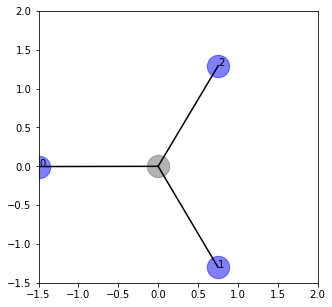

====6th kernel info====
6th-p_support:
torch.Size([3, 2])


6th-x_support:
tensor([[0.1376, 0.3793, 0.4889, 0.2479, 0.4021, 0.5832, 0.0528, 0.0331, 0.8713,
         0.1766, 0.9780, 0.3094, 0.1640, 0.8648, 0.7844, 0.4378, 0.9865, 0.2444,
         0.7543, 0.8165, 0.5606, 0.6699, 0.3160, 0.4245, 0.1237, 0.4094, 0.9635,
         0.3127, 0.7646, 0.5710, 0.6112, 0.2702, 0.1417, 0.7922, 0.0852, 0.2752,
         0.8272, 0.3146, 0.4386, 0.7741, 0.8780, 0.5354, 0.1542, 0.5300, 0.7200,
         0.6250, 0.0600, 0.1065, 0.8517, 0.5807, 0.8523, 0.3110, 0.0314, 0.7993,
         0.1336, 0.3474, 0.3705, 0.2300, 0.3479, 0.0560],
        [0.2063, 0.6698, 0.9332, 0.3333, 0.6450, 0.5081, 0.0303, 0.0280, 0.8060,
         0.3162, 0.8731, 0.7162, 0.5086, 0.5860, 0.8827, 0.6306, 0.4512, 0.2119,
         0.2593, 0.7901, 0.2948, 0.1315, 0.1809, 0.7039, 0.4735, 0.4888, 0.2532,
         0.7788, 0.2735, 0.3906, 0.7945, 0.2453, 0.3062, 0.2823, 0.0528, 0.4348,
         0.3866, 0.5322, 0.5111, 0.1357, 0.2977, 0.4345, 

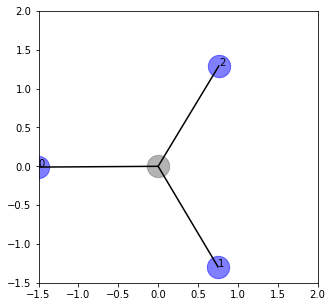

====7th kernel info====
7th-p_support:
torch.Size([3, 2])


7th-x_support:
tensor([[0.2293, 0.6388, 0.8803, 0.1936, 0.7876, 0.7155, 0.5201, 0.2160, 0.4183,
         0.7462, 0.1872, 0.8249, 0.3448, 0.0411, 0.1380, 0.0014, 0.4410, 0.1651,
         0.2574, 0.8940, 0.6266, 0.9537, 0.6969, 0.3853, 0.8772, 0.6665, 0.3826,
         0.7900, 0.8313, 0.2166, 0.4967, 0.3612, 0.3565, 0.2486, 0.9696, 0.3561,
         0.0043, 0.5678, 0.1945, 0.5561, 0.2220, 0.6653, 0.5683, 0.3613, 0.4763,
         0.2096, 0.2330, 0.4493, 0.8296, 0.2278, 0.9824, 0.6123, 0.9889, 0.8891,
         0.2752, 0.0857, 0.3114, 0.3399, 0.8937, 0.7672],
        [0.6844, 0.4539, 0.9125, 0.3731, 0.6389, 0.8951, 0.0268, 0.1494, 0.5441,
         0.0186, 0.6075, 0.4721, 0.1728, 0.5608, 0.6283, 0.0854, 0.1566, 0.7532,
         0.5224, 0.8453, 0.9755, 0.3472, 0.2453, 0.9959, 0.6997, 0.5702, 0.7724,
         0.1314, 0.2097, 0.8128, 0.8107, 0.9069, 0.8936, 0.5161, 0.4645, 0.3508,
         0.4602, 0.4455, 0.6210, 0.1977, 0.1966, 0.8190, 

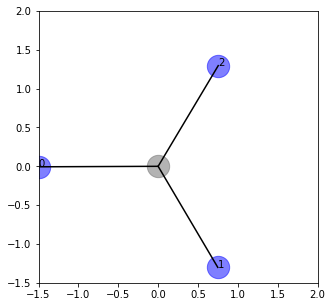

====8th kernel info====
8th-p_support:
torch.Size([3, 2])


8th-x_support:
tensor([[0.4839, 0.1847, 0.0724, 0.8528, 0.0049, 0.5527, 0.3415, 0.6599, 0.8627,
         0.3490, 0.5871, 0.3675, 0.1419, 0.3050, 0.3405, 0.3884, 0.0197, 0.5805,
         0.7847, 0.8543, 0.8757, 0.3337, 0.4912, 0.5378, 0.4074, 0.6059, 0.6979,
         0.2056, 0.2022, 0.9102, 0.0731, 0.9104, 0.2459, 0.6370, 0.3384, 0.1890,
         0.5884, 0.3232, 0.7324, 0.5362, 0.6166, 0.6798, 0.9981, 0.4439, 0.7202,
         0.4413, 0.9655, 0.7366, 0.8015, 0.4263, 0.0249, 0.2724, 0.3774, 0.8318,
         0.7874, 0.2476, 0.4453, 0.9931, 0.7841, 0.7334],
        [0.0794, 0.8679, 0.4883, 0.3089, 0.9503, 0.1970, 0.5599, 0.0825, 0.7284,
         0.8261, 0.9034, 0.2384, 0.9106, 0.4585, 0.1865, 0.0794, 0.3579, 0.4781,
         0.4899, 0.3011, 0.0062, 0.3251, 0.9725, 0.8335, 0.4372, 0.1220, 0.1493,
         0.7605, 0.7246, 0.3077, 0.2741, 0.4891, 0.3616, 0.2339, 0.0635, 0.1088,
         0.7341, 0.5032, 0.4702, 0.4183, 0.7089, 0.6862, 

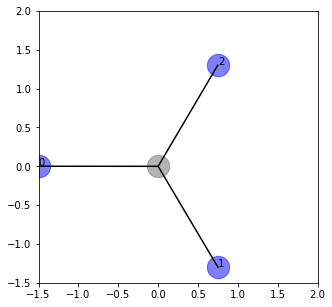

====9th kernel info====
9th-p_support:
torch.Size([3, 2])


9th-x_support:
tensor([[0.2416, 0.3492, 0.3975, 0.4243, 0.6178, 0.9736, 0.2475, 0.9872, 0.8080,
         0.5427, 0.8058, 0.3555, 0.8854, 0.5373, 0.6644, 0.0683, 0.6534, 0.9235,
         0.3271, 0.6826, 0.9041, 0.6926, 0.6001, 0.7501, 0.9933, 0.7750, 0.9162,
         0.4322, 0.2638, 0.4246, 0.6028, 0.6339, 0.4209, 0.9490, 0.5919, 0.3933,
         0.8854, 0.9359, 0.2840, 0.4316, 0.8601, 0.8366, 0.4853, 0.5899, 0.1912,
         0.4815, 0.7270, 0.6063, 0.9868, 0.0905, 0.8779, 0.1312, 0.9882, 0.8169,
         0.4946, 0.0771, 0.7591, 0.6798, 0.9970, 0.3129],
        [0.7205, 0.6763, 0.1273, 0.0091, 0.5402, 0.6606, 0.1589, 0.9153, 0.1243,
         0.8606, 0.3655, 0.0753, 0.0416, 0.2741, 0.3520, 0.7966, 0.1715, 0.3048,
         0.9863, 0.2707, 0.6887, 0.1505, 0.0938, 0.3366, 0.4081, 0.6322, 0.2358,
         0.2122, 0.6782, 0.0365, 0.1557, 0.1886, 0.1315, 0.1282, 0.2406, 0.5385,
         0.9545, 0.0145, 0.0536, 0.4946, 0.3134, 0.8552, 

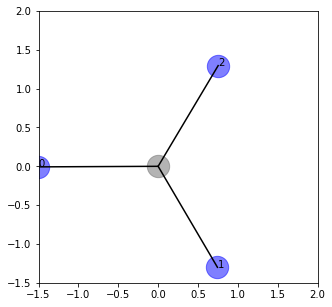

====10th kernel info====
10th-p_support:
torch.Size([3, 2])


10th-x_support:
tensor([[0.7178, 0.2390, 0.1573, 0.5086, 0.8472, 0.5073, 0.8825, 0.4461, 0.5454,
         0.6687, 0.1065, 0.6016, 0.2183, 0.5404, 0.3722, 0.0395, 0.0436, 0.0434,
         0.0600, 0.4230, 0.6341, 0.1405, 0.5144, 0.8604, 0.6453, 0.4758, 0.4459,
         0.3307, 0.4024, 0.5515, 0.1206, 0.1657, 0.6580, 0.9638, 0.6542, 0.2413,
         0.2742, 0.4211, 0.2166, 0.1838, 0.2870, 0.3785, 0.6484, 0.9720, 0.6701,
         0.8557, 0.5284, 0.9383, 0.7712, 0.3342, 0.7486, 0.7348, 0.3329, 0.4656,
         0.4951, 0.3136, 0.9881, 0.0680, 0.9893, 0.3665],
        [0.7876, 0.8431, 0.4997, 0.5689, 0.3866, 0.7036, 0.5663, 0.9131, 0.4084,
         0.7891, 0.0127, 0.7856, 0.6406, 0.7691, 0.9283, 0.7053, 0.4477, 0.3148,
         0.1823, 0.8429, 0.7367, 0.5158, 0.6374, 0.0883, 0.5639, 0.1840, 0.8872,
         0.3260, 0.7323, 0.3385, 0.4799, 0.5878, 0.3682, 0.7203, 0.4531, 0.1304,
         0.4846, 0.4132, 0.2730, 0.2847, 0.9356, 0.306

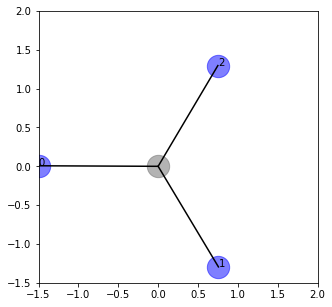

====11th kernel info====
11th-p_support:
torch.Size([3, 2])


11th-x_support:
tensor([[0.3950, 0.7410, 0.2678, 0.4208, 0.0681, 0.1352, 0.8324, 0.9182, 0.4939,
         0.4937, 0.9692, 0.2477, 0.9695, 0.5509, 0.0024, 0.7757, 0.8764, 0.1599,
         0.7996, 0.0768, 0.2150, 0.5010, 0.3670, 0.0311, 0.6270, 0.2404, 0.0994,
         0.1519, 0.0732, 0.1948, 0.8135, 0.3949, 0.7597, 0.2168, 0.0666, 0.7678,
         0.5935, 0.1774, 0.1679, 0.0455, 0.2444, 0.5491, 0.9149, 0.4838, 0.0350,
         0.1124, 0.6223, 0.6043, 0.8974, 0.9484, 0.0977, 0.7731, 0.4859, 0.3202,
         0.9038, 0.6973, 0.0138, 0.6990, 0.6901, 0.6560],
        [0.6387, 0.7517, 0.0792, 0.4628, 0.8686, 0.8427, 0.8834, 0.8207, 0.1742,
         0.2940, 0.3089, 0.2385, 0.9910, 0.7840, 0.5102, 0.7779, 0.1137, 0.9129,
         0.3125, 0.7186, 0.3044, 0.6186, 0.1135, 0.9761, 0.0586, 0.7153, 0.5523,
         0.0108, 0.4825, 0.5329, 0.1864, 0.0332, 0.2545, 0.0466, 0.2374, 0.9910,
         0.7188, 0.0097, 0.8694, 0.9329, 0.2021, 0.627

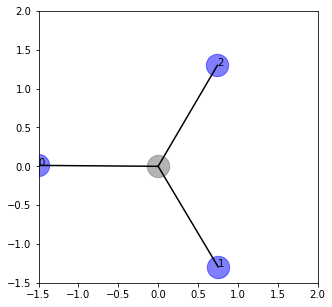

====12th kernel info====
12th-p_support:
torch.Size([3, 2])


12th-x_support:
tensor([[0.5561, 0.9521, 0.6307, 0.0896, 0.8942, 0.7854, 0.2547, 0.0561, 0.7382,
         0.6042, 0.3079, 0.2978, 0.6847, 0.9400, 0.5424, 0.6576, 0.1205, 0.0624,
         0.1243, 0.9967, 0.9487, 0.2743, 0.9087, 0.6986, 0.4998, 0.6951, 0.4647,
         0.4160, 0.0712, 0.8604, 0.1292, 0.5644, 0.7377, 0.0964, 0.0390, 0.1533,
         0.0946, 0.4221, 0.3311, 0.9319, 0.4831, 0.9475, 0.7583, 0.0401, 0.8842,
         0.6654, 0.5551, 0.2516, 0.9851, 0.9572, 0.3053, 0.5048, 0.1622, 0.4604,
         0.1360, 0.8620, 0.7285, 0.0593, 0.9173, 0.6361],
        [0.6443, 0.1826, 0.2678, 0.5640, 0.4743, 0.2357, 0.7087, 0.4988, 0.9784,
         0.9572, 0.6194, 0.8763, 0.1902, 0.6286, 0.3395, 0.4725, 0.6844, 0.0159,
         0.6999, 0.2549, 0.8942, 0.6123, 0.5752, 0.4008, 0.4236, 0.7138, 0.7998,
         0.3083, 0.3841, 0.5336, 0.2665, 0.6772, 0.2484, 0.5572, 0.3191, 0.7587,
         0.7960, 0.3468, 0.7100, 0.6027, 0.5530, 0.552

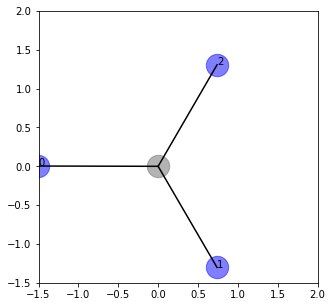

====13th kernel info====
13th-p_support:
torch.Size([3, 2])


13th-x_support:
tensor([[0.5189, 0.4911, 0.9557, 0.6288, 0.3858, 0.0090, 0.0776, 0.7727, 0.4378,
         0.3500, 0.0091, 0.1075, 0.1647, 0.0023, 0.7271, 0.1910, 0.4153, 0.0016,
         0.2543, 0.0527, 0.9103, 0.4806, 0.5579, 0.8113, 0.5411, 0.7891, 0.9622,
         0.5114, 0.2268, 0.1337, 0.9254, 0.0601, 0.3911, 0.0800, 0.7475, 0.6171,
         0.2953, 0.3719, 0.8504, 0.6184, 0.7628, 0.6179, 0.8144, 0.7524, 0.4526,
         0.8750, 0.1639, 0.9314, 0.6473, 0.2859, 0.2783, 0.2697, 0.2574, 0.0139,
         0.4757, 0.8421, 0.1696, 0.7055, 0.5332, 0.4231],
        [0.7184, 0.3540, 0.3682, 0.5188, 0.9266, 0.3221, 0.5990, 0.8671, 0.2733,
         0.9753, 0.6597, 0.6975, 0.2134, 0.7535, 0.4898, 0.7648, 0.5038, 0.5930,
         0.0287, 0.3144, 0.4778, 0.4692, 0.8207, 0.6413, 0.8485, 0.2090, 0.4435,
         0.0159, 0.3119, 0.6257, 0.0403, 0.5866, 0.6052, 0.7297, 0.5354, 0.3164,
         0.7718, 0.8172, 0.2299, 0.0557, 0.2364, 0.973

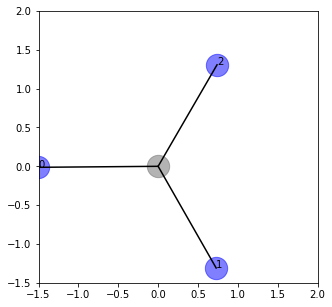

====14th kernel info====
14th-p_support:
torch.Size([3, 2])


14th-x_support:
tensor([[0.2185, 0.5075, 0.2868, 0.7118, 0.6129, 0.4809, 0.8043, 0.8052, 0.0483,
         0.2452, 0.9852, 0.7378, 0.6773, 0.0612, 0.8150, 0.2918, 0.0868, 0.6499,
         0.2497, 0.6525, 0.8648, 0.0542, 0.1807, 0.0159, 0.6047, 0.1992, 0.2225,
         0.9103, 0.5401, 0.7310, 0.6840, 0.0668, 0.5802, 0.9296, 0.4854, 0.9762,
         0.9316, 0.4986, 0.4576, 0.4637, 0.2401, 0.4160, 0.7651, 0.4560, 0.3111,
         0.3485, 0.3308, 0.8854, 0.2080, 0.8993, 0.5042, 0.6132, 0.8057, 0.6956,
         0.2020, 0.7713, 0.7217, 0.1079, 0.0505, 0.3817],
        [0.2043, 0.3151, 0.2054, 0.8224, 0.5373, 0.7314, 0.1353, 0.6910, 0.1886,
         0.9460, 0.0823, 0.3652, 0.7451, 0.0699, 0.9736, 0.5199, 0.3363, 0.7853,
         0.4644, 0.1432, 0.2503, 0.4320, 0.8001, 0.4225, 0.3854, 0.2814, 0.1061,
         0.6321, 0.1233, 0.8247, 0.3057, 0.5069, 0.4369, 0.1074, 0.9360, 0.9783,
         0.9590, 0.5624, 0.2447, 0.9885, 0.6608, 0.453

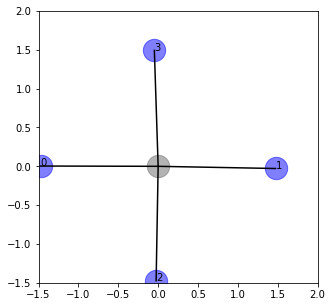

====0th kernel info====
0th-p_support:
torch.Size([4, 2])


0th-x_support:
tensor([[0.5683, 0.3703, 0.1194, 0.4131, 0.8631, 0.0717, 0.2069, 0.3340, 0.9836,
         0.1873, 0.2606, 0.3712, 0.0746, 0.1485, 0.3947, 0.4039, 0.5931, 0.0815,
         0.1452, 0.7086, 0.9030, 0.4508, 0.7386, 0.3117, 0.8390, 0.6993, 0.3876,
         0.4858, 0.3040, 0.4815, 0.7532, 0.5072, 0.6062, 0.4081, 0.1981, 0.5713,
         0.9292, 0.0584, 0.1619, 0.6266, 0.2597, 0.2047, 0.5704, 0.8303, 0.1831,
         0.7615, 0.8133, 0.7314, 0.4218, 0.1331, 0.0044, 0.1205, 0.4825, 0.4052,
         0.9162, 0.7658, 0.1106, 0.3903, 0.9725, 0.7528],
        [0.0905, 0.8250, 0.8618, 0.2436, 0.9956, 0.6512, 0.8364, 0.3626, 0.3457,
         0.8119, 0.0045, 0.7877, 0.1737, 0.0121, 0.1885, 0.4169, 0.2060, 0.7365,
         0.4900, 0.3735, 0.6200, 0.2892, 0.7659, 0.5205, 0.7999, 0.0019, 0.2978,
         0.0084, 0.9738, 0.0353, 0.8547, 0.1593, 0.2031, 0.2179, 0.1274, 0.7666,
         0.1740, 0.4442, 0.8644, 0.9864, 0.2069, 0.7934, 

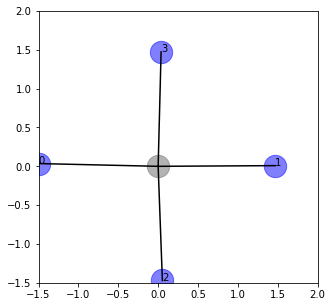

====1th kernel info====
1th-p_support:
torch.Size([4, 2])


1th-x_support:
tensor([[0.2237, 0.8953, 0.3614, 0.4827, 0.4597, 0.1006, 0.6286, 0.0025, 0.4054,
         0.8566, 0.4901, 0.2868, 0.8615, 0.1937, 0.4078, 0.4780, 0.3174, 0.3908,
         0.4503, 0.6007, 0.0758, 0.2511, 0.5966, 0.5900, 0.7422, 0.3415, 0.9871,
         0.8937, 0.6534, 0.4948, 0.9663, 0.7183, 0.0501, 0.3536, 0.9675, 0.4285,
         0.1245, 0.8493, 0.3303, 0.9804, 0.1365, 0.5895, 0.1760, 0.8386, 0.4193,
         0.3161, 0.9839, 0.7770, 0.8941, 0.6861, 0.5633, 0.5155, 0.3058, 0.8490,
         0.7792, 0.3860, 0.8316, 0.6081, 0.4667, 0.7330],
        [0.0409, 0.0703, 0.5795, 0.0556, 0.8884, 0.0349, 0.2095, 0.5061, 0.3200,
         0.3922, 0.9171, 0.7086, 0.6304, 0.7280, 0.2829, 0.8440, 0.7528, 0.2318,
         0.5734, 0.9688, 0.5541, 0.2761, 0.2105, 0.5740, 0.3178, 0.5749, 0.4975,
         0.5233, 0.1434, 0.2010, 0.0133, 0.2936, 0.9319, 0.5412, 0.2530, 0.7924,
         0.1750, 0.6299, 0.1035, 0.9659, 0.5826, 0.0418, 

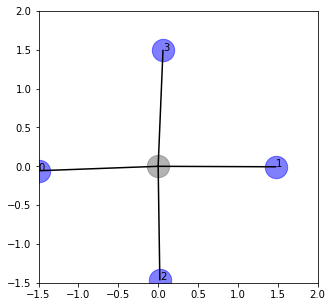

====2th kernel info====
2th-p_support:
torch.Size([4, 2])


2th-x_support:
tensor([[0.7471, 0.3895, 0.1607, 0.9292, 0.5110, 0.6316, 0.5797, 0.4625, 0.7355,
         0.4812, 0.7230, 0.1798, 0.8918, 0.2155, 0.4692, 0.2090, 0.5562, 0.6511,
         0.2790, 0.5600, 0.4437, 0.8698, 0.1853, 0.5263, 0.5705, 0.8673, 0.9175,
         0.7961, 0.1549, 0.7235, 0.9509, 0.0903, 0.7938, 0.9625, 0.9327, 0.7013,
         0.1395, 0.7533, 0.0010, 0.9386, 0.9983, 0.3916, 0.3484, 0.6849, 0.2506,
         0.7320, 0.9110, 0.3604, 0.3416, 0.2782, 0.8430, 0.6127, 0.3182, 0.8972,
         0.8874, 0.9159, 0.0856, 0.7655, 0.0512, 0.2322],
        [0.4021, 0.0280, 0.9041, 0.1584, 0.1506, 0.4746, 0.3262, 0.3026, 0.6120,
         0.3082, 0.4465, 0.8129, 0.5464, 0.3801, 0.4428, 0.4264, 0.7928, 0.5839,
         0.4364, 0.1392, 0.1946, 0.7790, 0.7933, 0.0596, 0.4176, 0.8500, 0.4076,
         0.5360, 0.3857, 0.9599, 0.2102, 0.4380, 0.0505, 0.6797, 0.8236, 0.9426,
         0.1747, 0.0203, 0.1699, 0.3613, 0.4391, 0.5204, 

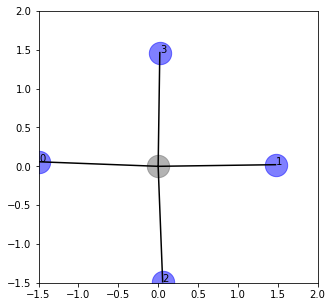

====3th kernel info====
3th-p_support:
torch.Size([4, 2])


3th-x_support:
tensor([[0.9849, 0.5226, 0.6403, 0.8208, 0.2874, 0.4113, 0.2458, 0.1281, 0.6486,
         0.5152, 0.8118, 0.3326, 0.0573, 0.8295, 0.9370, 0.5109, 0.4953, 0.1058,
         0.5842, 0.8358, 0.1179, 0.1252, 0.2113, 0.4880, 0.1047, 0.6140, 0.4830,
         0.2888, 0.4703, 0.6905, 0.5677, 0.6915, 0.4714, 0.4842, 0.2513, 0.7139,
         0.0296, 0.7097, 0.3564, 0.5276, 0.8892, 0.6875, 0.9149, 0.5297, 0.3294,
         0.9330, 0.7540, 0.4787, 0.7804, 0.5986, 0.4047, 0.9452, 0.4423, 0.2191,
         0.3783, 0.0581, 0.2921, 0.8812, 0.4698, 0.1035],
        [0.0067, 0.1056, 0.0016, 0.4361, 0.5939, 0.5008, 0.1538, 0.8397, 0.1327,
         0.5332, 0.9436, 0.6248, 0.0047, 0.2158, 0.2469, 0.3648, 0.4019, 0.1367,
         0.6074, 0.7082, 0.4829, 0.4409, 0.1323, 0.9175, 0.4185, 0.2895, 0.5586,
         0.0513, 0.6661, 0.0986, 0.1962, 0.4696, 0.0695, 0.3149, 0.2615, 0.6472,
         0.0670, 0.3381, 0.4872, 0.8859, 0.1567, 0.8295, 

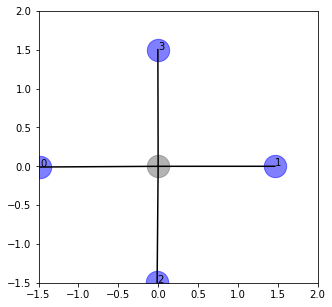

====4th kernel info====
4th-p_support:
torch.Size([4, 2])


4th-x_support:
tensor([[1.8745e-01, 5.8676e-01, 6.9562e-01, 3.5448e-01, 7.1370e-01, 5.5126e-02,
         4.3001e-01, 8.0630e-01, 4.5943e-01, 5.5805e-01, 1.9497e-01, 4.0116e-01,
         7.6758e-01, 1.0678e-01, 2.8938e-01, 2.2432e-01, 2.0013e-02, 6.1246e-02,
         9.2440e-01, 3.5007e-01, 9.5376e-01, 5.8852e-02, 2.9341e-01, 2.0091e-01,
         9.9567e-02, 6.8184e-01, 8.4643e-01, 4.6468e-01, 1.4761e-01, 7.7614e-01,
         5.9850e-04, 1.1046e-01, 1.5570e-01, 4.4772e-01, 9.9253e-01, 7.3472e-01,
         4.6855e-01, 4.3893e-01, 2.1292e-01, 9.5715e-01, 9.2682e-03, 8.7304e-01,
         7.6081e-01, 1.7839e-01, 6.9606e-01, 1.5726e-01, 7.2048e-01, 9.1649e-01,
         6.8735e-01, 2.1062e-01, 5.4760e-01, 1.0069e-01, 9.0816e-01, 4.0710e-01,
         3.9754e-01, 9.3263e-01, 1.6793e-01, 8.8355e-01, 3.4669e-02, 7.3802e-01],
        [3.1191e-01, 9.5043e-01, 3.9614e-01, 9.8368e-01, 2.3206e-01, 6.6733e-02,
         5.1011e-01, 9.9527e-01, 

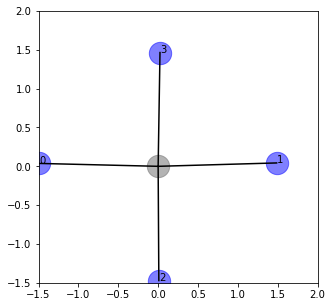

====5th kernel info====
5th-p_support:
torch.Size([4, 2])


5th-x_support:
tensor([[2.6729e-01, 5.0888e-01, 5.5959e-01, 8.3858e-01, 5.8436e-01, 6.8974e-01,
         3.2081e-01, 7.4810e-02, 1.7205e-01, 4.5107e-03, 5.7831e-01, 5.0145e-04,
         2.2394e-01, 7.2347e-01, 2.5954e-01, 4.3241e-01, 4.1694e-01, 6.8634e-01,
         4.9507e-01, 9.0084e-01, 1.1990e-01, 4.1926e-01, 3.5416e-01, 8.4999e-01,
         9.1833e-01, 6.3125e-01, 2.1093e-01, 2.8520e-01, 5.7427e-01, 3.4511e-01,
         5.7311e-02, 2.3496e-01, 5.0095e-01, 6.7492e-01, 3.9581e-01, 6.4877e-01,
         3.9765e-01, 3.5146e-01, 5.2798e-01, 1.4407e-01, 7.2358e-01, 9.3139e-01,
         8.7687e-01, 1.8990e-01, 8.8704e-01, 7.6842e-01, 8.4652e-01, 2.3086e-02,
         9.9556e-01, 9.9261e-01, 8.9281e-01, 9.7838e-01, 5.5230e-01, 4.8896e-01,
         2.5462e-01, 9.1630e-01, 4.1304e-01, 8.9206e-01, 6.6913e-01, 5.6821e-01],
        [8.1423e-01, 9.3183e-01, 3.6286e-01, 2.5120e-01, 5.4378e-01, 1.1858e-01,
         7.4541e-01, 6.8741e-01, 

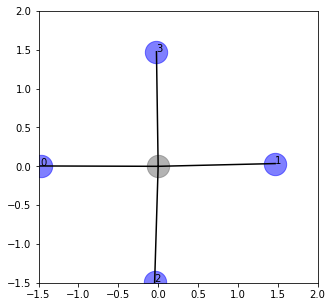

====6th kernel info====
6th-p_support:
torch.Size([4, 2])


6th-x_support:
tensor([[0.4075, 0.4159, 0.0577, 0.1821, 0.0858, 0.4881, 0.5858, 0.1076, 0.8665,
         0.7667, 0.7606, 0.5647, 0.3973, 0.0981, 0.6968, 0.6702, 0.8040, 0.6634,
         0.0079, 0.7127, 0.6307, 0.3528, 0.6942, 0.8996, 0.2727, 0.6585, 0.4834,
         0.6729, 0.6407, 0.8760, 0.7202, 0.5887, 0.3938, 0.3493, 0.6588, 0.6187,
         0.8156, 0.1982, 0.0448, 0.9934, 0.1149, 0.1242, 0.4644, 0.7424, 0.0639,
         0.6522, 0.8641, 0.2559, 0.7584, 0.2349, 0.2319, 0.4318, 0.3730, 0.4473,
         0.4838, 0.4440, 0.2506, 0.7218, 0.8203, 0.3878],
        [0.8324, 0.3346, 0.8537, 0.3225, 0.2067, 0.0696, 0.2994, 0.6466, 0.4373,
         0.0921, 0.0010, 0.9119, 0.0750, 0.8949, 0.6274, 0.8669, 0.0298, 0.7880,
         0.0853, 0.6599, 0.5760, 0.0352, 0.8418, 0.9958, 0.3928, 0.7075, 0.4120,
         0.7624, 0.8320, 0.2728, 0.1515, 0.8441, 0.9160, 0.0901, 0.1196, 0.9351,
         0.2897, 0.2301, 0.3898, 0.5001, 0.8091, 0.7821, 

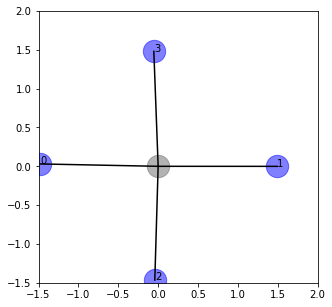

====7th kernel info====
7th-p_support:
torch.Size([4, 2])


7th-x_support:
tensor([[7.4673e-01, 3.3822e-01, 1.1105e-01, 1.1978e-02, 5.2947e-01, 1.0881e-01,
         5.6168e-01, 6.4137e-01, 8.8912e-01, 8.2321e-01, 4.8620e-01, 4.9153e-01,
         9.6562e-01, 2.5349e-01, 4.3499e-01, 5.8792e-01, 4.4627e-01, 8.1083e-01,
         7.2943e-01, 9.5420e-01, 3.7670e-01, 8.2958e-01, 7.8533e-01, 2.9550e-01,
         7.6233e-01, 2.4209e-01, 2.1913e-01, 3.0017e-01, 4.4395e-01, 2.7633e-01,
         5.7373e-01, 9.7348e-01, 1.9851e-01, 4.7922e-01, 8.9363e-01, 1.4781e-01,
         7.9274e-01, 9.3080e-01, 4.3014e-01, 8.9199e-01, 5.0170e-01, 6.1576e-01,
         7.4220e-02, 5.1850e-04, 2.1844e-01, 2.9006e-01, 5.4915e-01, 6.3850e-01,
         2.4479e-01, 9.8642e-01, 5.0314e-02, 9.6311e-01, 1.1530e-01, 2.8968e-01,
         3.1937e-01, 6.3308e-01, 2.5241e-01, 1.3055e-01, 4.1652e-01, 6.2400e-01],
        [8.6391e-01, 6.4135e-01, 4.2695e-01, 5.9495e-01, 2.6966e-01, 9.4904e-01,
         4.8666e-01, 2.3624e-01, 

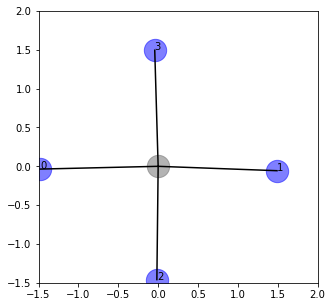

====8th kernel info====
8th-p_support:
torch.Size([4, 2])


8th-x_support:
tensor([[0.9569, 0.3718, 0.2157, 0.4078, 0.2607, 0.9209, 0.2041, 0.8599, 0.7780,
         0.7626, 0.9284, 0.4232, 0.1619, 0.5355, 0.4254, 0.6663, 0.0459, 0.3989,
         0.4805, 0.9951, 0.3497, 0.3555, 0.7842, 0.7346, 0.7530, 0.3270, 0.1004,
         0.0030, 0.9429, 0.7568, 0.6688, 0.4417, 0.8997, 0.1308, 0.9767, 0.2935,
         0.1788, 0.6881, 0.8027, 0.5329, 0.6145, 0.5019, 0.0647, 0.6279, 0.9115,
         0.8055, 0.5284, 0.1512, 0.3425, 0.5036, 0.7557, 0.7838, 0.6290, 0.0465,
         0.0213, 0.2880, 0.1141, 0.7926, 0.0857, 0.0593],
        [0.4667, 0.9495, 0.7623, 0.5796, 0.1169, 0.3788, 0.5227, 0.1189, 0.7661,
         0.8217, 0.0860, 0.6349, 0.6294, 0.9687, 0.0893, 0.6476, 0.0166, 0.2753,
         0.6632, 0.3561, 0.0421, 0.8712, 0.3117, 0.5517, 0.0339, 0.6404, 0.5868,
         0.1301, 0.4773, 0.4059, 0.8914, 0.6227, 0.0371, 0.6505, 0.3100, 0.7892,
         0.6235, 0.3319, 0.6488, 0.7387, 0.8519, 0.6491, 

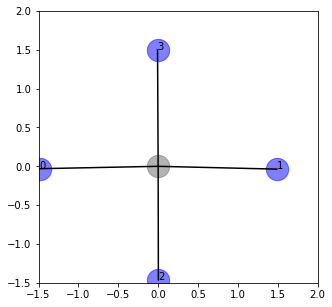

====9th kernel info====
9th-p_support:
torch.Size([4, 2])


9th-x_support:
tensor([[0.0718, 0.3912, 0.2055, 0.0326, 0.6637, 0.6563, 0.2118, 0.5293, 0.1053,
         0.7827, 0.1514, 0.4697, 0.4511, 0.2438, 0.8781, 0.1253, 0.4470, 0.7207,
         0.4388, 0.4343, 0.6142, 0.9112, 0.7932, 0.8596, 0.5804, 0.8442, 0.7620,
         0.5372, 0.4462, 0.7061, 0.7523, 0.5834, 0.1510, 0.5750, 0.2684, 0.6104,
         0.7871, 0.2012, 0.4888, 0.6370, 0.4947, 0.9878, 0.8290, 0.7500, 0.4031,
         0.5045, 0.7091, 0.6034, 0.8764, 0.9095, 0.3303, 0.4042, 0.4226, 0.4390,
         0.5013, 0.7630, 0.0318, 0.0757, 0.1234, 0.7130],
        [0.7768, 0.8740, 0.4835, 0.5967, 0.3415, 0.3023, 0.9148, 0.5544, 0.5339,
         0.1894, 0.1018, 0.3188, 0.9725, 0.9411, 0.7279, 0.5119, 0.1054, 0.4027,
         0.5404, 0.0113, 0.2494, 0.1351, 0.0583, 0.1192, 0.5968, 0.5006, 0.8362,
         0.7373, 0.6144, 0.8730, 0.9547, 0.0719, 0.3535, 0.7746, 0.6679, 0.2409,
         0.4839, 0.9088, 0.3594, 0.2460, 0.8088, 0.8600, 

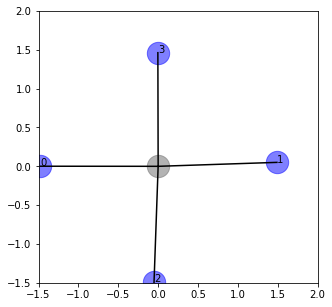

====10th kernel info====
10th-p_support:
torch.Size([4, 2])


10th-x_support:
tensor([[0.2950, 0.4650, 0.7382, 0.0462, 0.7622, 0.6035, 0.6367, 0.3619, 0.5539,
         0.5978, 0.7095, 0.0057, 0.8298, 0.8136, 0.4130, 0.4408, 0.8083, 0.6375,
         0.1572, 0.4171, 0.2258, 0.5979, 0.0870, 0.7995, 0.2385, 0.1821, 0.1094,
         0.6519, 0.0281, 0.7043, 0.8060, 0.9723, 0.7831, 0.3762, 0.9939, 0.0543,
         0.4141, 0.7422, 0.0217, 0.2948, 0.1676, 0.1932, 0.8833, 0.4401, 0.2875,
         0.6641, 0.5798, 0.3671, 0.0855, 0.3371, 0.1511, 0.7131, 0.8635, 0.6239,
         0.6180, 0.8357, 0.6939, 0.6775, 0.3478, 0.3937],
        [0.1221, 0.5268, 0.9436, 0.5225, 0.7030, 0.8437, 0.5240, 0.8070, 0.1154,
         0.8155, 0.5537, 0.2493, 0.4773, 0.1059, 0.8655, 0.1133, 0.0667, 0.1624,
         0.2630, 0.1572, 0.7015, 0.5006, 0.9937, 0.8865, 0.9658, 0.4394, 0.0743,
         0.6726, 0.2038, 0.0743, 0.7408, 0.8954, 0.8845, 0.2636, 0.5732, 0.9218,
         0.6822, 0.4022, 0.3211, 0.9044, 0.3174, 0.053

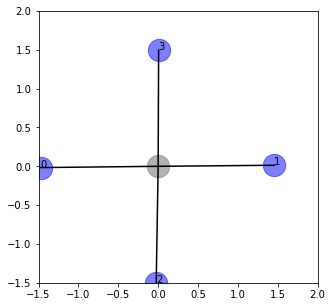

====11th kernel info====
11th-p_support:
torch.Size([4, 2])


11th-x_support:
tensor([[0.1774, 0.4877, 0.6458, 0.8920, 0.0259, 0.9766, 0.9964, 0.7448, 0.0539,
         0.5020, 0.2013, 0.7618, 0.1500, 0.6674, 0.1177, 0.9361, 0.3321, 0.1395,
         0.5541, 0.7781, 0.8803, 0.2096, 0.9551, 0.1853, 0.3900, 0.4981, 0.3460,
         0.8241, 0.7081, 0.2141, 0.8509, 0.9424, 0.8915, 0.1232, 0.1748, 0.4603,
         0.1161, 0.9644, 0.0919, 0.2791, 0.1744, 0.6524, 0.4943, 0.1439, 0.3154,
         0.4917, 0.6992, 0.8625, 0.1799, 0.7840, 0.6759, 0.3094, 0.1510, 0.6089,
         0.1851, 0.4391, 0.2384, 0.4810, 0.1119, 0.6492],
        [0.4551, 0.6173, 0.6161, 0.1434, 0.0504, 0.8590, 0.3291, 0.5663, 0.6628,
         0.8465, 0.3299, 0.9519, 0.9034, 0.8063, 0.0022, 0.7657, 0.3639, 0.6887,
         0.7388, 0.5471, 0.4941, 0.8003, 0.7058, 0.2236, 0.2952, 0.7833, 0.4883,
         0.4601, 0.3481, 0.1489, 0.5203, 0.6265, 0.4221, 0.6807, 0.9040, 0.1276,
         0.1485, 0.2392, 0.1036, 0.6594, 0.6363, 0.239

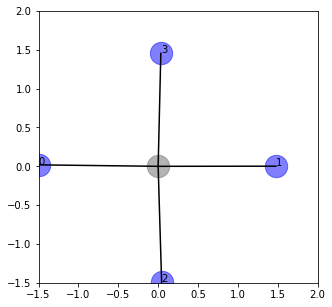

====12th kernel info====
12th-p_support:
torch.Size([4, 2])


12th-x_support:
tensor([[0.7015, 0.0113, 0.9781, 0.0988, 0.6043, 0.8019, 0.9669, 0.4143, 0.8594,
         0.9372, 0.7472, 0.2777, 0.4353, 0.9511, 0.4466, 0.9964, 0.6967, 0.5384,
         0.0794, 0.7288, 0.2634, 0.9956, 0.0336, 0.3144, 0.0555, 0.9573, 0.3614,
         0.0849, 0.8931, 0.3697, 0.6902, 0.3257, 0.4841, 0.9865, 0.0096, 0.7867,
         0.0485, 0.7290, 0.6457, 0.7985, 0.6011, 0.5965, 0.2426, 0.9243, 0.0240,
         0.2240, 0.2574, 0.6274, 0.3031, 0.0333, 0.7374, 0.5386, 0.3875, 0.4786,
         0.5707, 0.8425, 0.7831, 0.2717, 0.4332, 0.3092],
        [0.2573, 0.9758, 0.0136, 0.8890, 0.0374, 0.2927, 0.4121, 0.8488, 0.2518,
         0.4617, 0.5282, 0.2110, 0.7314, 0.5352, 0.4405, 0.1703, 0.4061, 0.2819,
         0.8947, 0.5807, 0.1419, 0.2819, 0.4248, 0.3161, 0.4218, 0.0831, 0.1923,
         0.0395, 0.4703, 0.3312, 0.0791, 0.9872, 0.1120, 0.6672, 0.1067, 0.8140,
         0.3527, 0.6809, 0.3727, 0.5566, 0.1174, 0.565

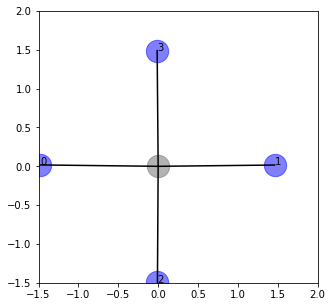

====13th kernel info====
13th-p_support:
torch.Size([4, 2])


13th-x_support:
tensor([[0.7332, 0.1307, 0.6246, 0.6950, 0.1428, 0.3888, 0.3268, 0.5072, 0.5559,
         0.0602, 0.7169, 0.5807, 0.2725, 0.9377, 0.1575, 0.8808, 0.9818, 0.8163,
         0.0228, 0.4095, 0.4234, 0.6097, 0.0311, 0.6358, 0.7773, 0.4349, 0.8745,
         0.2640, 0.1724, 0.9038, 0.5997, 0.8233, 0.9875, 0.1964, 0.3601, 0.0566,
         0.4816, 0.8305, 0.8014, 0.4321, 0.2238, 0.4954, 0.7804, 0.6803, 0.2559,
         0.2781, 0.1062, 0.9931, 0.5639, 0.0647, 0.1117, 0.1930, 0.6799, 0.5816,
         0.0218, 0.8358, 0.4705, 0.1735, 0.6070, 0.3441],
        [0.0990, 0.6060, 0.3484, 0.6126, 0.5298, 0.4800, 0.5093, 0.2080, 0.4779,
         0.0461, 0.5235, 0.1965, 0.7537, 0.7490, 0.8243, 0.5791, 0.1413, 0.9463,
         0.4800, 0.2315, 0.8306, 0.4319, 0.8599, 0.1755, 0.7795, 0.6231, 0.0976,
         0.0038, 0.6962, 0.6723, 0.6383, 0.9070, 0.6127, 0.1179, 0.6938, 0.5720,
         0.3003, 0.9005, 0.0394, 0.0681, 0.1069, 0.155

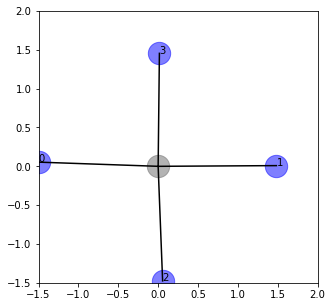

====14th kernel info====
14th-p_support:
torch.Size([4, 2])


14th-x_support:
tensor([[0.0527, 0.8937, 0.7460, 0.9222, 0.7074, 0.5719, 0.3279, 0.9664, 0.8937,
         0.9205, 0.6268, 0.0582, 0.9636, 0.4817, 0.6001, 0.1904, 0.8880, 0.8618,
         0.7961, 0.9804, 0.4940, 0.4844, 0.4367, 0.0497, 0.3271, 0.9121, 0.8421,
         0.3320, 0.1496, 0.4718, 0.0082, 0.2732, 0.1793, 0.4004, 0.2608, 0.0569,
         0.5902, 0.2633, 0.7456, 0.4999, 0.7563, 0.7798, 0.7595, 0.3373, 0.2577,
         0.1059, 0.5179, 0.4984, 0.4987, 0.7929, 0.3000, 0.5578, 0.7883, 0.3825,
         0.3689, 0.5560, 0.9466, 0.5672, 0.6708, 0.8623],
        [0.3539, 0.4898, 0.5563, 0.4013, 0.7376, 0.3812, 0.9568, 0.8870, 0.2626,
         0.7337, 0.0914, 0.2989, 0.9829, 0.7461, 0.6238, 0.9237, 0.7652, 0.7481,
         0.4933, 0.6287, 0.5296, 0.0605, 0.3463, 0.0436, 0.3282, 0.1238, 0.4379,
         0.5114, 0.4147, 0.7703, 0.1767, 0.5095, 0.8771, 0.9467, 0.4439, 0.2931,
         0.2546, 0.4107, 0.5630, 0.5045, 0.2946, 0.873

In [97]:
# visualize saved model kernels
model = PredefinedKernelSetConv(D=2, node_attr_dim=60, edge_attr_dim=1, L1=15, L2=15, L3=15, L4=15, is_first_layer=False)
# model = KernelSetConv(D=2, node_attr_dim = 5, edge_attr_dim = 1, L1=15, L2=15, L3=15, L4=15)
model.load_state_dict(torch.load('../saved_kernellayers/baseline-2/3th_layer.pth'))

#1K_no_fixed_kernels/0th_layer.pth
#3Ksamples.pth
#1Ksamples.pth
print(list(model.state_dict()))
vis_kernel_in_kernelsetconv(model, prefix='trainable')